In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from statsmodels.distributions.empirical_distribution import ECDF
import networkx.algorithms.community as nx_comm
import plotly.express as px
#import community as louvain
from sklearn.metrics import confusion_matrix

#Plotting parameters
sns.set(rc={"figure.dpi":300, "savefig.dpi":300})
sns.set_context('notebook')
sns.set_style("ticks")

In [2]:
#import file
dta = pd.read_csv('wheat_trade_network.csv')
nodes_tab = pd.read_csv('nodes_table.csv')

#create list of nodes 
nodes = nodes_tab.Id.values

#create list of (weighted) edges
edges = list(zip(dta.Source.values,dta.Target.values, dta.Weight.values))

In [3]:
#initialize the (weighted and directed) graph
G = nx.DiGraph()

#insert nodes
G.add_nodes_from(nodes)
#and their 'Zone' attribute
for i in range(len(nodes)): 
    G.nodes[nodes[i]]['Zone'] = nodes_tab.Zone.values[i]

#insert weighted edges
G.add_weighted_edges_from(edges)

In [4]:
#Create list of nodes for each zone
zones = [z for z in nodes_tab.Zone.unique()]
d = {}
for z in zones: 
    d[z] = nodes_tab.Id[nodes_tab.Zone == z].values

# Index

* [Generic info on the graph](#EDA)
* [Random graph](#Random-graph)
* [Out degree](#Out-degree)
* [In degree](#In-degree)
* [Total degree](#Total-degree)
* [Import-export](#Import-Export)
* [Centrality measures](#Centrality-measures)
* [Reciprocity & Motifs](#Reciprocity-&-Motifs)
* [Community detection](#Community-detection)
* [Greedy approach](#Greedy-approach)
* [Louvain](#Louvain)
* [Comparison](#Comparison)
* [Centrality in the community](#Centrality-in-the-community)
* [Partition evaluation](#Partition-evaluation)
* [Limitations](#Limitations)
* [Conclusions](#Conclusions)

# EDA

In [5]:
#Number of nodes and links
print('Number of nodes:', G.number_of_nodes())
print('Number of links:', G.number_of_edges())
print('Density:', nx.density(G))

Number of nodes: 195
Number of links: 1975
Density: 0.052207242928892415


In [6]:
print('Is there any isolated node?', bool(list(nx.isolates(G))))
print('\n')
print('Is the graph strongly connected?', nx.is_strongly_connected(G))
print('Number of strongly connected components:', nx.number_strongly_connected_components(G))

Is there any isolated node? False


Is the graph strongly connected? False
Number of strongly connected components: 83


In [7]:
comp_size = pd.Series([len(c) for c in nx.strongly_connected_components(G)])

comp_size.value_counts()
#Comp size | Frequency

1      82
113     1
dtype: int64

In [8]:
print('Is the graph weakly connected?', nx.is_weakly_connected(G))
print('Number of weakly connected components:', nx.number_weakly_connected_components(G))

Is the graph weakly connected? True
Number of weakly connected components: 1


In [9]:
comp_size = pd.Series([len(c) for c in nx.weakly_connected_components(G)])

comp_size.value_counts()
#Comp size | Frequency

195    1
dtype: int64

In [10]:
#heaviest edges
#weight is to be understood as thousand dollars
dta.sort_values('Weight', ascending=False).head()

Source Target       Weight     SourceZone     TargetZone
1393    RUS    TUR  1376484.924           Asia           Asia
1398    RUS    EGY  1273639.979           Asia         Africa
6       ARG    BRA  1166823.861  South America  South America
505     FRA    DZA   925082.283         Europe         Africa
1921    USA    MEX   816025.115  North America  North America

In [37]:
#does density change in different zones?
dens = {}
for z in zones:
    print('Density in ', z, ' (', len(d[z]), ' countries)' ': ', nx.density(G.subgraph(d[z])), sep='')
    dens[z] = nx.density(G.subgraph(d[z]))

Density in Asia (50 countries): 0.07591836734693877
Density in Europe (40 countries): 0.4096153846153846
Density in Africa (51 countries): 0.015294117647058824
Density in North America (27 countries): 0.0641025641025641
Density in South America (12 countries): 0.13636363636363635
Density in Oceania (15 countries): 0.08095238095238096


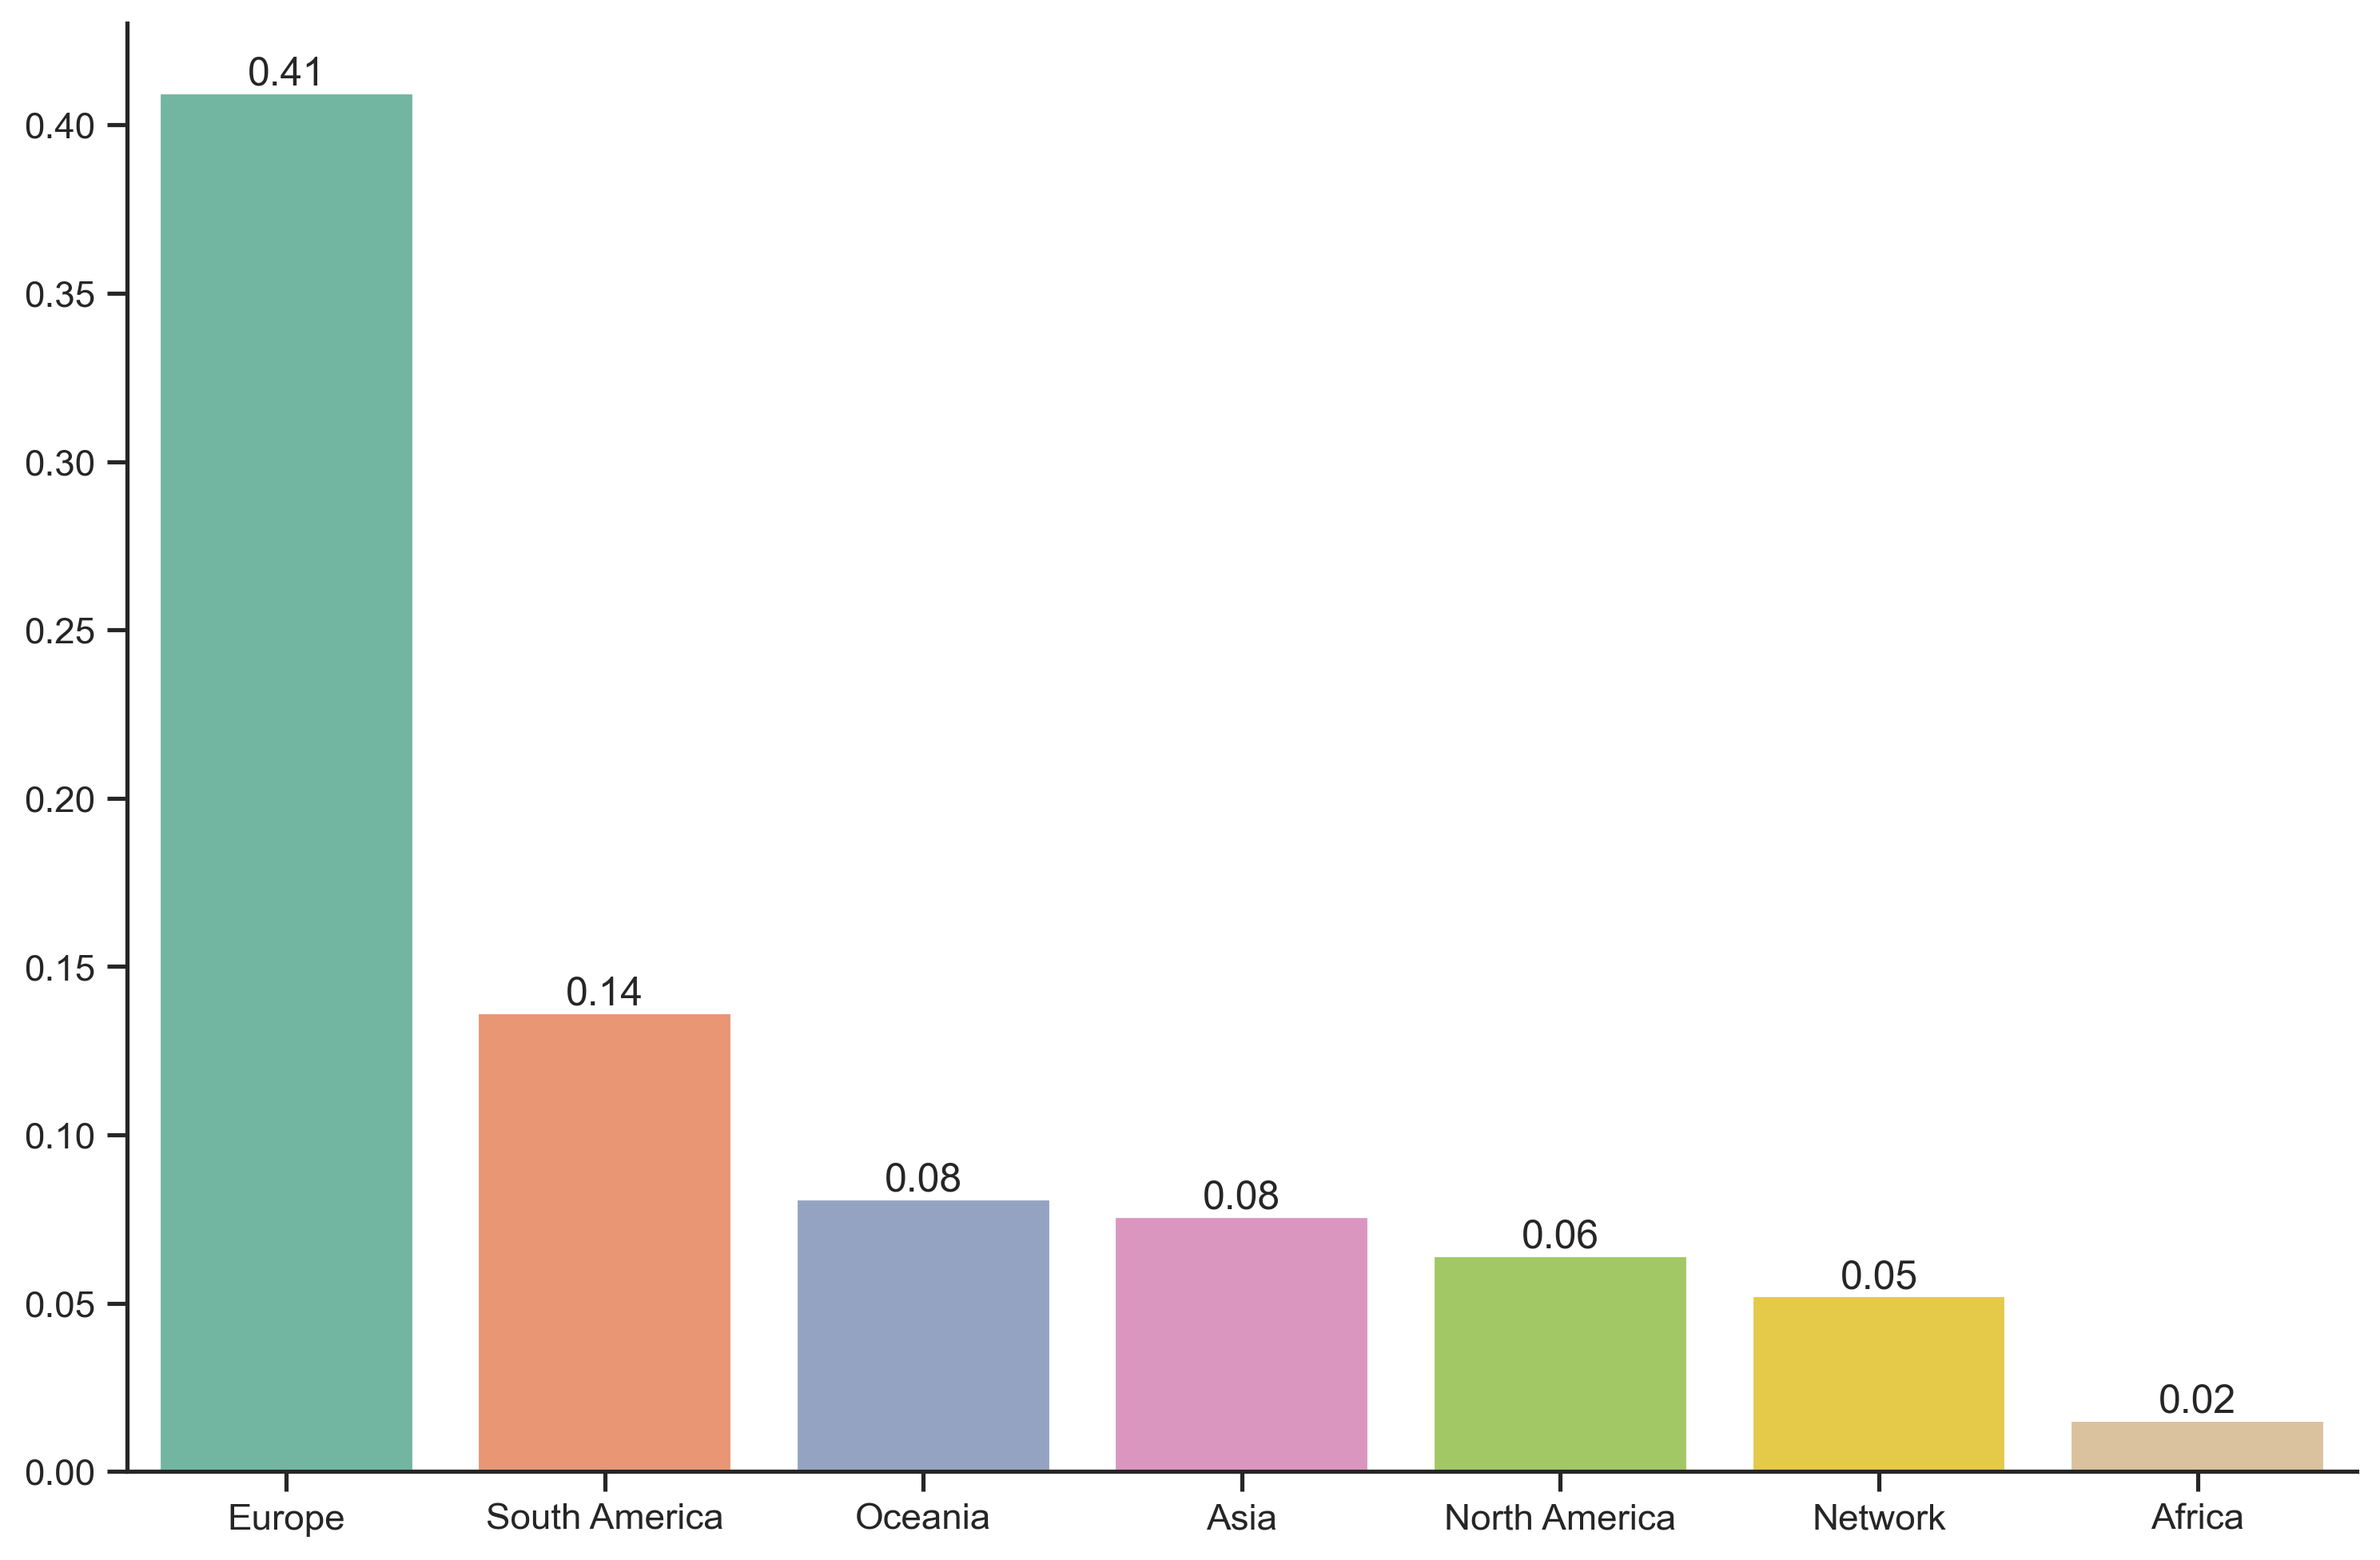

In [38]:
dens['Network'] = nx.density(G)
dens = pd.Series(dens)

#Plot
fig, ax = plt.subplots(figsize=(12,8), dpi=300)
sns.barplot(x=dens.index, y=dens.values, ax=ax, palette='Set2', 
            order=dens.sort_values(ascending=False).index)
ax.bar_label(ax.containers[0], fmt='%.2f')
sns.despine()
plt.show()

This suggests that we are mainly in presence of a regional kind of trade, where countries tends to import from other countries from the same macro-region (intra-region density is higher than network density). 

In [11]:
#Africa: nr of in/out going links
africa_in = dta.SourceZone[dta.TargetZone=='Africa'].value_counts(ascending=False).reset_index()
africa_out = dta.TargetZone[dta.SourceZone=='Africa'].value_counts(ascending=False).reset_index()
w_africa_in = dta[['SourceZone', 'Weight']][dta.TargetZone=='Africa'].groupby('SourceZone').sum().sort_values('Weight', ascending=False).reset_index()
w_africa_out = dta[['TargetZone', 'Weight']][dta.SourceZone=='Africa'].groupby('TargetZone').sum().sort_values('Weight', ascending=False).reset_index()

#Asia: nr of in/out going links
asia_in = dta.SourceZone[dta.TargetZone=='Asia'].value_counts(ascending=False).reset_index()
asia_out = dta.TargetZone[dta.SourceZone=='Asia'].value_counts(ascending=False).reset_index()
w_asia_in = dta[['SourceZone', 'Weight']][dta.TargetZone=='Asia'].groupby('SourceZone').sum().sort_values('Weight', ascending=False).reset_index()
w_asia_out = dta[['TargetZone', 'Weight']][dta.SourceZone=='Asia'].groupby('TargetZone').sum().sort_values('Weight', ascending=False).reset_index()

#Europe: nr of in/out going links
europe_in = dta.SourceZone[dta.TargetZone=='Europe'].value_counts(ascending=False).reset_index()
europe_out = dta.TargetZone[dta.SourceZone=='Europe'].value_counts(ascending=False).reset_index()
w_europe_in = dta[['SourceZone', 'Weight']][dta.TargetZone=='Europe'].groupby('SourceZone').sum().sort_values('Weight', ascending=False).reset_index()
w_europe_out = dta[['TargetZone', 'Weight']][dta.SourceZone=='Europe'].groupby('TargetZone').sum().sort_values('Weight', ascending=False).reset_index()

#North America: nr of in/out going links
na_in = dta.SourceZone[dta.TargetZone=='North America'].value_counts(ascending=False).reset_index()
na_out = dta.TargetZone[dta.SourceZone=='North America'].value_counts(ascending=False).reset_index()
w_na_in = dta[['SourceZone', 'Weight']][dta.TargetZone=='North America'].groupby('SourceZone').sum().sort_values('Weight', ascending=False).reset_index()
w_na_out = dta[['TargetZone', 'Weight']][dta.SourceZone=='North America'].groupby('TargetZone').sum().sort_values('Weight', ascending=False).reset_index()

#Oceania: nr of in/out going links
oceania_in = dta.SourceZone[dta.TargetZone=='Oceania'].value_counts(ascending=False).reset_index()
oceania_out = dta.TargetZone[dta.SourceZone=='Oceania'].value_counts(ascending=False).reset_index()
w_oceania_in = dta[['SourceZone', 'Weight']][dta.TargetZone=='Oceania'].groupby('SourceZone').sum().sort_values('Weight', ascending=False).reset_index()
w_oceania_out = dta[['TargetZone', 'Weight']][dta.SourceZone=='Oceania'].groupby('TargetZone').sum().sort_values('Weight', ascending=False).reset_index()

#South America: nr of in/out going links
sa_in = dta.SourceZone[dta.TargetZone=='South America'].value_counts(ascending=False).reset_index()
sa_out = dta.TargetZone[dta.SourceZone=='South America'].value_counts(ascending=False).reset_index()
w_sa_in = dta[['SourceZone', 'Weight']][dta.TargetZone=='South America'].groupby('SourceZone').sum().sort_values('Weight', ascending=False).reset_index()
w_sa_out = dta[['TargetZone', 'Weight']][dta.SourceZone=='South America'].groupby('TargetZone').sum().sort_values('Weight', ascending=False).reset_index()

In [12]:
#indegree
asia_in['TargetZone'] = 'Asia'
africa_in['TargetZone'] = 'Africa'
sa_in['TargetZone'] = 'South America'
oceania_in['TargetZone'] = 'Oceania'
europe_in['TargetZone'] = 'Europe'
na_in['TargetZone'] = 'North America'

#outdegree
asia_out['SourceZone'] = 'Asia'
africa_out['SourceZone'] = 'Africa'
sa_out['SourceZone'] = 'South America'
oceania_out['SourceZone'] = 'Oceania'
europe_out['SourceZone'] = 'Europe'
na_out['SourceZone'] = 'North America'

#weighted indegree
w_asia_in['TargetZone'] = 'Asia'
w_africa_in['TargetZone'] = 'Africa'
w_sa_in['TargetZone'] = 'South America'
w_oceania_in['TargetZone'] = 'Oceania'
w_europe_in['TargetZone'] = 'Europe'
w_na_in['TargetZone'] = 'North America'

#weighted outdegree
w_asia_out['SourceZone'] = 'Asia'
w_africa_out['SourceZone'] = 'Africa'
w_sa_out['SourceZone'] = 'South America'
w_oceania_out['SourceZone'] = 'Oceania'
w_europe_out['SourceZone'] = 'Europe'
w_na_out['SourceZone'] = 'North America'

In [13]:
#Concatenate
zone_indegree = pd.concat([asia_in, africa_in, sa_in, oceania_in, europe_in, na_in])
zone_indegree.rename(columns={'index' : 'SourceZone', 'SourceZone' : 'Nr of connections'}, inplace=True)

zone_outdegree = pd.concat([asia_out, africa_out, sa_out, oceania_out, europe_out, na_out])
zone_outdegree.rename(columns={'index' : 'TargetZone', 'TargetZone' : 'Nr of connections'}, inplace=True)

zone_w_indegree = pd.concat([w_asia_in, w_africa_in, w_sa_in, w_oceania_in, w_europe_in, w_na_in])

zone_w_outdegree = pd.concat([w_asia_out, w_africa_out, w_sa_out, w_oceania_out, w_europe_out, w_na_out])

In [14]:
#How much each zone exports
zone_w_indegree[zone_w_indegree['SourceZone'] != zone_w_indegree['TargetZone']].groupby('SourceZone').sum().reset_index().sort_values(by='Weight', ascending=False)

SourceZone        Weight
3  North America  1.038319e+07
2         Europe  8.050366e+06
1           Asia  3.295749e+06
4        Oceania  2.429245e+06
5  South America  1.145550e+06
0         Africa  2.102380e+02

In [15]:
#How much each zone imports
zone_w_outdegree[zone_w_outdegree['SourceZone'] != zone_w_outdegree['TargetZone']].groupby('TargetZone').sum().reset_index().sort_values(by='Weight', ascending=False)

TargetZone        Weight
1           Asia  1.291717e+07
0         Africa  9.283077e+06
5  South America  1.517766e+06
2         Europe  1.070220e+06
4        Oceania  2.743198e+05
3  North America  2.417634e+05

In [16]:
#Most important edges
zone_w_indegree.sort_values('Weight', ascending = False).head()

SourceZone       Weight TargetZone
0         Europe  6594568.331     Europe
0  North America  5993762.465       Asia
1           Asia  4641741.258       Asia
0         Europe  4141570.288     Africa
2         Europe  3731112.614       Asia

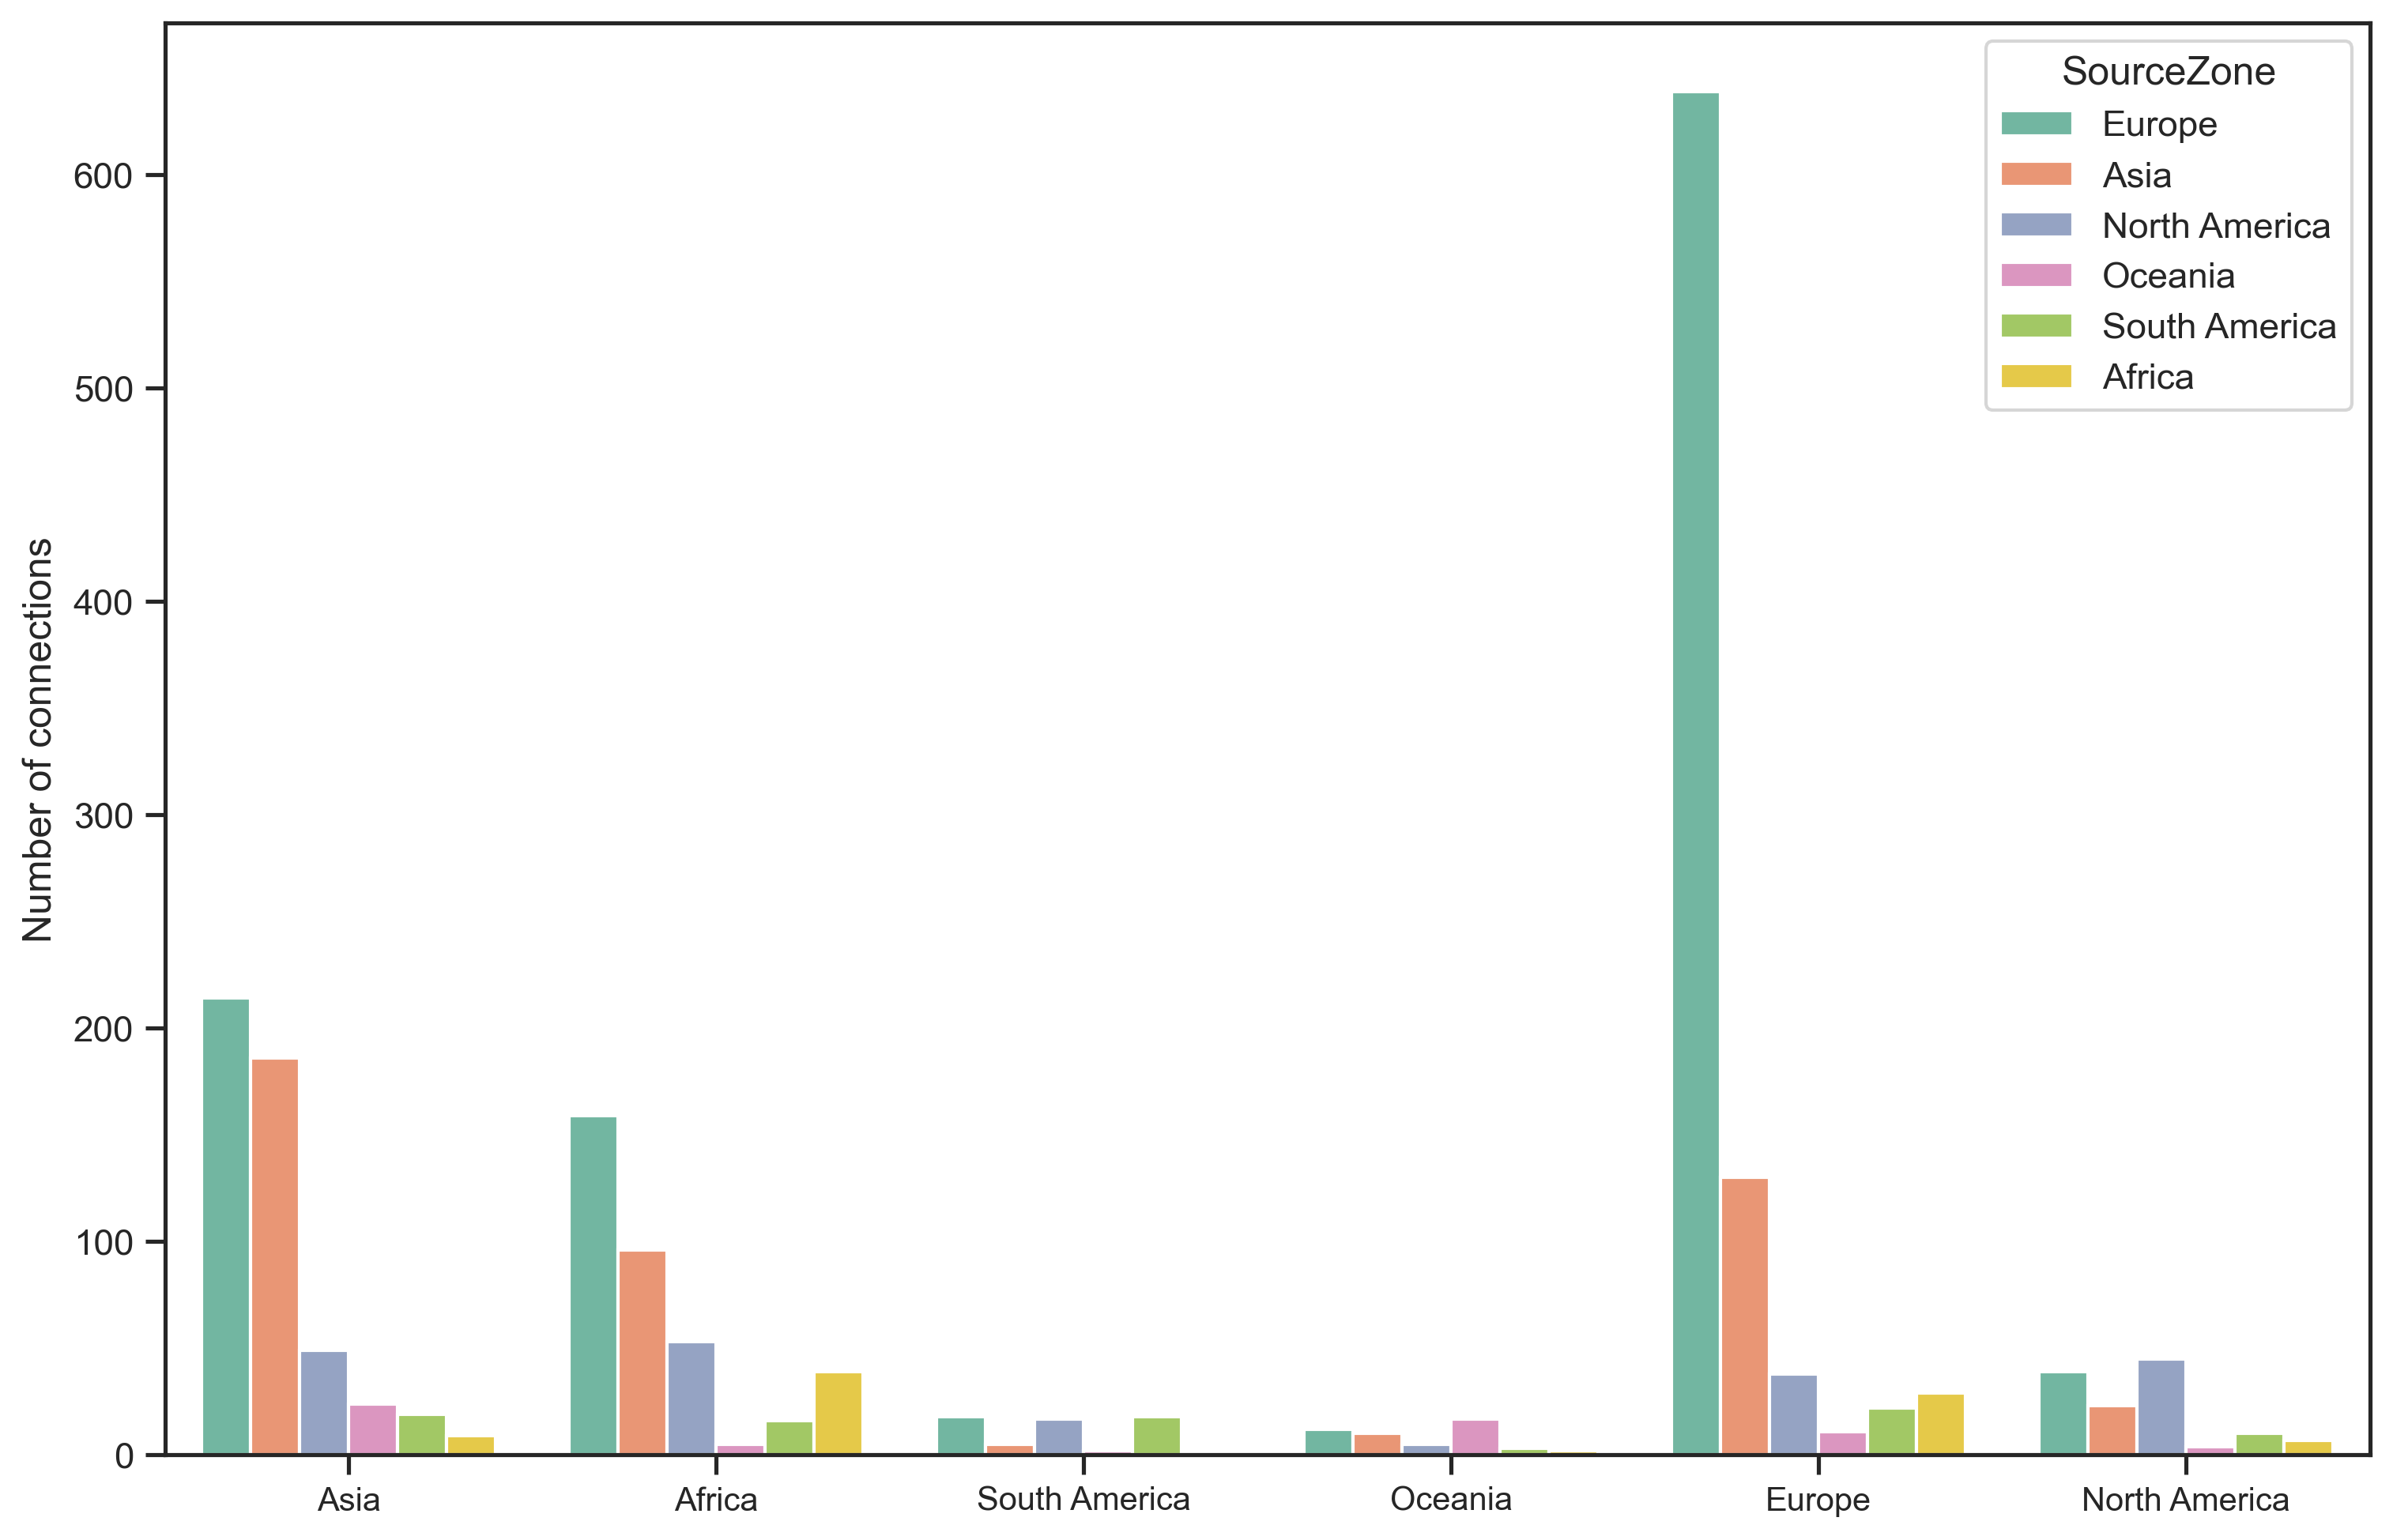

In [15]:
#From where each zone (horiz axis) imports wheat (in terms of number of connections)
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='TargetZone', y='Nr of connections', hue='SourceZone', data=zone_indegree, palette='Set2', ax=ax)
ax.tick_params(axis='x', labelsize=10)
ax.set_xlabel('')
ax.set_ylabel('Number of connections')
plt.show()

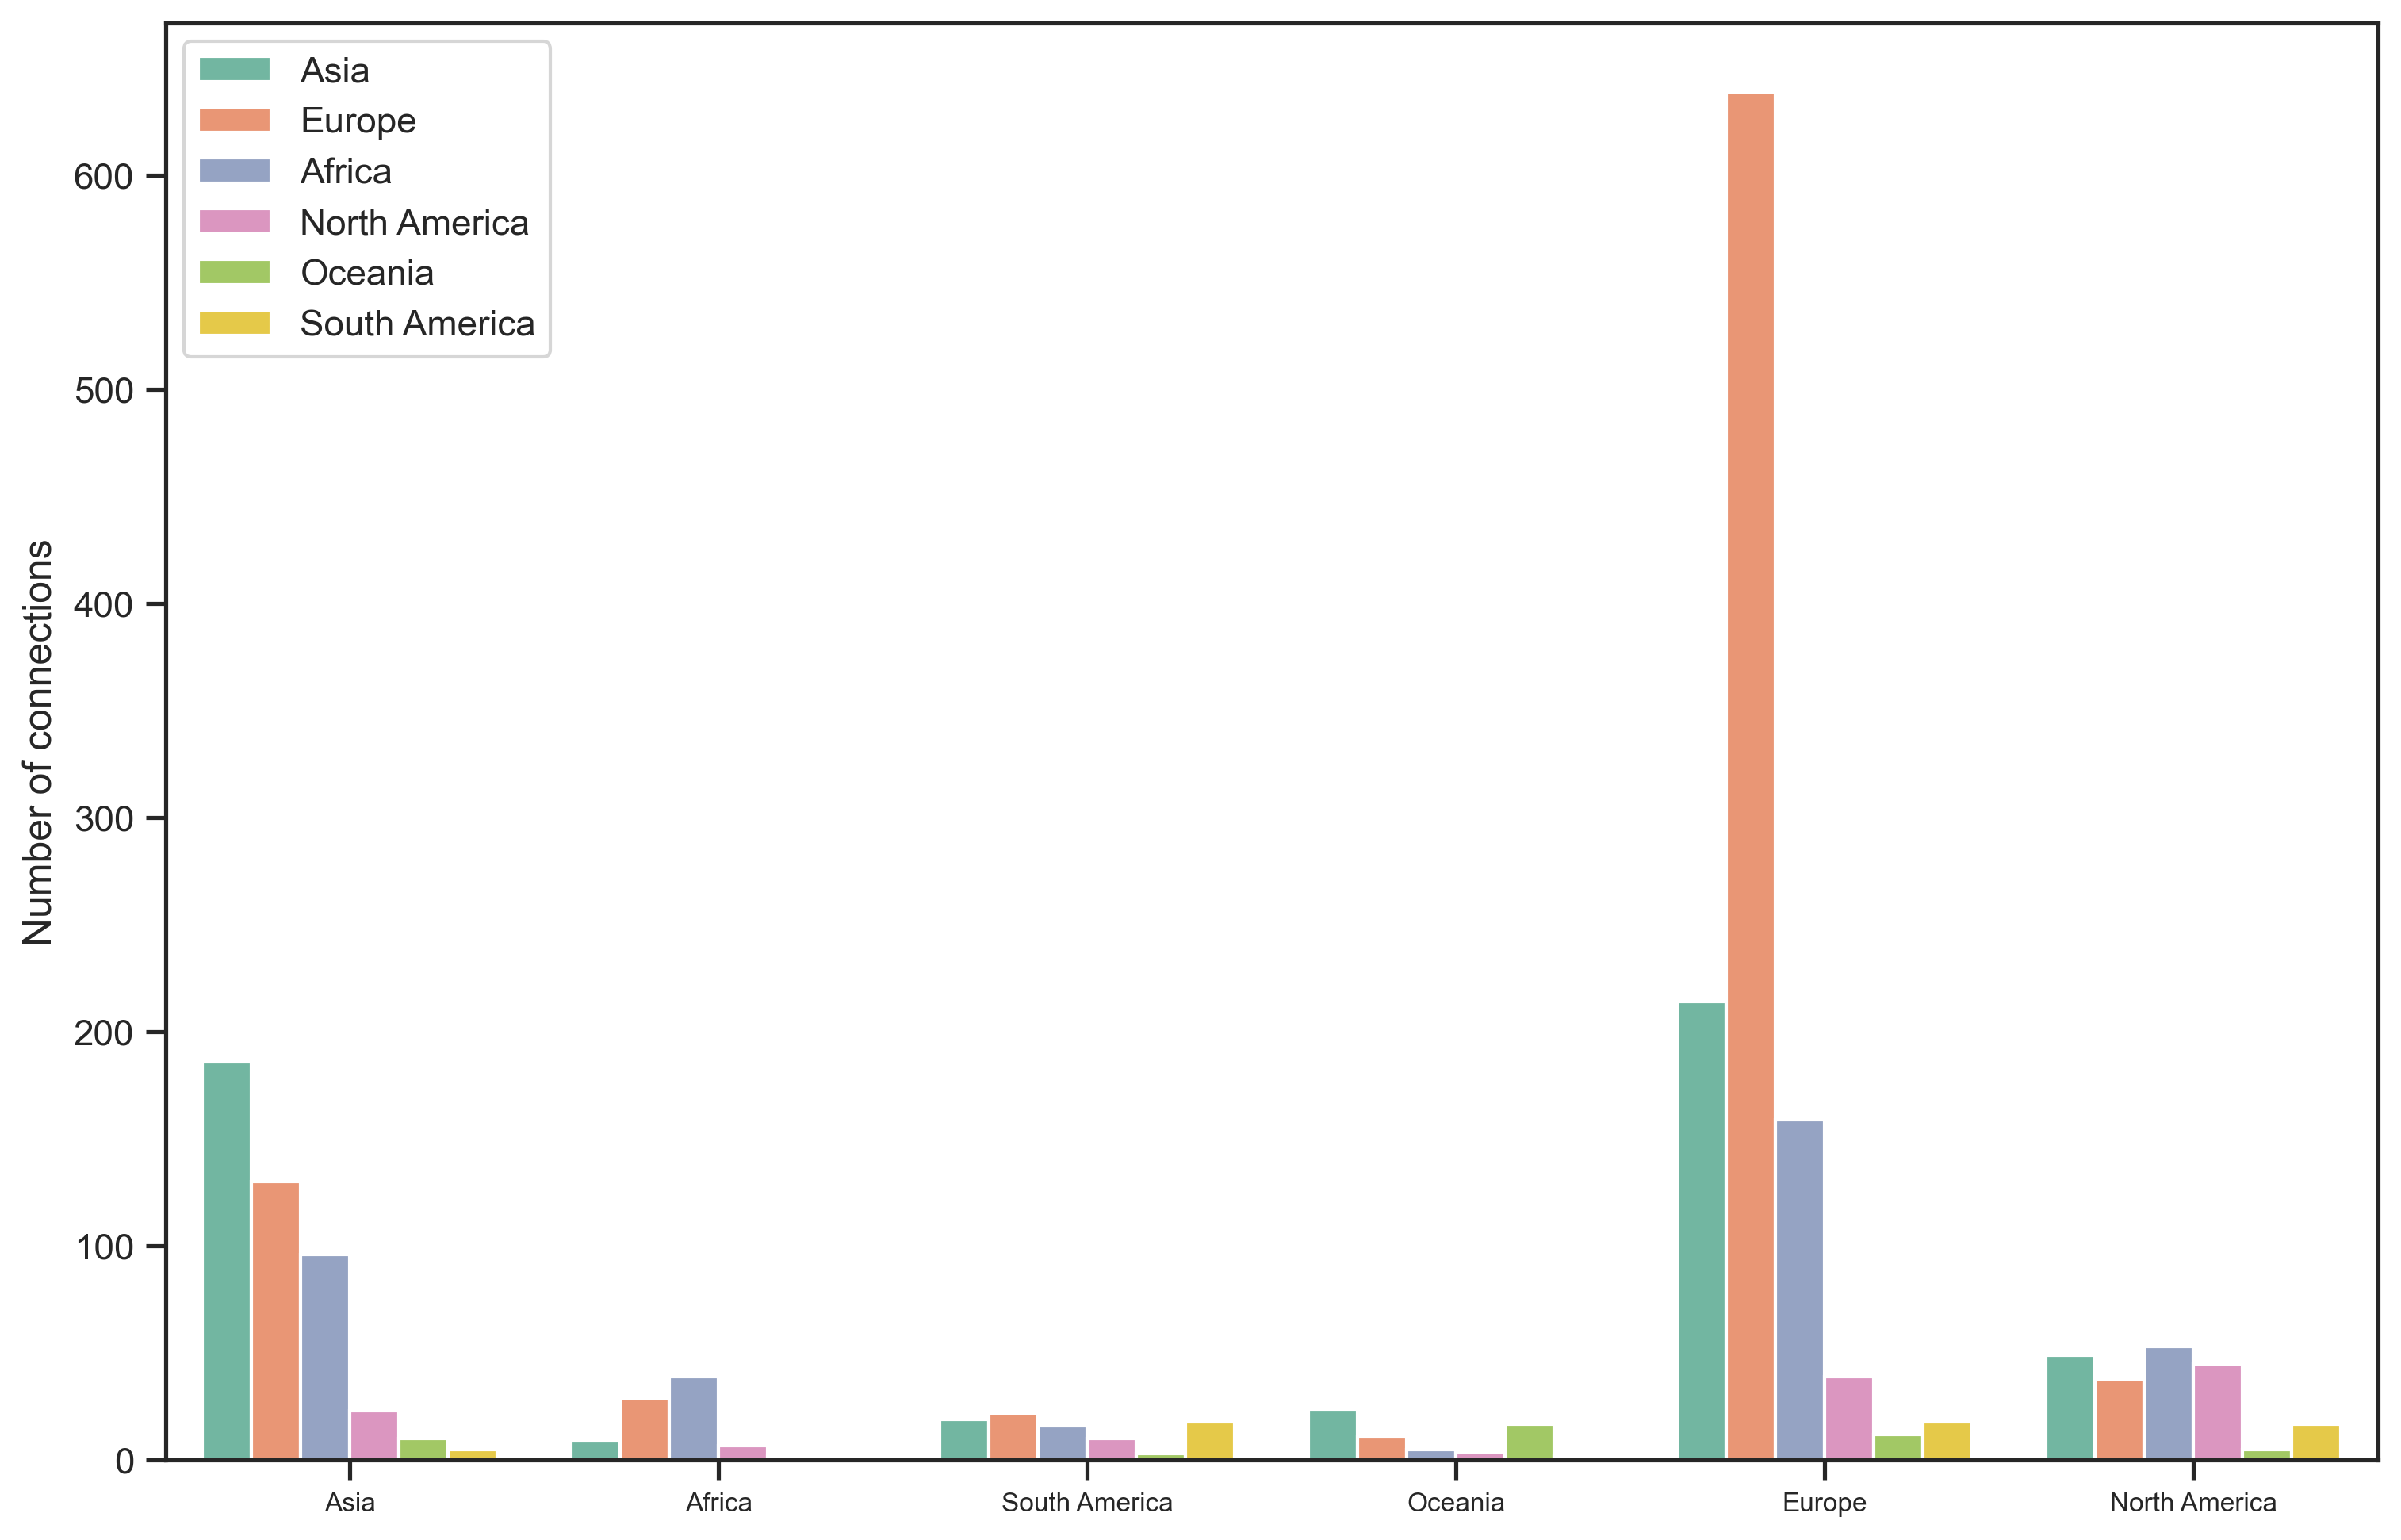

In [16]:
#To which zone each zone (horiz axis) exports wheat (in terms of connections)
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='SourceZone', y='Nr of connections', hue='TargetZone', data=zone_outdegree, palette='Set2', ax=ax)
ax.tick_params(axis='x', labelsize=8)
ax.set_xlabel('')
ax.set_ylabel('Number of connections')
plt.legend(loc = 'upper left')
plt.show()

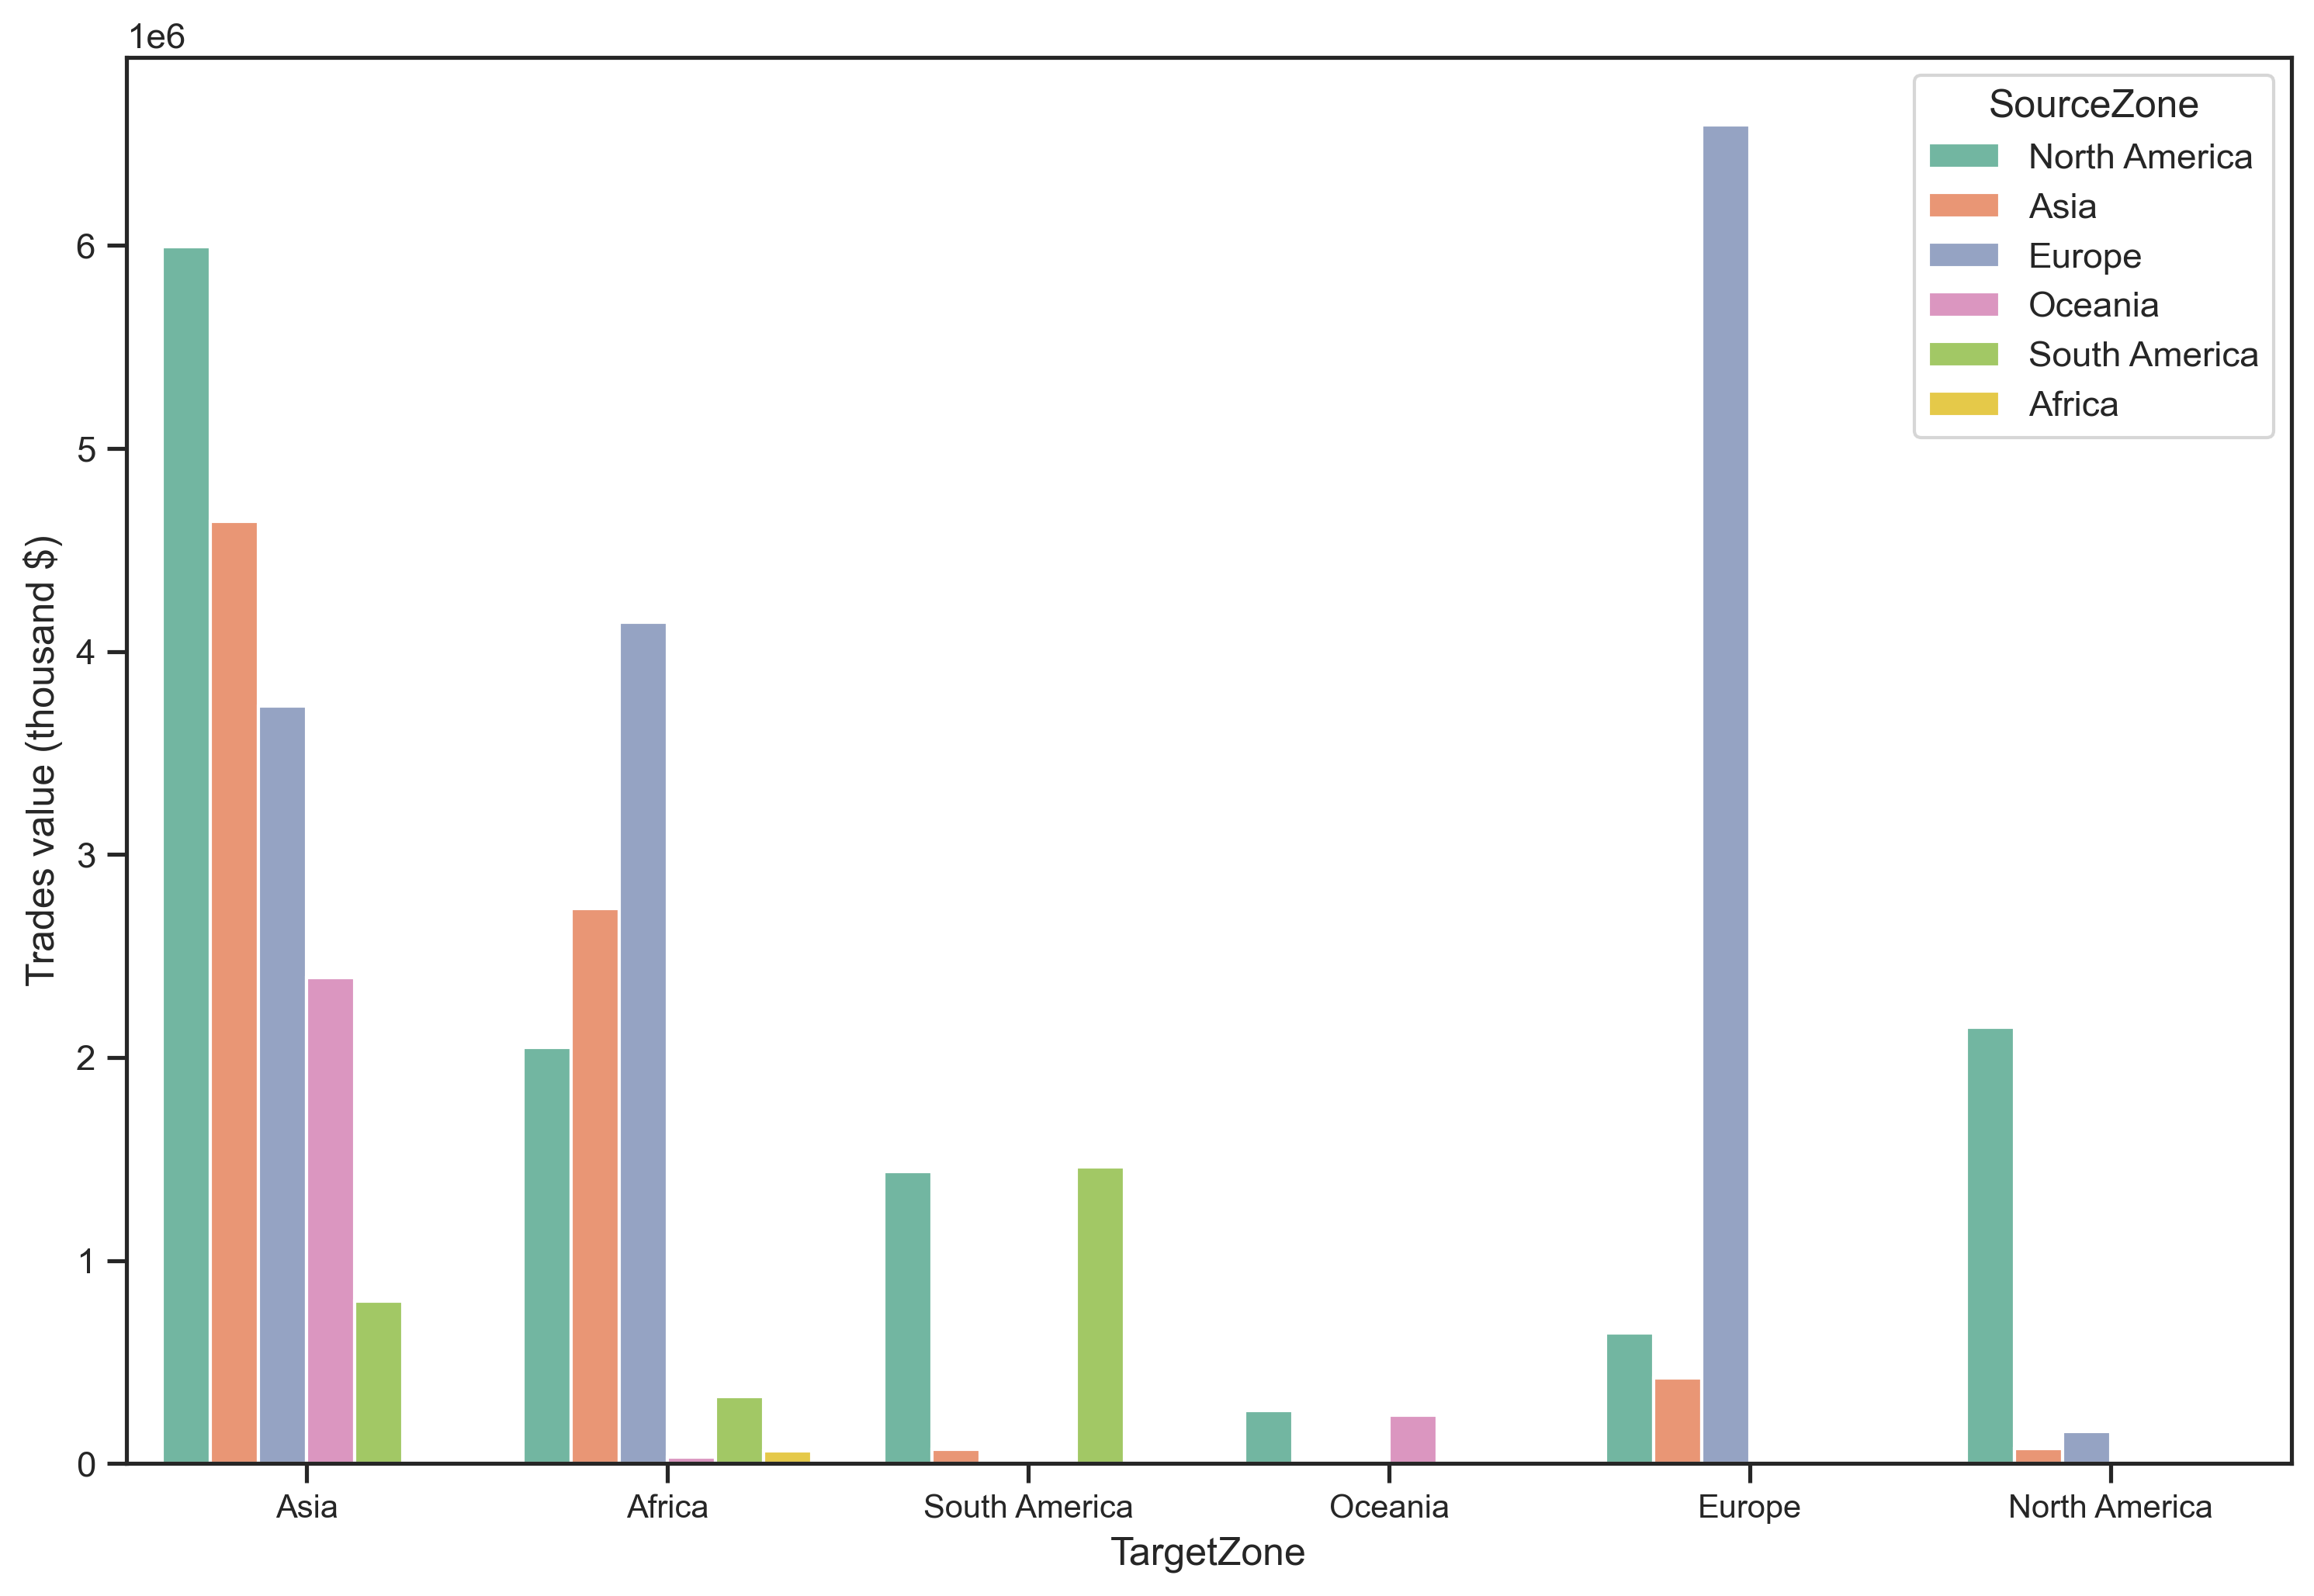

In [31]:
#From where each zone (horiz axis) imports wheat (in terms of number of wealth)
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='TargetZone', y='Weight', hue='SourceZone', data=zone_w_indegree, palette='Set2', ax=ax)
ax.tick_params(axis='x', labelsize=10)
ax.set_ylabel('Trades value (thousand $)')
plt.show()

* Asian countries import primarily from North America and other Asian countries 
* African countries import primarily from Europe and Asia, only secondly from North America.
* South America is imports primarily from North America and South America
* Oceania from Oceania and North America (interestingly not from Asia, which is nearer)
* Europe basically only from Europe
* North America basically only from North America

Interesting to notice that Africa does not import from other African countries, as opposed to North America and Europe. 

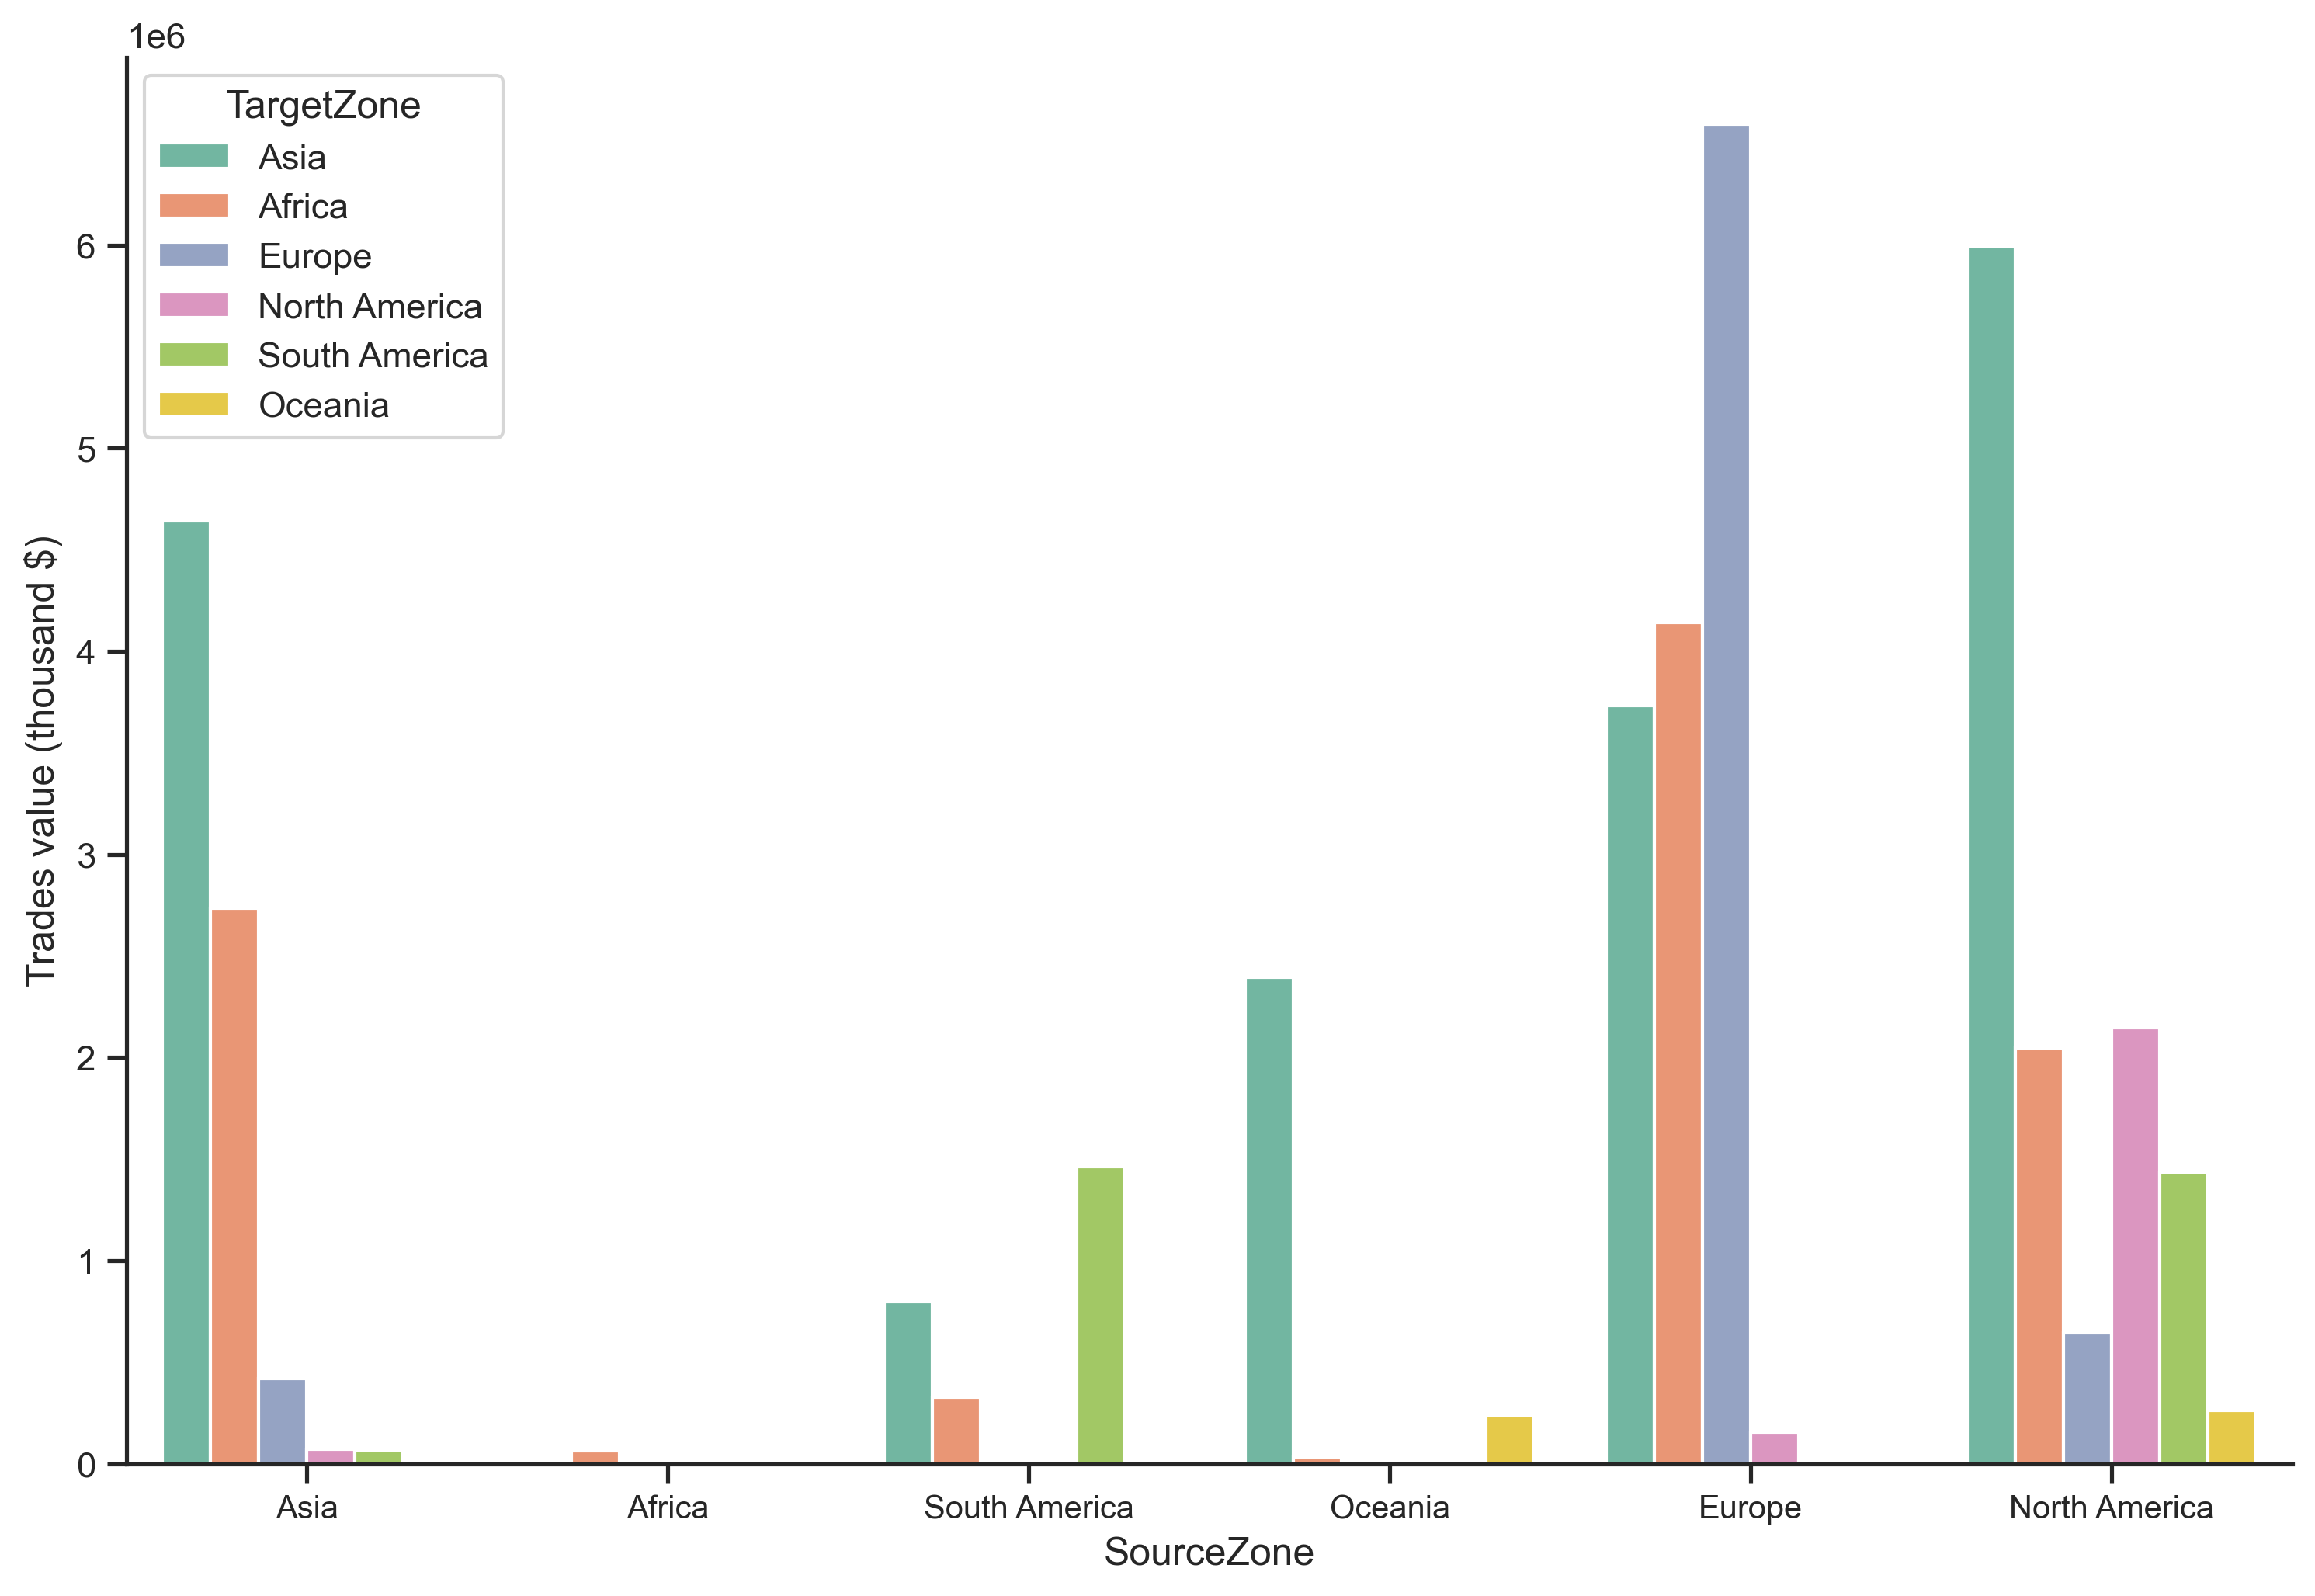

In [18]:
#To which zone each zone (horiz axis) exports wheat (in terms of connections)
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='SourceZone', y='Weight', hue='TargetZone', data=zone_w_outdegree, palette='Set2', ax=ax)
ax.tick_params(axis='x', labelsize=10)
sns.despine()
ax.set_ylabel('Trades value (thousand $)')
plt.legend(title='TargetZone', loc = 'upper left')
plt.show()

# Random graph

In [17]:
#create a random graph to compare the degree distribution
RG = nx.erdos_renyi_graph(n=G.number_of_nodes(), p=nx.density(G), seed=42, directed=True)
print('Number of links in the random graph:', RG.number_of_edges())

Number of links in the random graph: 1935


# Out degree

In [173]:
out_degree = pd.Series(dict(G.out_degree))
out_degree_values = list(out_degree.values)
RG_out_degree_values = list(dict(RG.out_degree).values())

print('Mean out-degree:', np.mean(out_degree_values))
print('Median out-degree:', np.median(out_degree_values)) 
print('Out-degree std dev:', np.std(out_degree_values))
print('Max out-degree:', np.max(out_degree_values))
print('Min out-degree:', np.min(out_degree_values))
#mean is much larger than the median; 
#std dev is also pretty high 
# -> scale-free network

Mean out-degree: 10.128205128205128
Median out-degree: 2.0
Out-degree std dev: 19.040011160279384
Max out-degree: 106
Min out-degree: 0


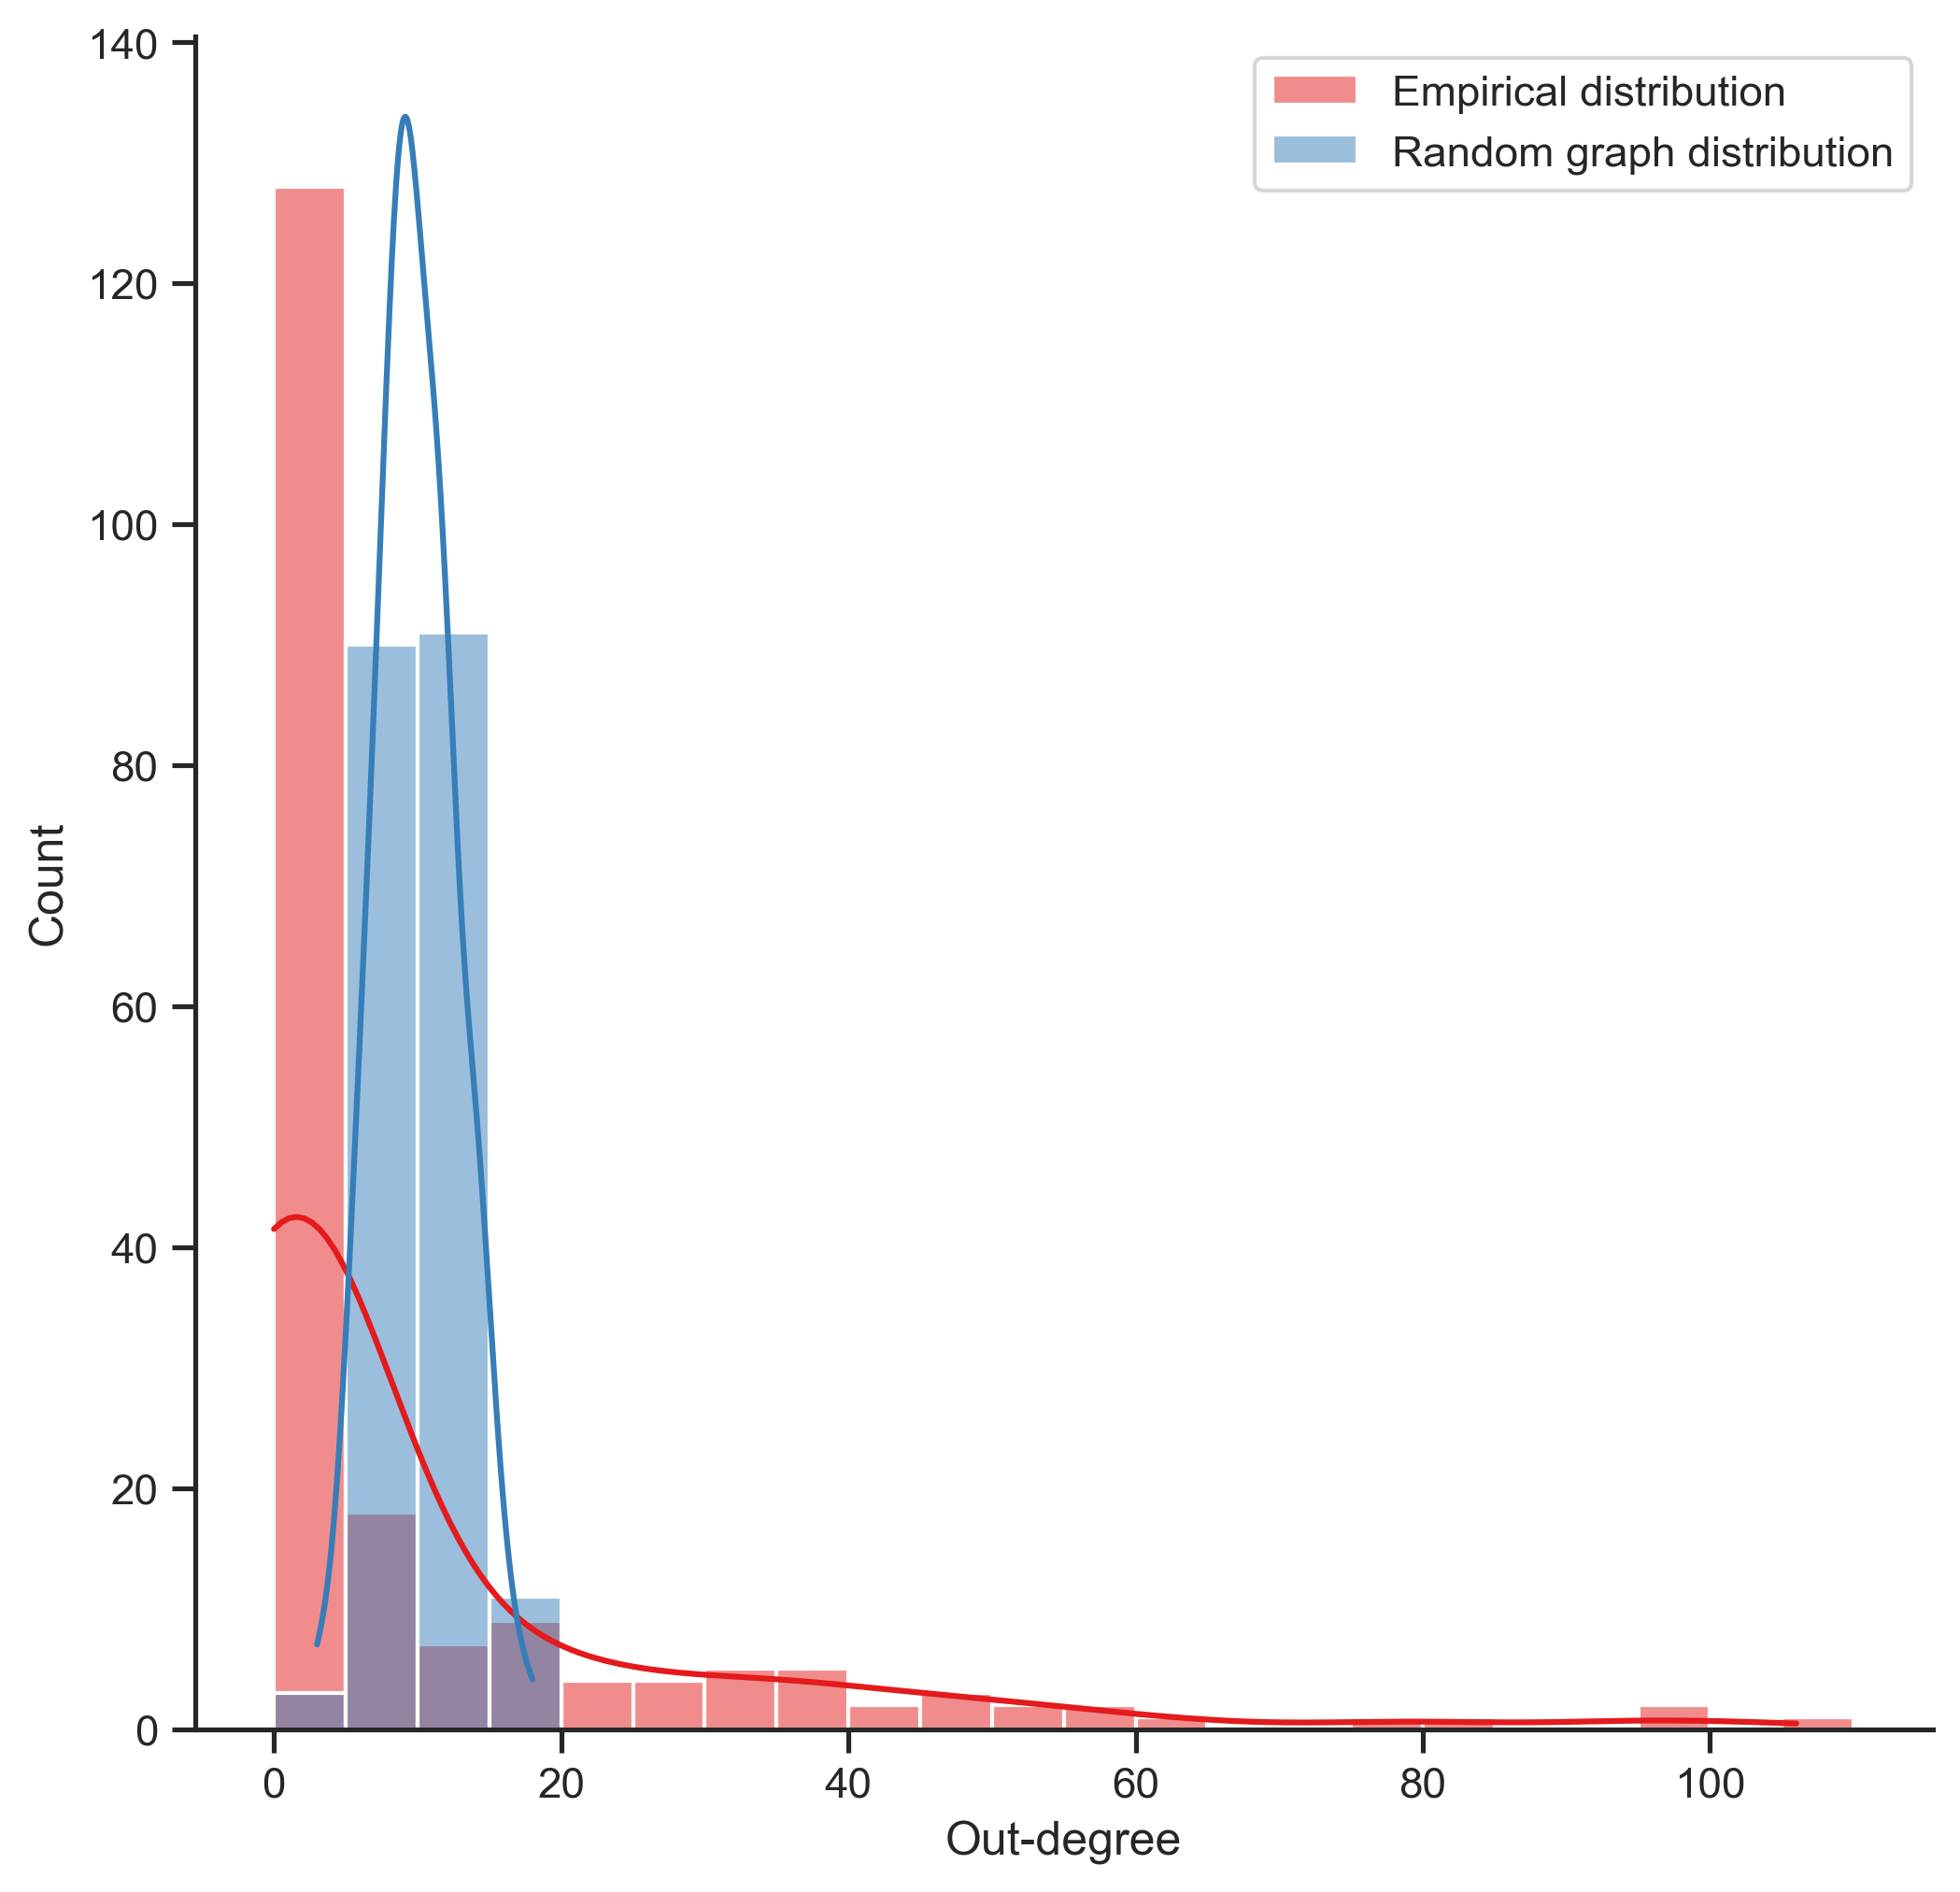

In [28]:
#distribution: random vs empirical
fig, ax = plt.subplots(figsize=(8,8),sharey=True)

#some parameters for the plot
M = max(out_degree_values)
binsize = np.arange(0, M+5, 5)

#Plot
sns.histplot(out_degree_values, bins=binsize, ax=ax, color='#e41a1c', alpha=0.5, kde=True, 
             label='Empirical distribution')
sns.histplot(RG_out_degree_values, bins=binsize, ax=ax, color='#377eb8', alpha=0.5, kde=True, 
            label='Random graph distribution')
plt.xlabel('Out-degree')
sns.despine()
plt.legend()
plt.show()

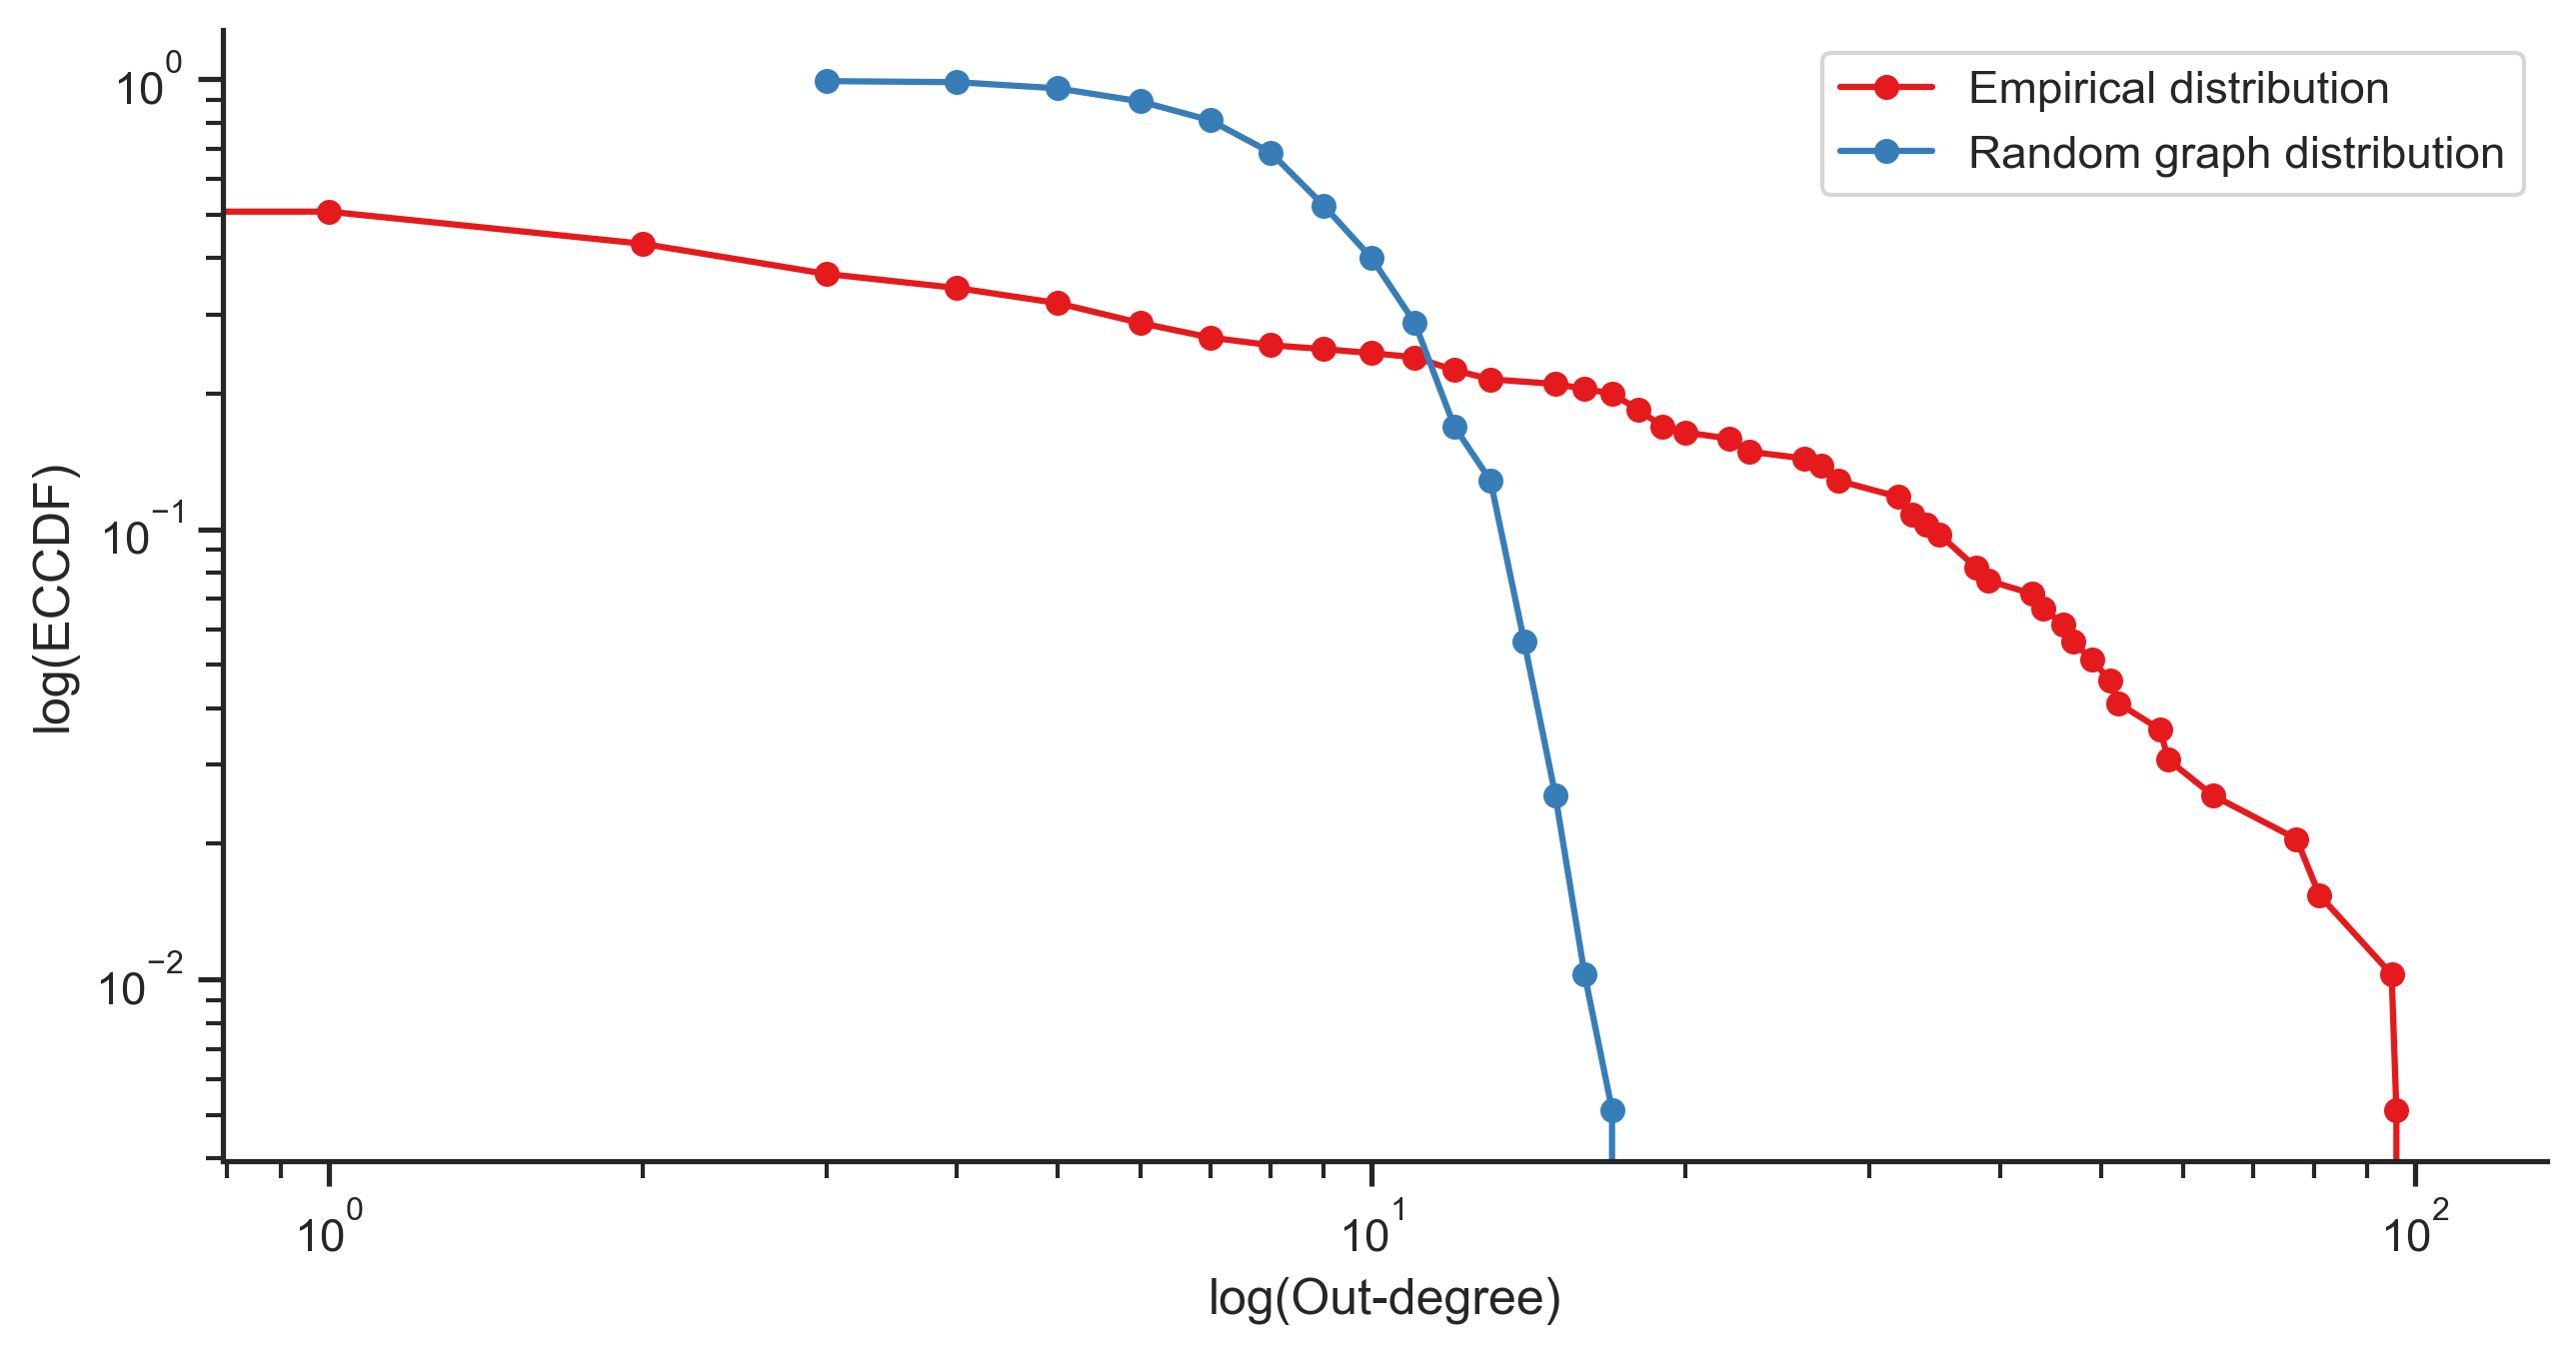

In [29]:
ecdf_real = ECDF(out_degree_values)
x_real = np.unique(out_degree_values)
y_real = ecdf_real(x_real)
ecdf_random = ECDF(RG_out_degree_values)
x_random = np.unique(RG_out_degree_values)
y_random = ecdf_random(x_random)
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.loglog(x_real,1-y_real,marker='o',ms=5, color='#e41a1c', 
          label='Empirical distribution')
ax.plot(x_random,1-y_random,marker='o',ms=5, color='#377eb8',
       label='Random graph distribution')
ax.set_xlabel('log(Out-degree)')
ax.set_ylabel('log(ECCDF)')
sns.despine()
plt.legend()
plt.show()

# In degree

In [19]:
in_degree = pd.Series(dict(G.in_degree))
in_degree_values = list(in_degree.values)
RG_in_degree_values = list(dict(RG.in_degree).values())

print('Mean in-degree:', np.mean(in_degree_values))
print('Median in-degree:', np.median(in_degree_values)) 
print('In-degree std dev:', np.std(in_degree_values))
print('Max in-degree:', np.max(in_degree_values))
print('Min in-degree:', np.min(in_degree_values))
#mean is double as the median; 
#std dev is also pretty high 
# -> scale-free network

Mean in-degree: 10.128205128205128
Median in-degree: 7.0
In-degree std dev: 9.91083190686471
Max in-degree: 46
Min in-degree: 0


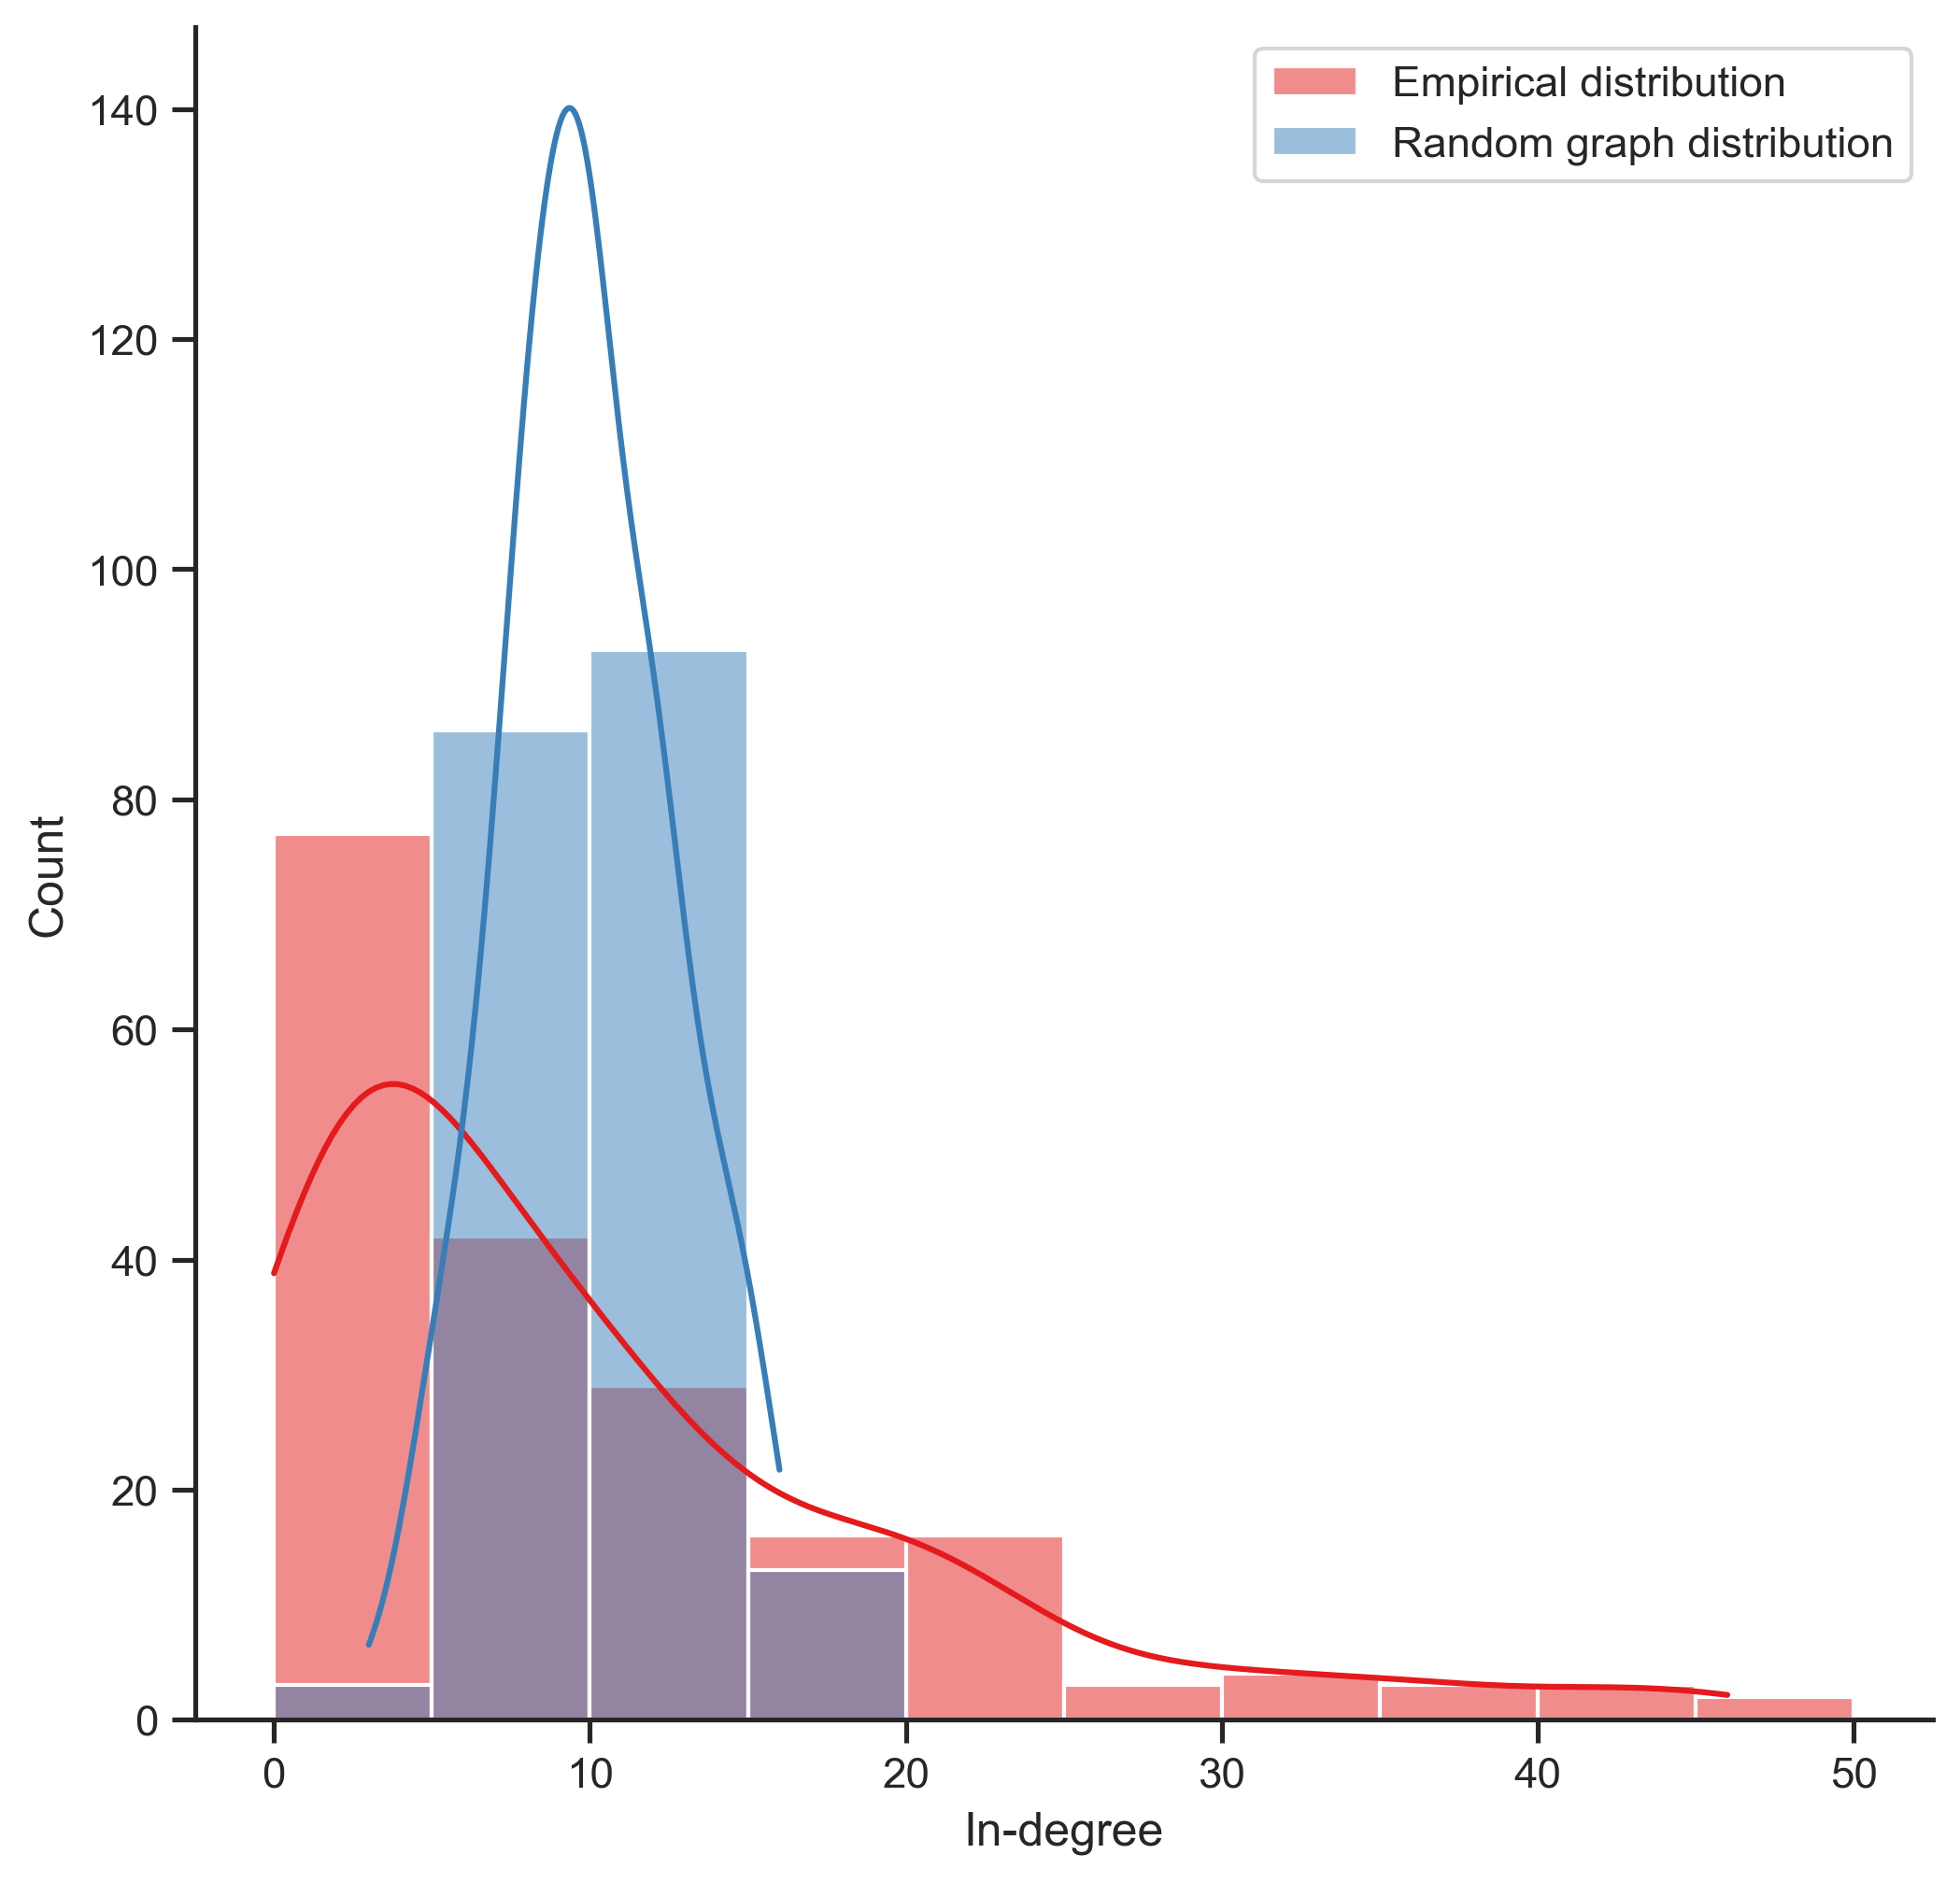

In [31]:
#distribution: random vs empirical
fig, ax = plt.subplots(figsize=(8,8),sharey=True)

#some parameters for the plot
M = max(in_degree_values)
binsize = np.arange(0, M+5, 5)

#Plot
sns.histplot(in_degree_values, bins=binsize, ax=ax, color='#e41a1c', alpha=0.5, kde=True, 
             label='Empirical distribution')
sns.histplot(RG_in_degree_values, bins=binsize, ax=ax, color='#377eb8', alpha=0.5, kde=True, 
            label='Random graph distribution')
plt.xlabel('In-degree')
sns.despine()
plt.legend()
plt.show()

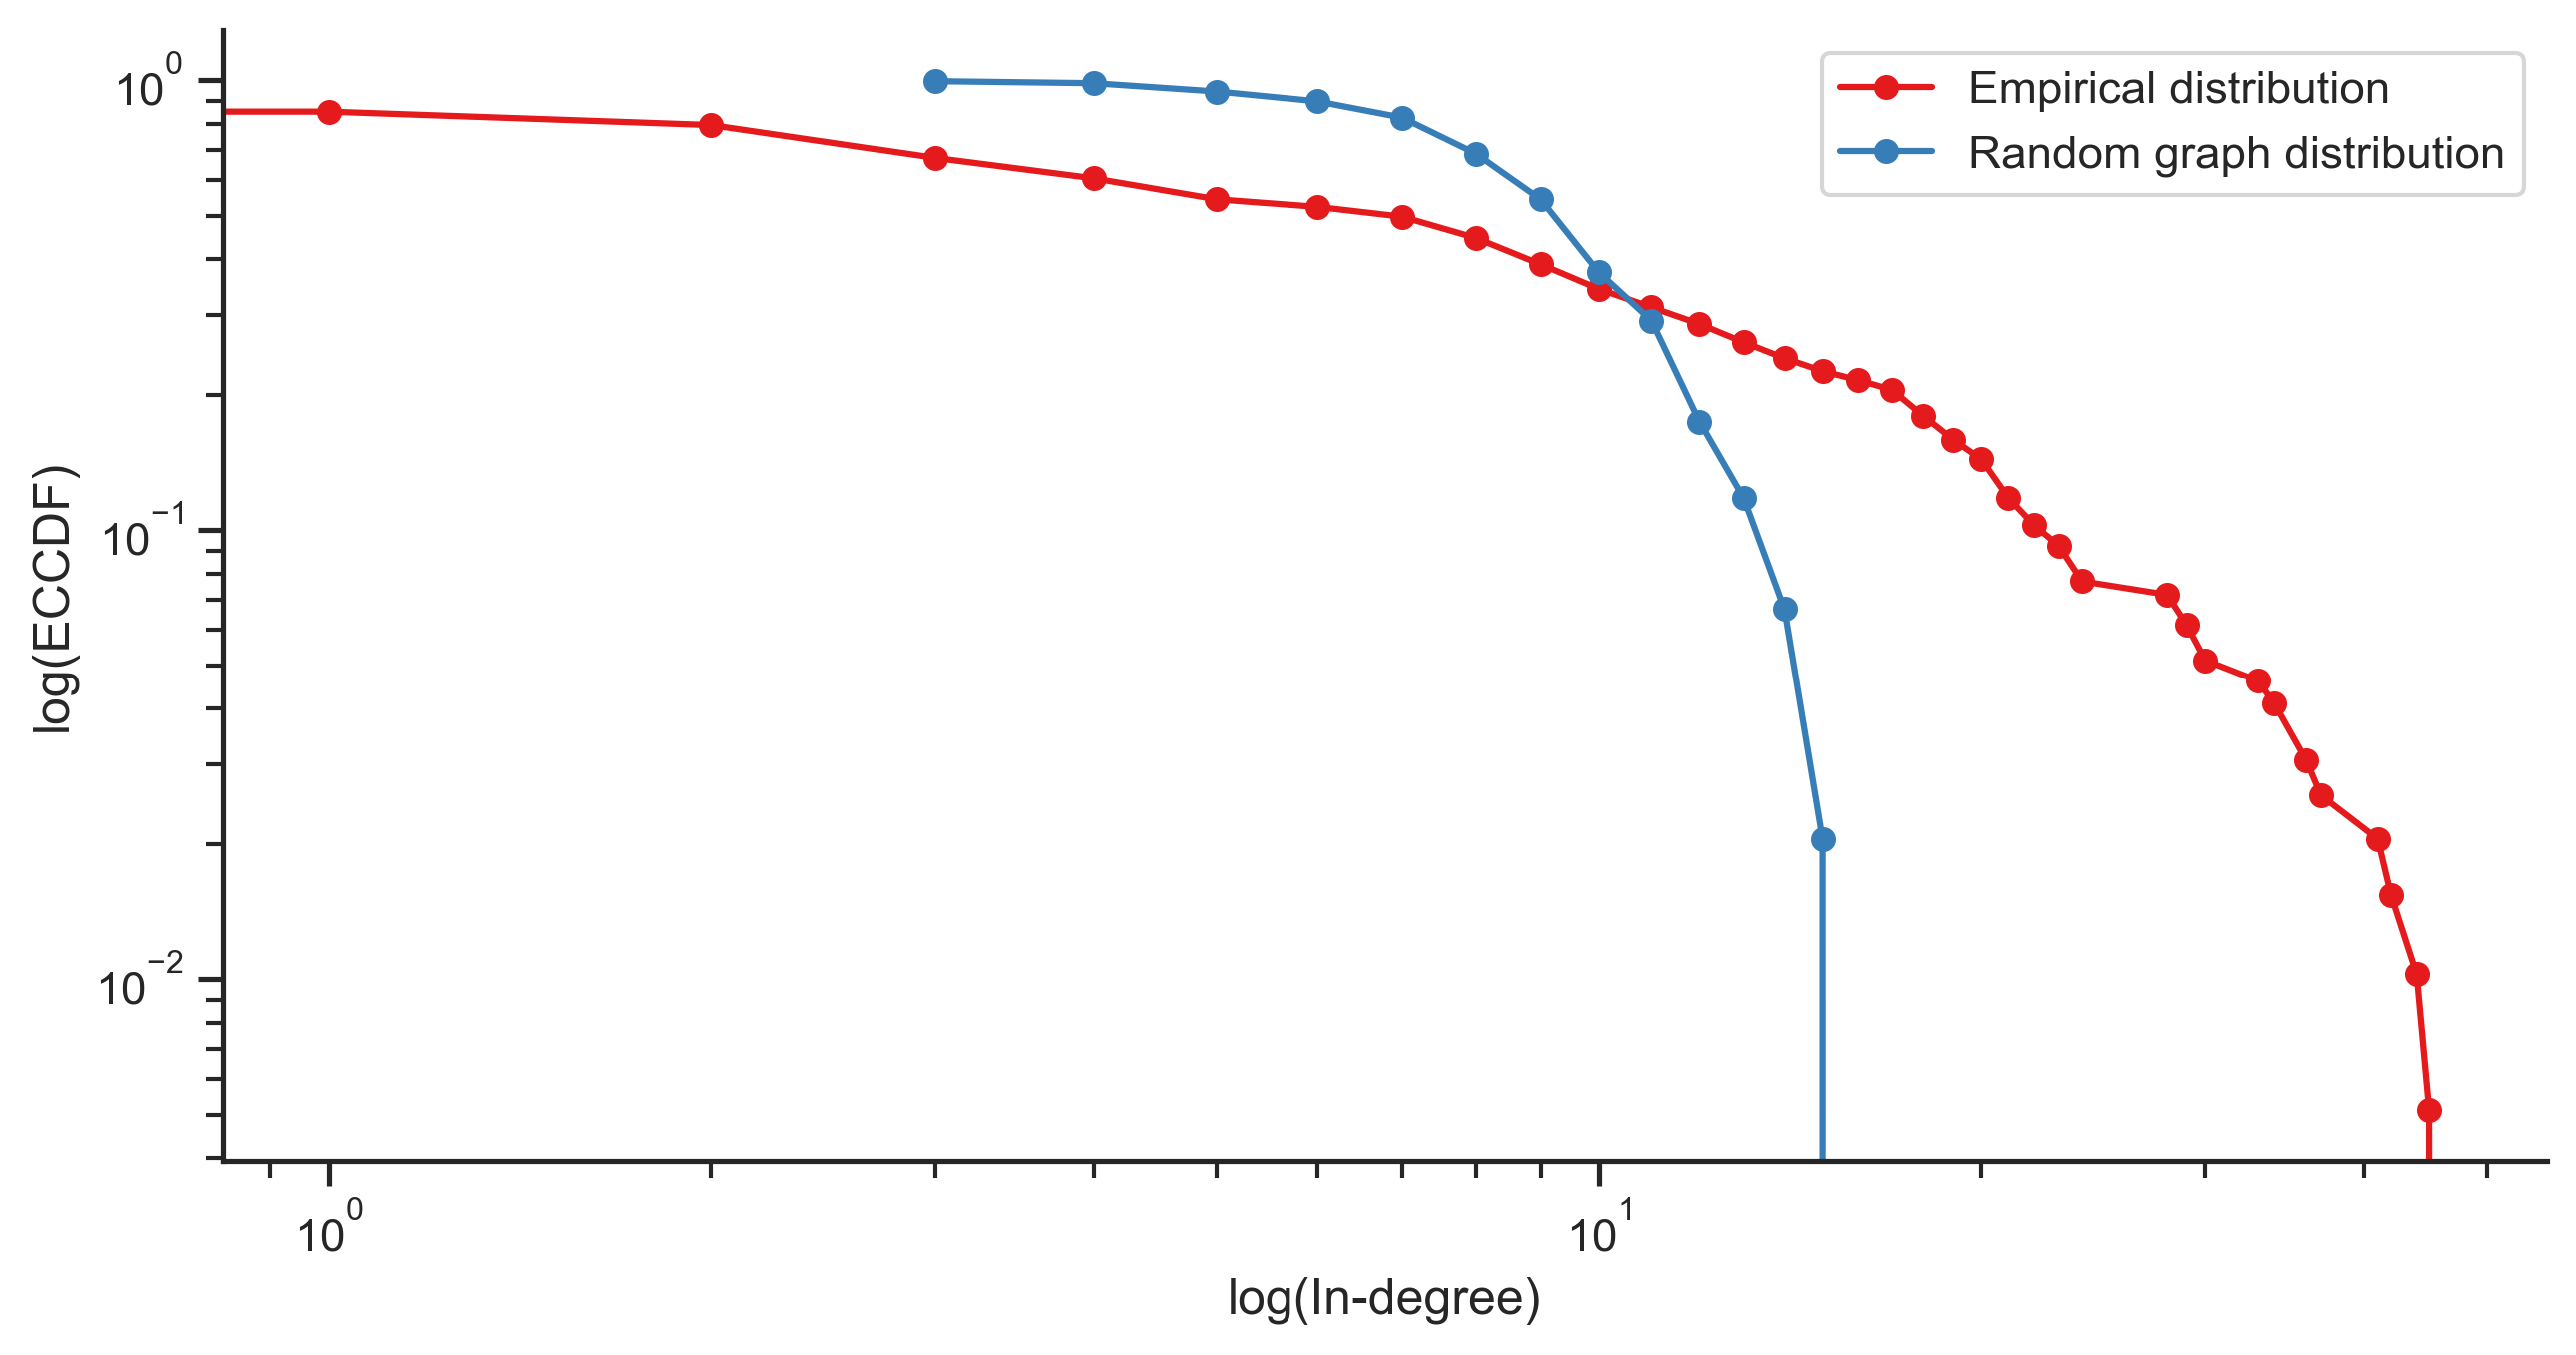

In [32]:
ecdf_real = ECDF(in_degree_values)
x_real = np.unique(in_degree_values)
y_real = ecdf_real(x_real)
ecdf_random = ECDF(RG_in_degree_values)
x_random = np.unique(RG_in_degree_values)
y_random = ecdf_random(x_random)
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.loglog(x_real,1-y_real,marker='o',ms=5, color='#e41a1c', 
          label='Empirical distribution')
ax.plot(x_random,1-y_random,marker='o',ms=5, color='#377eb8',
       label='Random graph distribution')
ax.set_xlabel('log(In-degree)')
ax.set_ylabel('log(ECCDF)')
sns.despine()
plt.legend()
plt.show()

# Total degree

In [20]:
degree = pd.Series(dict(G.degree))
degree_values = list(degree.values)
RG_degree_values = list(dict(RG.degree).values())

print('Mean degree:', np.mean(degree_values))
print('Median degree:', np.median(degree_values)) 
print('Degree std dev:', np.std(degree_values))
print('Max degree:', np.max(degree_values))
print('Min degree:', np.min(degree_values))

Mean degree: 20.256410256410255
Median degree: 9.0
Degree std dev: 27.124705314450743
Max degree: 140
Min degree: 1


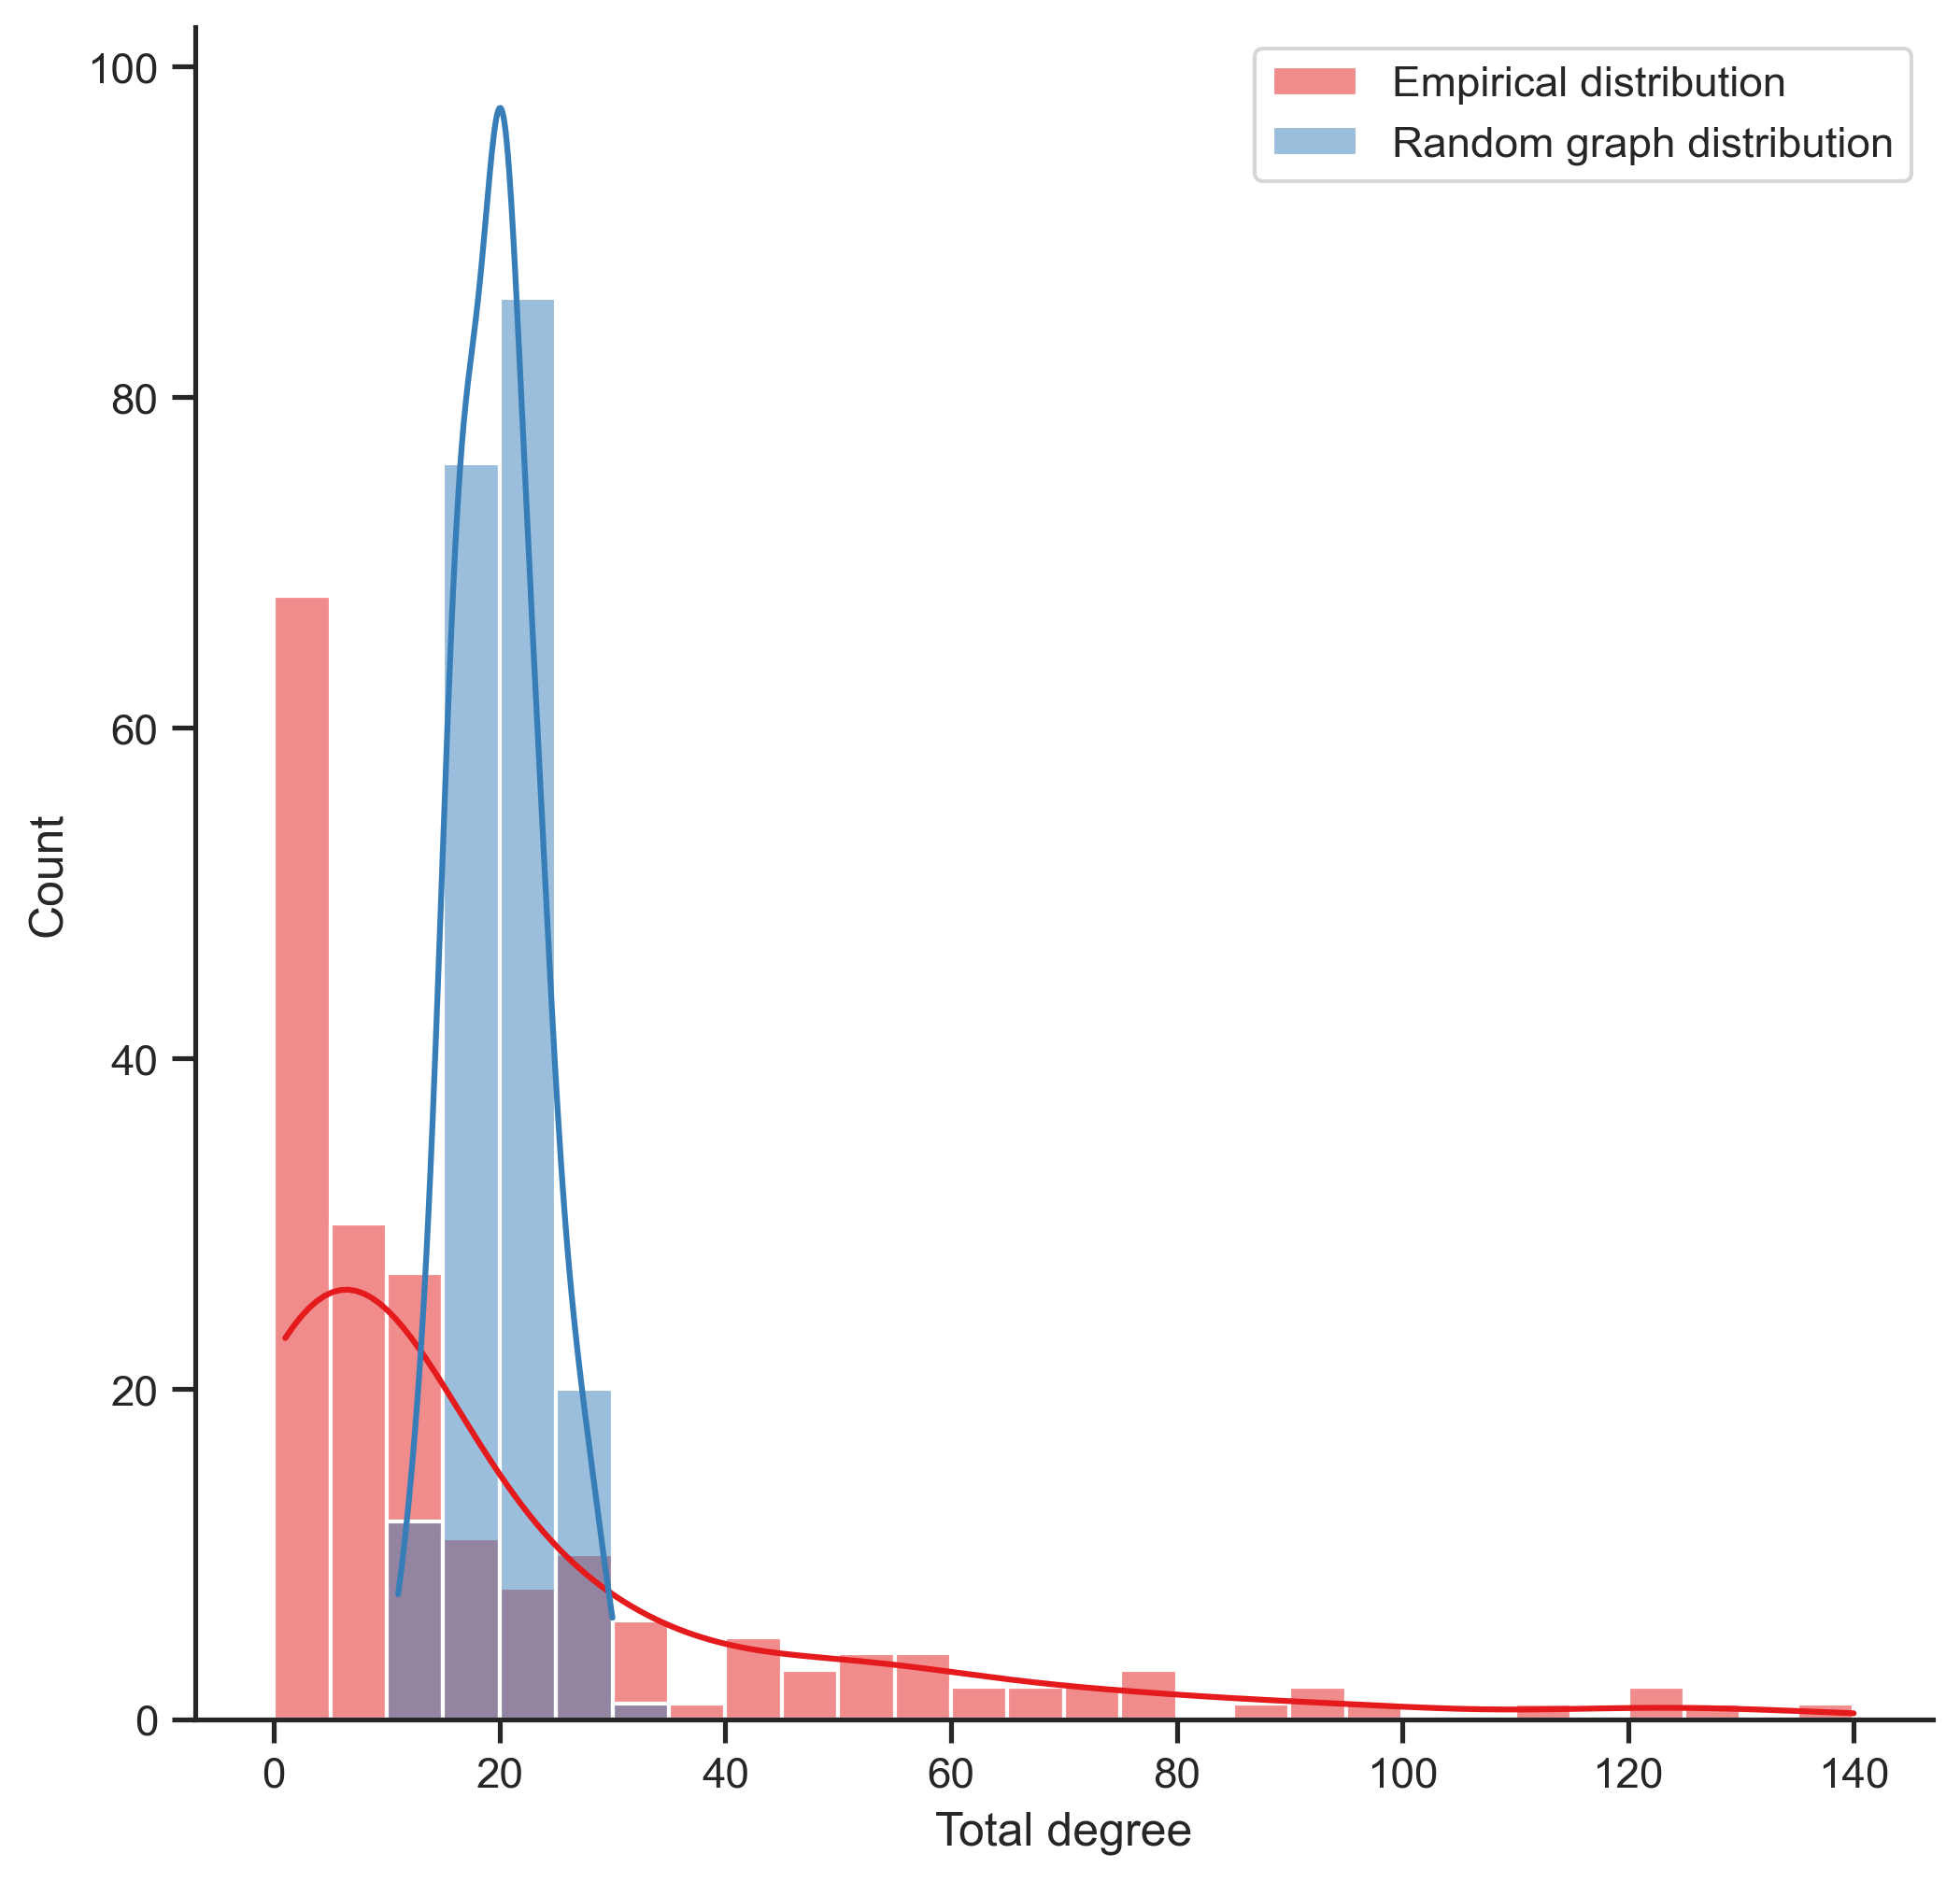

In [34]:
#distribution: random vs empirical
fig, ax = plt.subplots(figsize=(8,8),sharey=True)

#some parameters for the plot
M = max(degree_values)
binsize = np.arange(0, M+5, 5)

#Plot
sns.histplot(degree_values, bins=binsize, ax=ax, color='#e41a1c', alpha=0.5, kde=True, 
             label='Empirical distribution')
sns.histplot(RG_degree_values, bins=binsize, ax=ax, color='#377eb8', alpha=0.5, kde=True, 
            label='Random graph distribution')
plt.xlabel('Total degree')
sns.despine()
plt.legend()
plt.show()

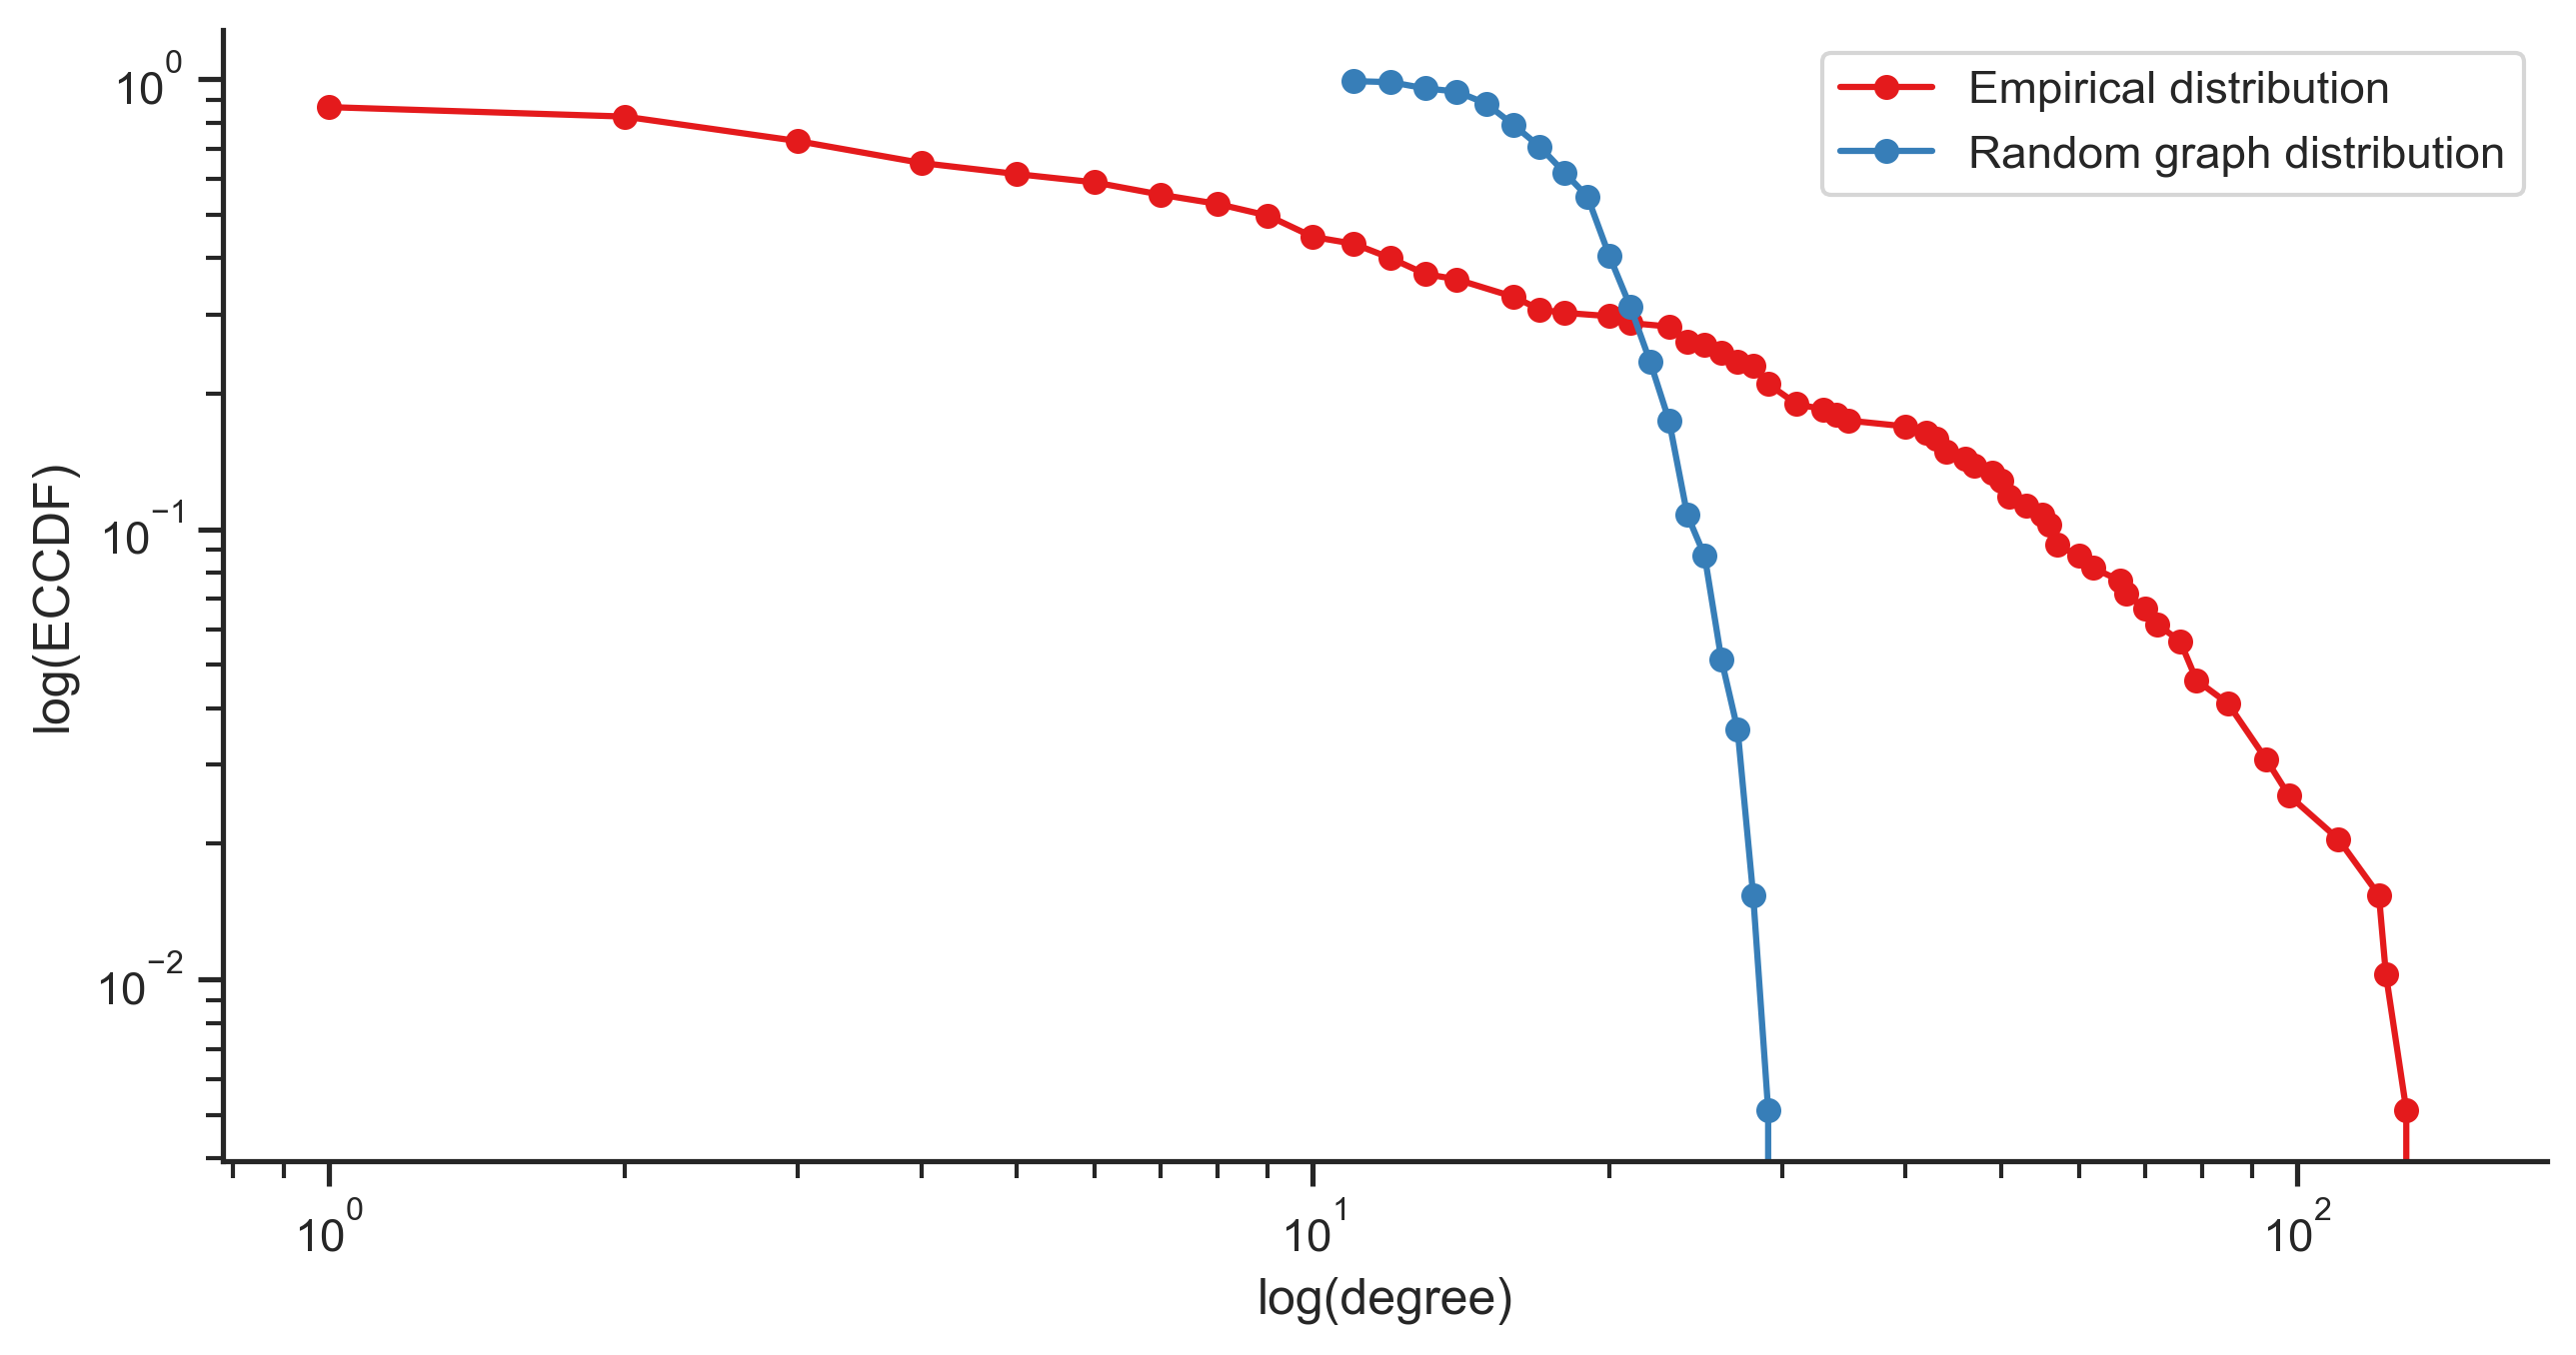

In [35]:
ecdf_real = ECDF(degree_values)
x_real = np.unique(degree_values)
y_real = ecdf_real(x_real)
ecdf_random = ECDF(RG_degree_values)
x_random = np.unique(RG_degree_values)
y_random = ecdf_random(x_random)
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.loglog(x_real,1-y_real,marker='o',ms=5, color='#e41a1c', 
          label='Empirical distribution')
ax.plot(x_random,1-y_random,marker='o',ms=5, color='#377eb8',
       label='Random graph distribution')
ax.set_xlabel('log(degree)')
ax.set_ylabel('log(ECCDF)')
sns.despine()
plt.legend()
plt.show()

# Centrality measures

In [24]:
#higher in-degree, out-degree, total-degree
print('Countries with higher import (in-degree):')
print(in_degree.sort_values(ascending=False).head())
print('\n')
print('Countries with higher export (out-degree):')
print(out_degree.sort_values(ascending=False).head())
print('\n')
print('Countries with larger number of connections (degree):')
print(degree.sort_values(ascending=False).head())

Countries with higher import (in-degree):
NLD    46
FRA    45
DEU    44
GBR    42
ITA    41
dtype: int64


Countries with higher export (out-degree):
RUS    106
USA     96
FRA     95
CAN     81
DEU     77
dtype: int64


Countries with larger number of connections (degree):
FRA    140
USA    129
RUS    123
DEU    121
CAN    110
dtype: int64


In [5]:
#Weighted in, out & total degree
w_in_degree = pd.Series(dict(G.in_degree(weight='weight')))
w_out_degree = pd.Series(dict(G.out_degree(weight='weight')))
w_degree = pd.Series(dict(G.degree(weight='weight')))
print('Countries with higher import worth (weighted in-degree):')
print(w_in_degree.sort_values(ascending=False).head())
print('\n')
print('Countries with higher export worth (weighted out-degree):')
print(w_out_degree.sort_values(ascending=False).head())
print('\n')
print('Countries involved in worthiest transactions (weighted degree):')
print(w_degree.sort_values(ascending=False).head())

Countries with higher import worth (weighted in-degree):
IDN    2383884.631
TUR    2117514.516
EGY    2006141.805
ITA    1729312.155
PHL    1639358.844
dtype: float64


Countries with higher export worth (weighted out-degree):
RUS    6656595.681
USA    6326560.644
CAN    6081179.986
FRA    4322692.747
AUS    2667907.342
dtype: float64


Countries involved in worthiest transactions (weighted degree):
USA    6752140.745
RUS    6702755.046
CAN    6122255.703
FRA    4441878.945
AUS    2928194.293
dtype: float64


In [10]:
#Closeness centrality
cl_centr = pd.Series(nx.closeness_centrality(G, wf_improved=False, distance=None)).sort_values(ascending=False)
cl_centr.head()
#Basically the same as in-degree

GBR    0.570707
NLD    0.567839
FRA    0.562189
DEU    0.559406
USA    0.548544
dtype: float64

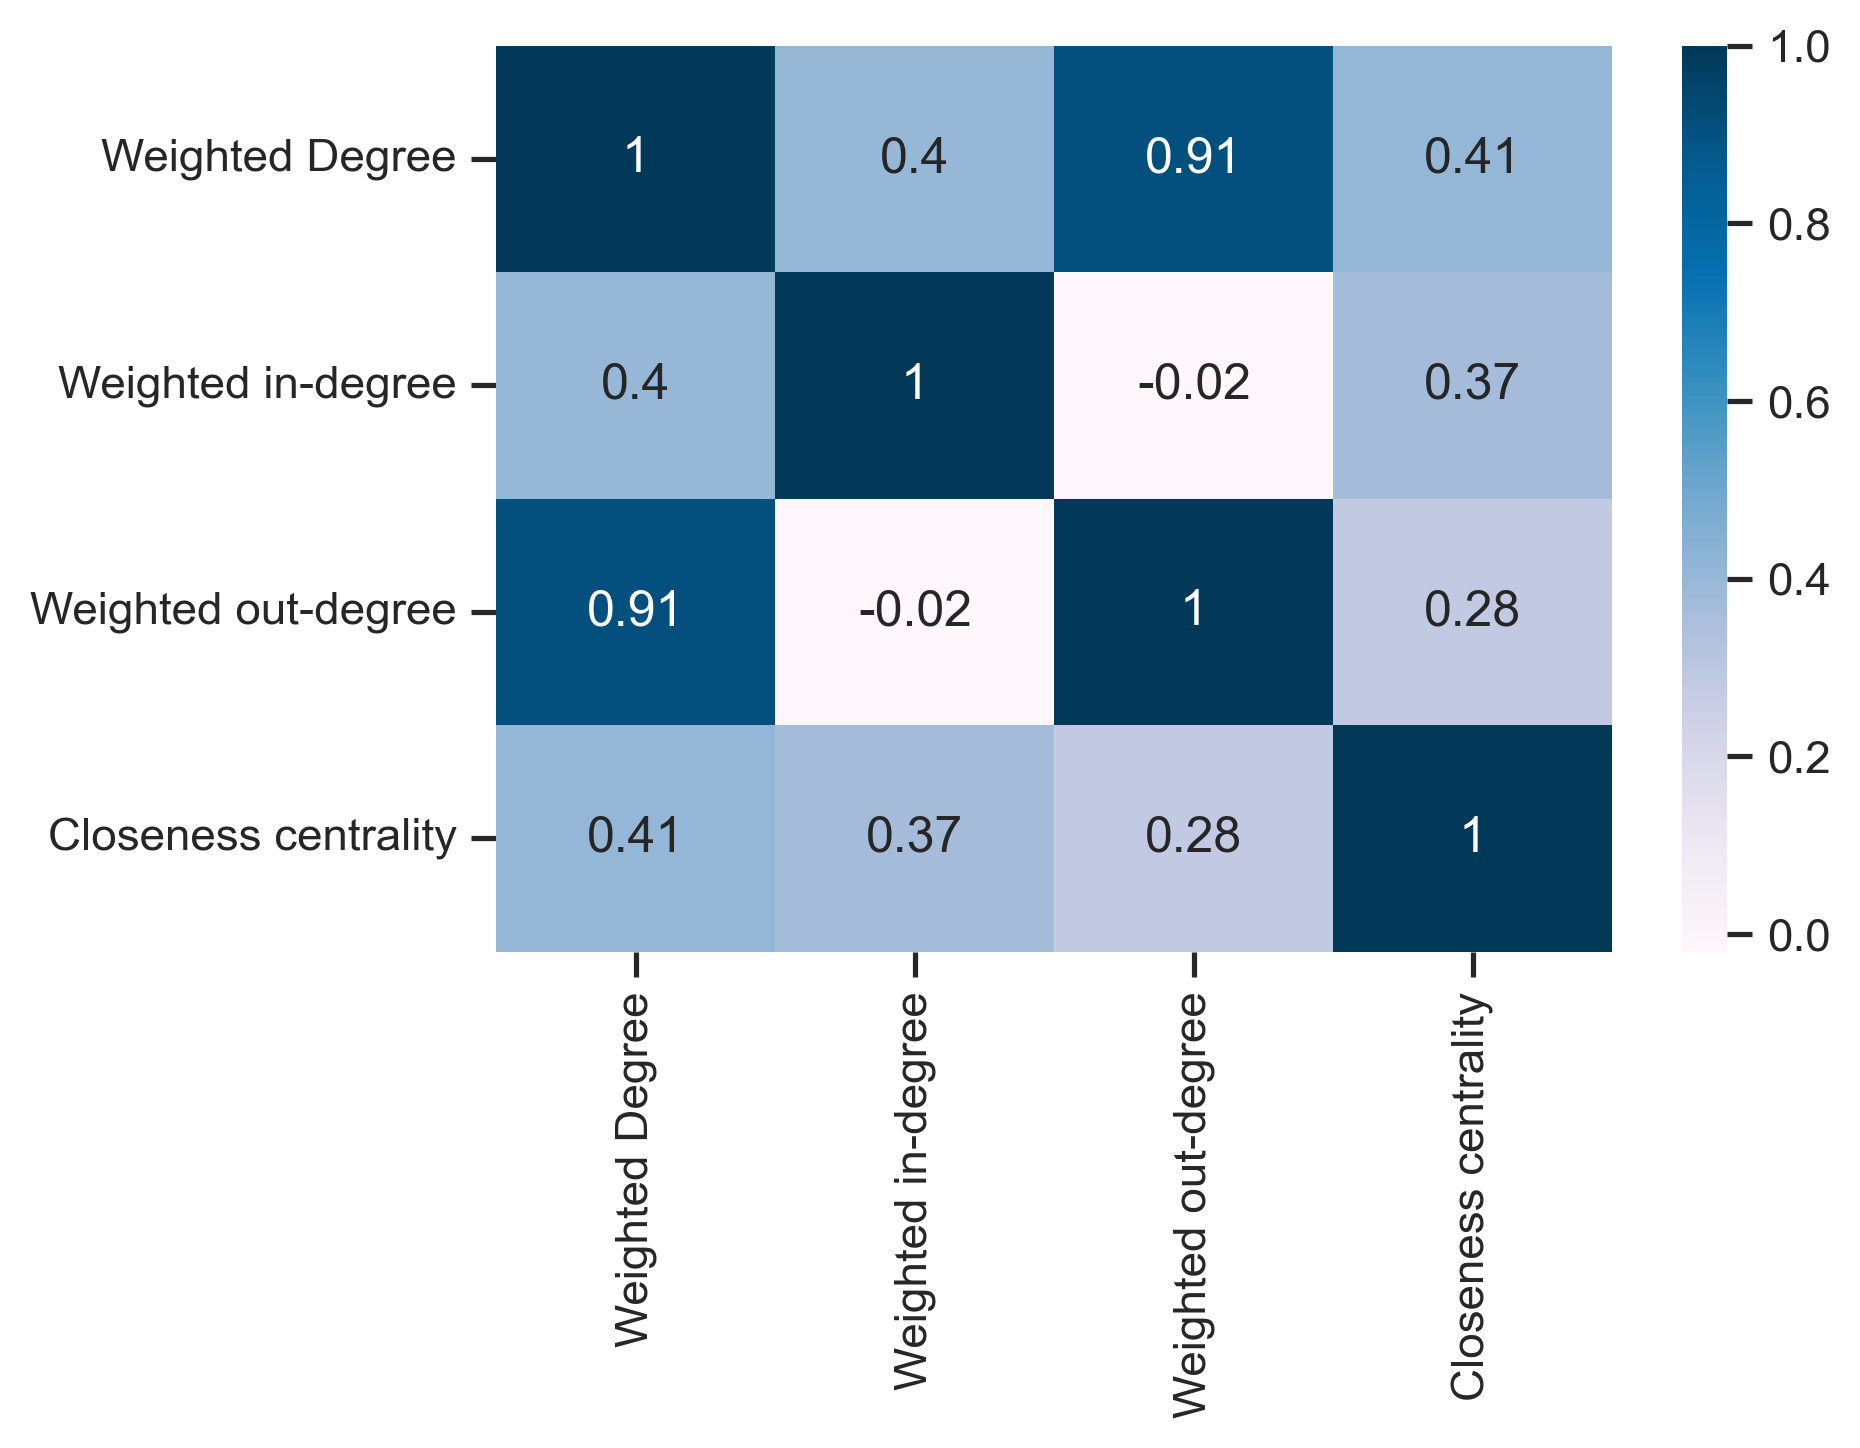

In [31]:
#Comparing the different measures
centr = (pd.concat([w_degree, w_in_degree, w_out_degree, cl_centr], axis=1)).dropna()
centr.rename(columns = {0:'Weighted Degree', 1:'Weighted in-degree', 2:'Weighted out-degree', 3:'Closeness centrality', }, inplace=True)
corr = centr.corr()
sns.heatmap(corr, annot=True, cmap='PuBu')
plt.show()

# Import-Export

In [25]:
list(d.keys())

['Asia', 'Europe', 'Africa', 'North America', 'South America', 'Oceania']

In [26]:
#Africa: avg in/out weighted/unweighted degree
africa_avg_in = in_degree[d['Africa']].mean()
africa_avg_out = out_degree[d['Africa']].mean()
w_africa_avg_in = w_in_degree[d['Africa']].mean()
w_africa_avg_out = w_out_degree[d['Africa']].mean()

#Asia: avg in/out weighted/unweighted degree
asia_avg_in = in_degree[d['Asia']].mean()
asia_avg_out = out_degree[d['Asia']].mean()
w_asia_avg_in = w_in_degree[d['Asia']].mean()
w_asia_avg_out = w_out_degree[d['Asia']].mean()

#Europe: avg in/out weighted/unweighted degree
eu_avg_in = in_degree[d['Europe']].mean()
eu_avg_out = out_degree[d['Europe']].mean()
w_eu_avg_in = w_in_degree[d['Europe']].mean()
w_eu_avg_out = w_out_degree[d['Europe']].mean()

#North America: avg in/out weighted/unweighted degree
na_avg_in = in_degree[d['North America']].mean()
na_avg_out = out_degree[d['North America']].mean()
w_na_avg_in = w_in_degree[d['North America']].mean()
w_na_avg_out = w_out_degree[d['North America']].mean()

#Oceania: avg in/out weighted/unweighted degree
oceania_avg_in = in_degree[d['Oceania']].mean()
oceania_avg_out = out_degree[d['Oceania']].mean()
w_oceania_avg_in = w_in_degree[d['Oceania']].mean()
w_oceania_avg_out = w_out_degree[d['Oceania']].mean()

#South America: avg in/out weighted/unweighted degree
sa_avg_in = in_degree[d['South America']].mean()
sa_avg_out = out_degree[d['South America']].mean()
w_sa_avg_in = w_in_degree[d['South America']].mean()
w_sa_avg_out = w_out_degree[d['South America']].mean()

In [27]:
imp_exp = pd.DataFrame({'Zone': ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']*2, 
                       'Degree' : [africa_avg_in, asia_avg_in, eu_avg_in, na_avg_in, oceania_avg_in, sa_avg_in, 
                                   africa_avg_out, asia_avg_out, eu_avg_out, na_avg_out, oceania_avg_out, sa_avg_out], 
                       'Type' : (['In-degree']*6 + ['Out-degree']*6), 
                       'Weighted degree' : [w_africa_avg_in, w_asia_avg_in, w_eu_avg_in, w_na_avg_in, w_oceania_avg_in, w_sa_avg_in, 
                                   w_africa_avg_out, w_asia_avg_out, w_eu_avg_out, w_na_avg_out, w_oceania_avg_out, w_sa_avg_out], 
                       'Weighted type' : (['Weighted in-degree']*6 + ['Weighted out-degree']*6)})

In [28]:
imp_exp

Zone     Degree        Type  Weighted degree        Weighted type
0          Africa   7.215686   In-degree    183271.695353   Weighted in-degree
1            Asia  10.020000   In-degree    351178.198980   Weighted in-degree
2          Europe  21.725000   In-degree    191619.709600   Weighted in-degree
3   North America   4.740741   In-degree     88509.151741   Weighted in-degree
4         Oceania   3.266667   In-degree     34254.367600   Weighted in-degree
5   South America   5.000000   In-degree    248232.434833   Weighted in-degree
6          Africa   1.686275  Out-degree      1254.707627  Weighted out-degree
7            Asia   9.000000  Out-degree    158749.813920  Weighted out-degree
8          Europe  27.025000  Out-degree    366123.356325  Weighted out-degree
9   North America   7.666667  Out-degree    464117.660111  Weighted out-degree
10        Oceania   4.200000  Out-degree    177916.063800  Weighted out-degree
11  South America   7.333333  Out-degree    217214.483917  Weighted out-degree

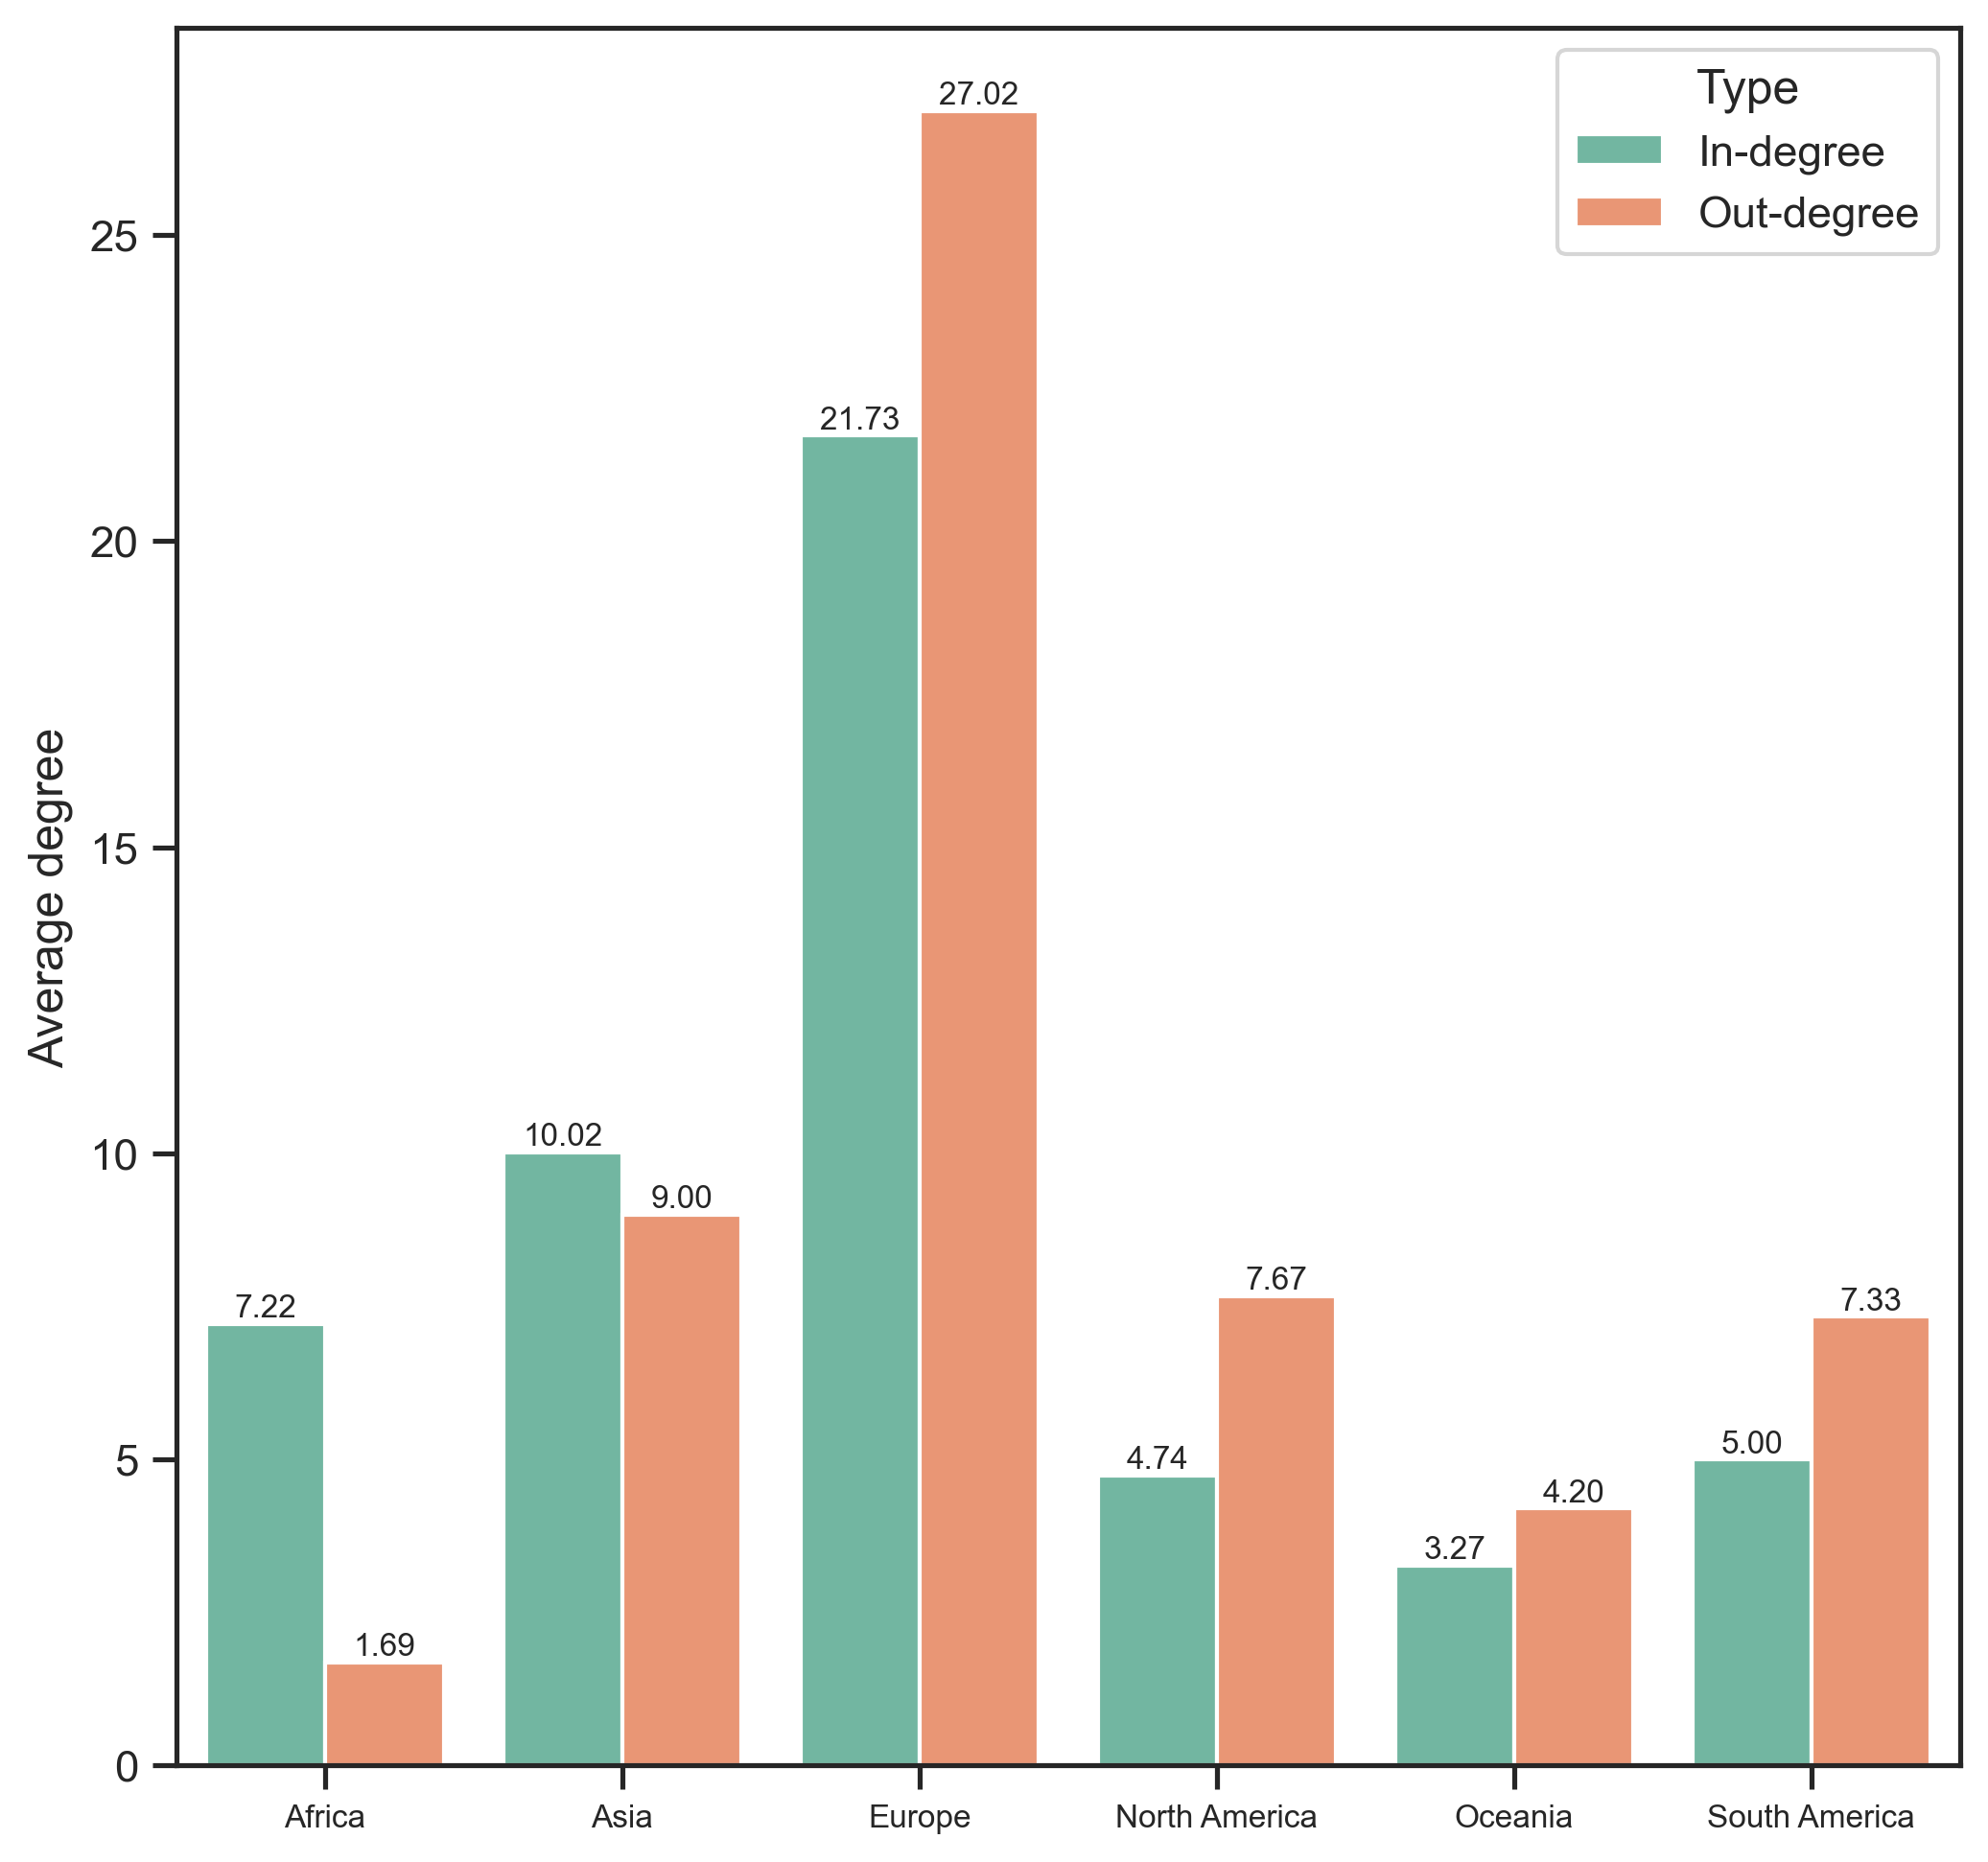

In [29]:
#Plot unweighted degree
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x='Zone', y='Degree', hue='Type', data=imp_exp, palette='Set2', ax=ax)
ax.tick_params(axis='x', labelsize=8)
ax.set_xlabel('')
ax.set_ylabel('Average degree')
ax.bar_label(ax.containers[0], size=8, fmt='%.2f')
ax.bar_label(ax.containers[1], size=8, fmt='%.2f')
plt.show()

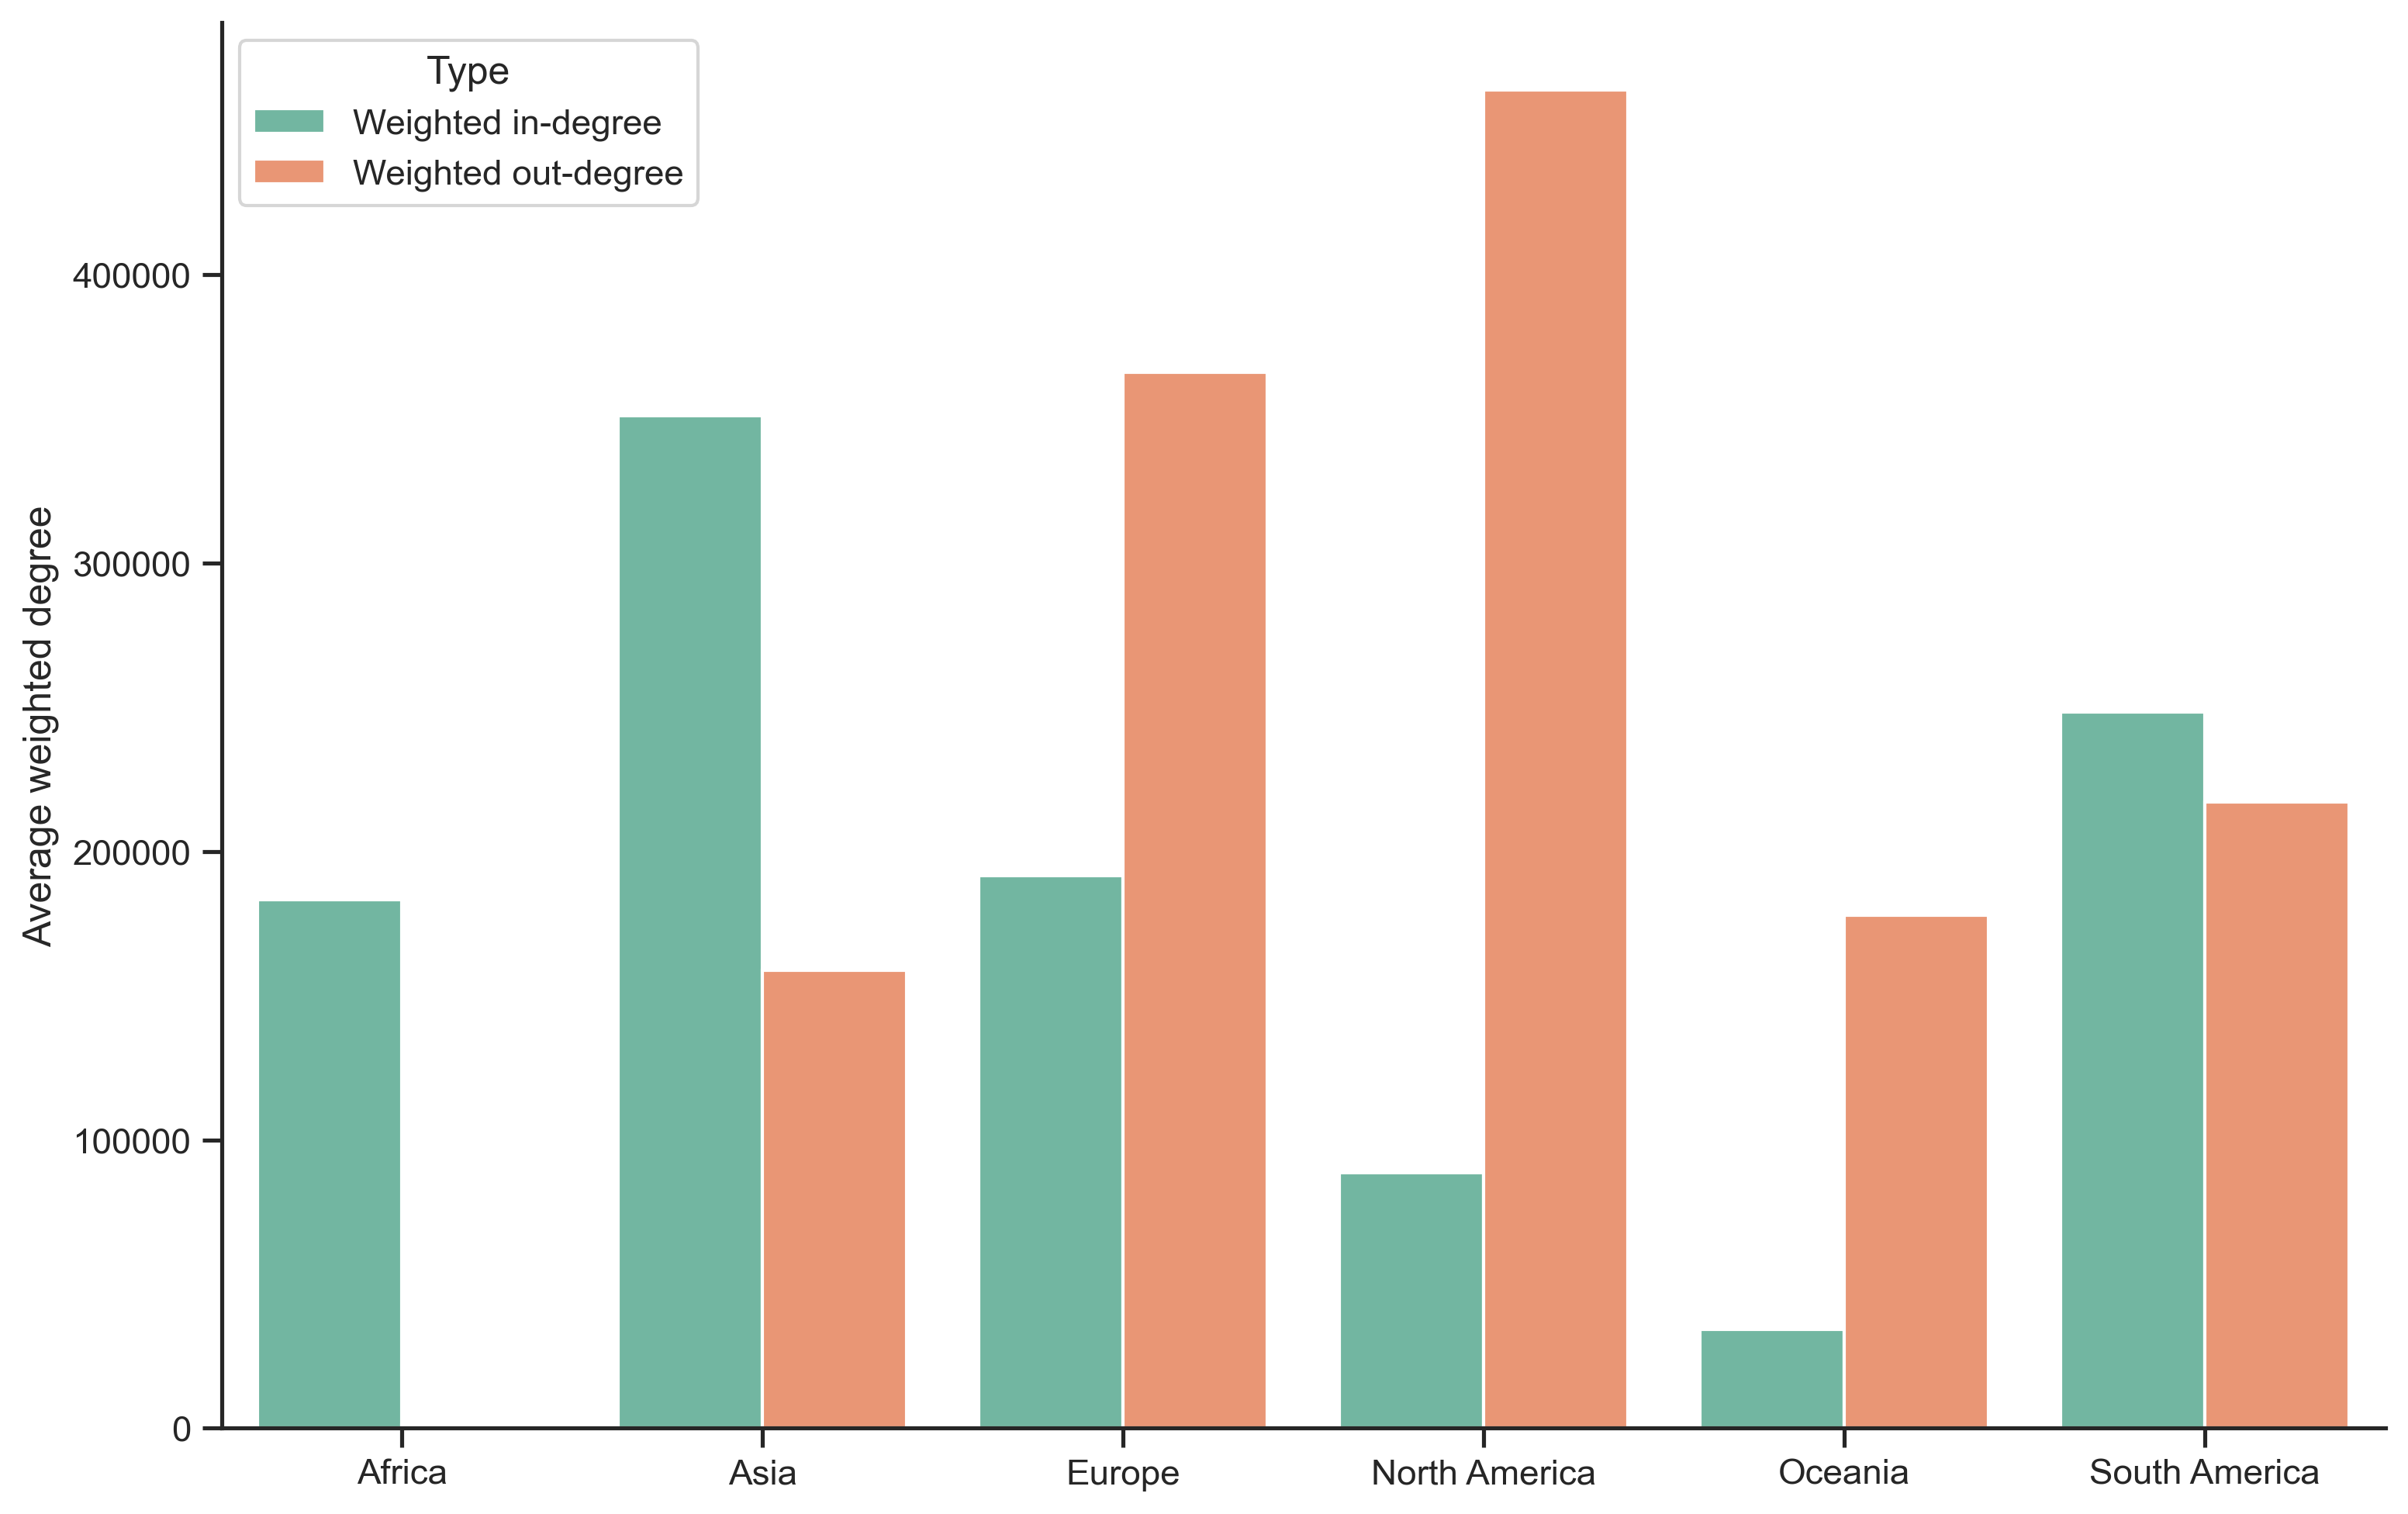

In [30]:
#Import export balance
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='Zone', y='Weighted degree', hue='Weighted type', data=imp_exp, palette='Set2', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Average weighted degree')
#ax.bar_label(ax.containers[0], size=8, fmt='%.0f')
#ax.bar_label(ax.containers[1], size=8, fmt='%.0f')
sns.despine()
plt.legend(title='Type', loc='upper left')
plt.show()

# Reciprocity & Motifs

In [38]:
print('Reciprocity in the whole network:', nx.reciprocity(G))

for z in zones: 
    print('Reciprocity in ', z, ': ', nx.reciprocity(G.subgraph(d[z])), sep='')

Reciprocity in the whole network: 0.3848101265822785
Reciprocity in Asia: 0.23655913978494625
Reciprocity in Europe: 0.7104851330203443
Reciprocity in Africa: 0.3076923076923077
Reciprocity in North America: 0.26666666666666666
Reciprocity in South America: 0.1111111111111111
Reciprocity in Oceania: 0.23529411764705882


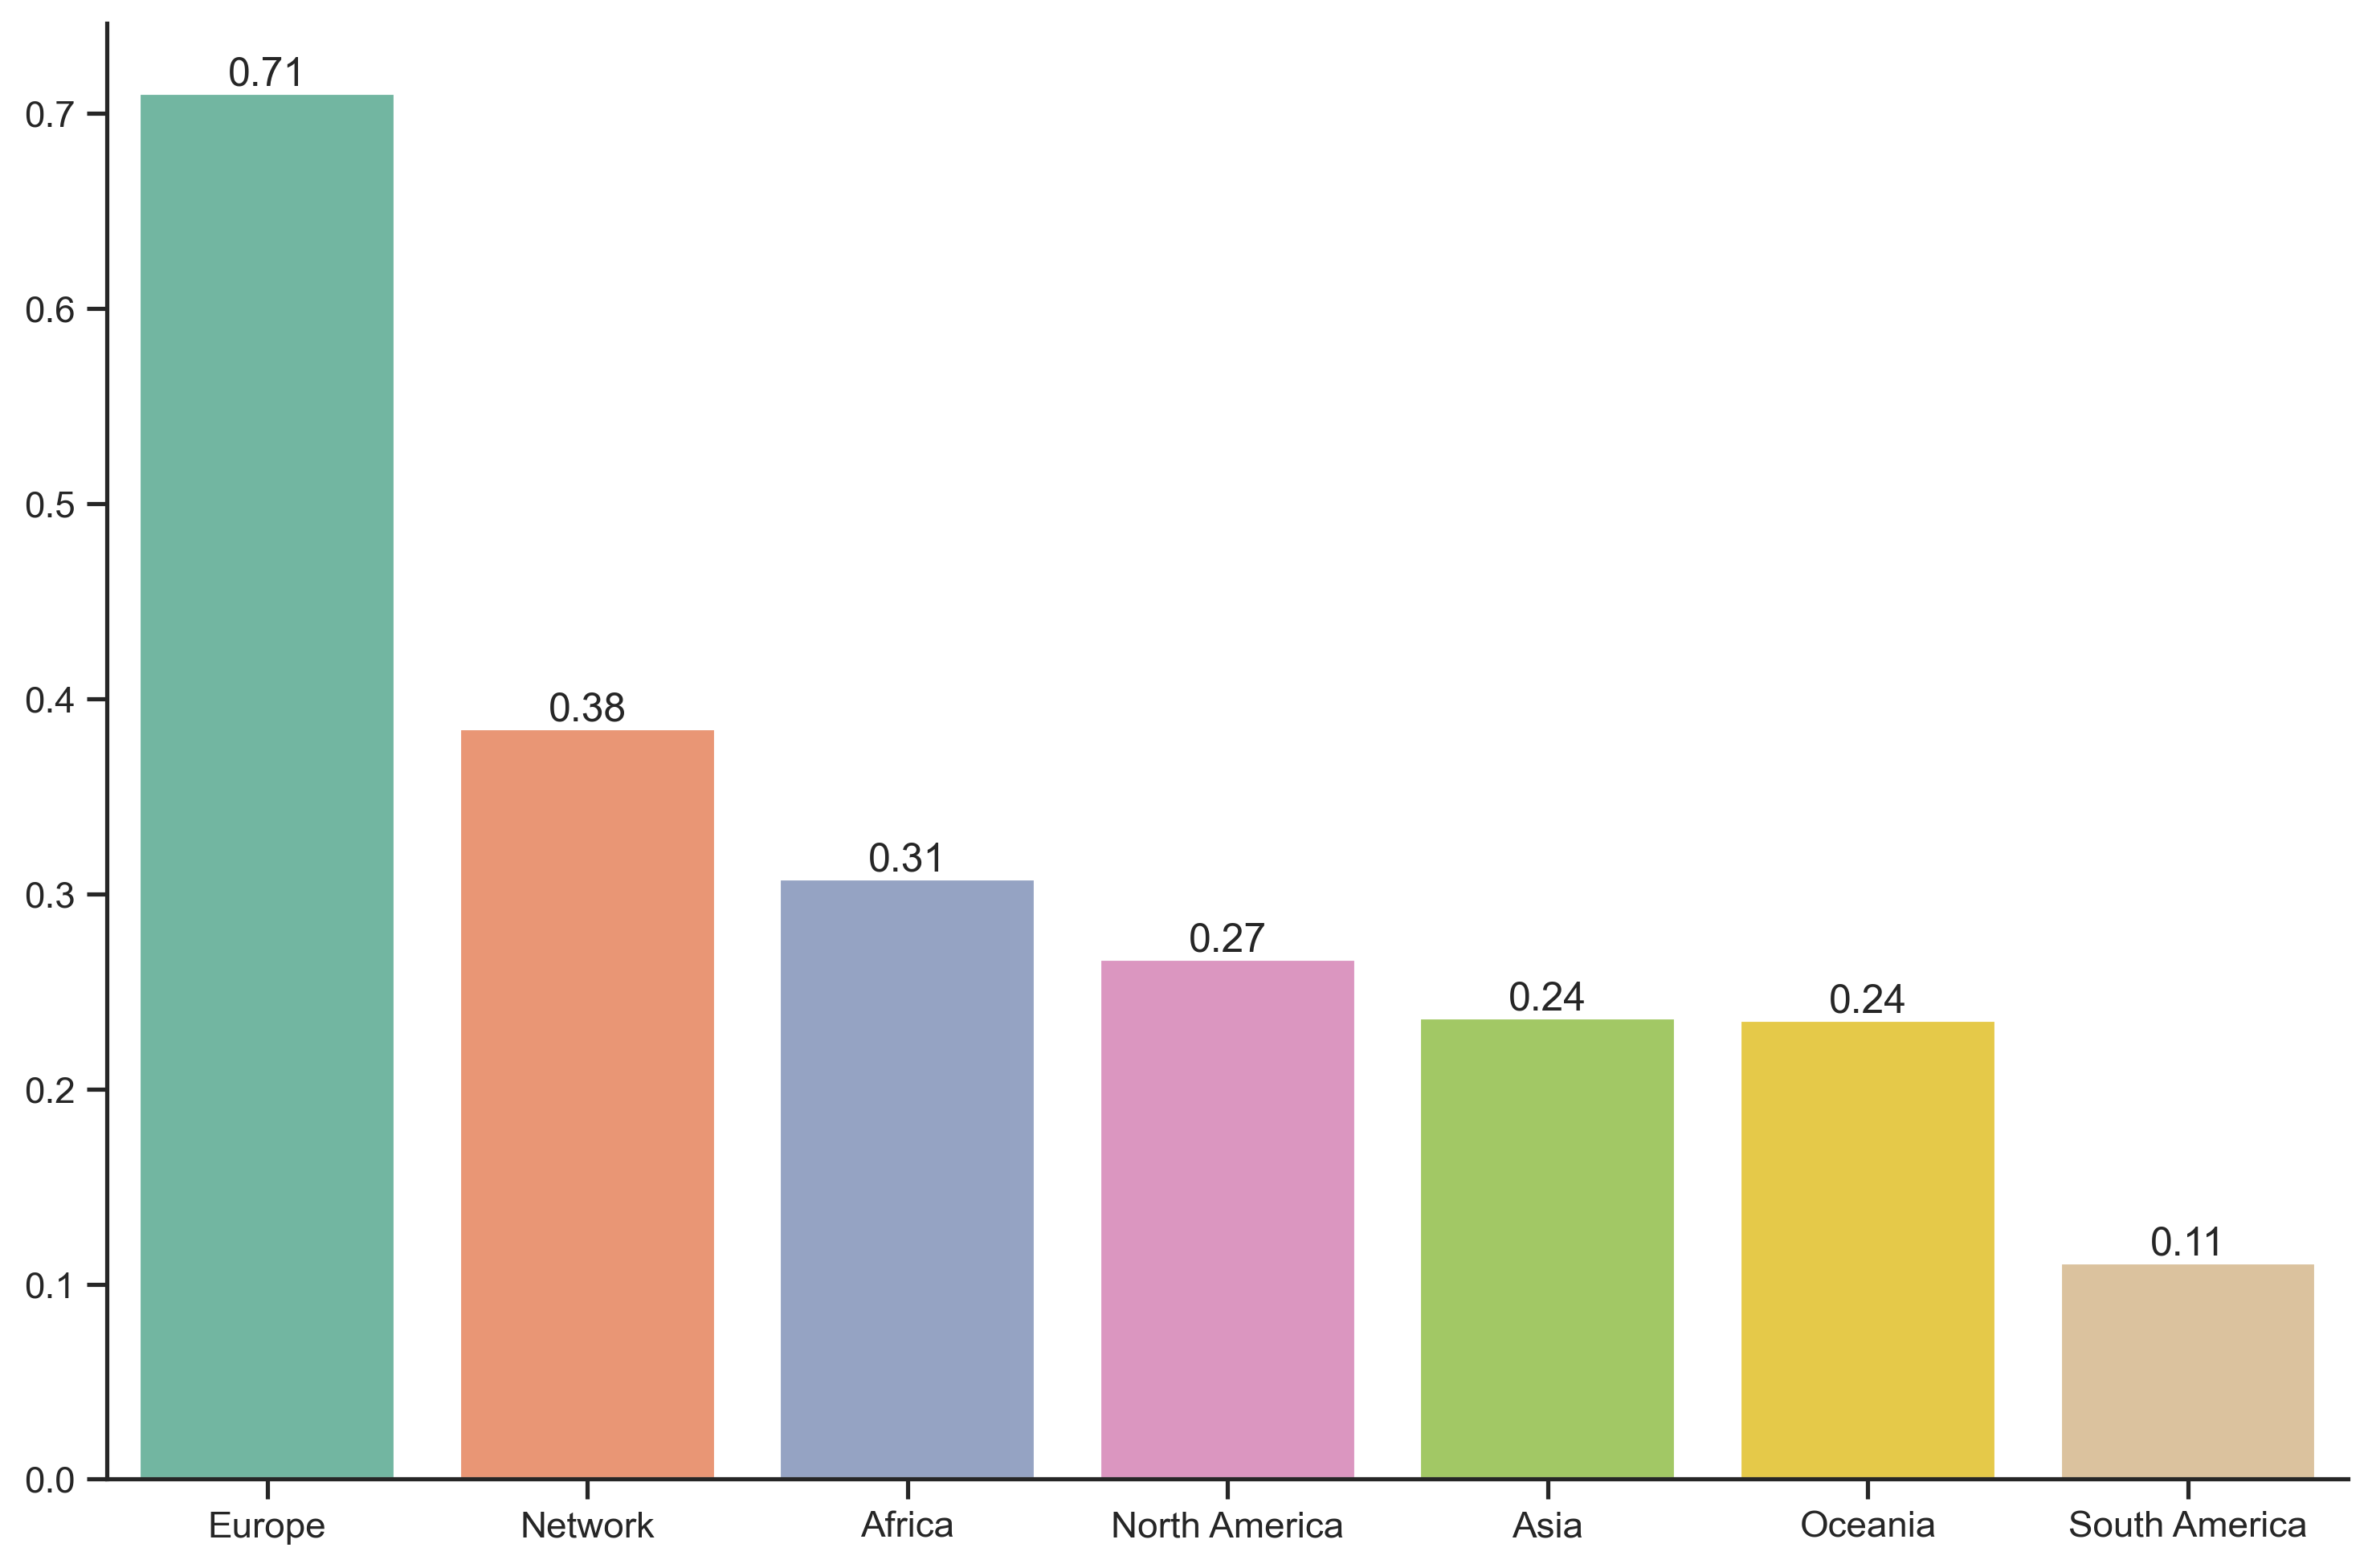

In [39]:
rec = {'Network' : nx.reciprocity(G)}
for z in zones:
    rec[z] = nx.reciprocity(G.subgraph(d[z]))

rec = pd.Series(rec).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12,8), dpi=300)
sns.barplot(x=rec.index, y=rec.values, ax=ax, palette='Set2')
ax.bar_label(ax.containers[0], fmt='%.2f')
sns.despine()
plt.show()

In [36]:
#triadic_census() returns a dict: the keys are the type of pattern (see paper in the docs),
#the values are the frequency of each pattern
#see page 2 for encoding: http://vlado.fmf.uni-lj.si/pub/networks/doc/triads/triads.pdf
pd.Series(nx.triadic_census(G)).sort_values(ascending=False)

003     966560
012     154750
102      45574
021D     17974
111U     11667
021C      6029
111D      2894
021U      2063
210       1816
201       1805
120U      1676
030T      1643
300        982
120C       750
120D       591
030C        91
dtype: int64

In [92]:
#Asia
pd.Series(nx.triadic_census(G.subgraph(d['Asia']))).sort_values(ascending=False)

003     13424
012      4037
021D      791
102       615
111U      232
021C      146
030T       93
021U       89
111D       71
120U       35
201        23
120D       13
210        13
120C       12
030C        4
300         2
dtype: int64

In [93]:
#Africa
pd.Series(nx.triadic_census(G.subgraph(d['Africa']))).sort_values(ascending=False)

003     19332
012      1146
102       225
111U       37
021D       32
021C       24
111D       11
201         9
021U        7
120D        1
210         1
030T        0
030C        0
120U        0
120C        0
300         0
dtype: int64

In [94]:
#South America
pd.Series(nx.triadic_census(G.subgraph(d['South America']))).sort_values(ascending=False)

003     101
012      72
021D     22
030T      8
102       7
021C      4
021U      3
120D      1
120U      1
120C      1
111D      0
111U      0
030C      0
201       0
210       0
300       0
dtype: int64

In [95]:
#Europe
pd.Series(nx.triadic_census(G.subgraph(d['Europe']))).sort_values(ascending=False)

012     1735
102     1635
003     1566
111U    1068
210      830
300      767
201      504
021D     364
120U     350
111D     290
021C     256
120C     182
120D     132
030T     126
021U      64
030C      11
dtype: int64

In [96]:
#Oceania
pd.Series(nx.triadic_census(G.subgraph(d['Oceania']))).sort_values(ascending=False)

003     303
012      99
021D     19
111U     12
102      11
021C      8
021U      1
201       1
120U      1
111D      0
030T      0
030C      0
120D      0
120C      0
210       0
300       0
dtype: int64

In [97]:
#North America
pd.Series(nx.triadic_census(G.subgraph(d['North America']))).sort_values(ascending=False)

003     2226
012      376
021D     166
102       69
111U      54
120U      10
021C       6
030T       6
111D       4
210        3
021U       1
201        1
120D       1
120C       1
300        1
030C       0
dtype: int64

# UKR and RUS

In [174]:
print('Nr of countries in which Ukraine exports', out_degree['UKR'])
print('Nr of countries in which Russia exports', out_degree['RUS'])
print('\n')
print('Russia export worth:', w_out_degree['RUS'])
print('Ukraine export worth:', w_out_degree['UKR'])
print('Russia import worth:', w_in_degree['RUS'])
print('Ukraine import worth:', w_in_degree['UKR'])
print('\n')
print('Russia export / Ukraine export:', w_out_degree['RUS'] /  w_out_degree['UKR'])
print('Russia import / Ukraine import:', w_in_degree['RUS'] /  w_in_degree['UKR'])
print('\n')
print('Russia export / Russia import:', w_out_degree['RUS'] /  w_in_degree['RUS'])
print('Ukraine export / Ukraine import:', w_out_degree['UKR'] /  w_in_degree['UKR'])

Nr of countries in which Ukraine exports 38
Nr of countries in which Russia exports 106


Russia export worth: 6656595.681000004
Ukraine export worth: 2330203.288
Russia import worth: 46159.365000000005
Ukraine import worth: 9492.327000000001


Russia export / Ukraine export: 2.8566587796351968
Russia import / Ukraine import: 4.862808139669019


Russia export / Russia import: 144.20899596430763
Ukraine export / Ukraine import: 245.48282923670877


In [119]:
l = len(list(G.out_edges('UKR', data=True)))
UKR = pd.DataFrame({'Source' : ['UKR']*l})
UKR['Id'] = [list(G.out_edges('UKR'))[i][1] for i in range(l)]
UKR['Weight'] = [list(G.out_edges('UKR', data=True))[i][2]['weight'] for i in range(l)]
UKR['Target imports'] = w_in_degree[UKR['Id']].values
UKR['% UKR imports'] = round((UKR['Weight'] / UKR['Target imports']) * 100, 2)
UKR['TargetZone'] = [G.nodes[UKR['Id'][i]]['Zone'] for i in range(len(UKR))]
UKR.sort_values('% UKR imports', ascending=False, inplace=True)
UKR

Source   Id      Weight  Target imports  % UKR imports     TargetZone
33    UKR  TUN  199889.845      413034.464          48.40         Africa
12    UKR  ISR   92057.300      325541.705          28.28           Asia
31    UKR  THA  185377.979      681375.064          27.21           Asia
11    UKR  IDN  616618.625     2383884.631          25.87           Asia
21    UKR  MAR  180418.555      913646.652          19.75         Africa
24    UKR  PHL  247420.513     1639358.844          15.09           Asia
17    UKR  KOR  119335.223      935362.725          12.76           Asia
28    UKR  ZWE    8002.138       66546.360          12.02         Africa
15    UKR  JOR   37106.963      314151.939          11.81           Asia
20    UKR  MYS   45913.889      425696.497          10.79           Asia
29    UKR  ESP  108022.777     1025870.196          10.53         Europe
16    UKR  KEN   44884.185      433201.239          10.36         Africa
34    UKR  TUR  211838.658     2117514.516          10.00           Asia
4     UKR  BLR    5957.728       61553.653           9.68         Europe
3     UKR  MMR    9170.107      106814.338           8.59           Asia
37    UKR  YEM   71708.162     1036735.435           6.92           Asia
2     UKR  BGR     922.396       13822.778           6.67         Europe
1     UKR  ARM    3514.544       63348.160           5.55           Asia
35    UKR  GBR   13855.557      309900.426           4.47         Europe
26    UKR  SEN    8165.132      201841.244           4.05         Africa
27    UKR  ZAF   16162.917      408950.291           3.95         Africa
22    UKR  NLD   30301.910      978372.880           3.10         Europe
13    UKR  ITA   44163.880     1729312.155           2.55         Europe
5     UKR  KHM     320.112       13818.426           2.32           Asia
7     UKR  ECU    6698.937      310745.260           2.16  South America
19    UKR  LTU    1403.307       68243.523           2.06         Europe
10    UKR  GRC    4615.286      227000.349           2.03         Europe
6     UKR  DNK    1011.363       56025.678           1.81         Europe
8     UKR  FRA    1641.774      119186.198           1.38         Europe
14    UKR  CIV    2058.038      159470.871           1.29         Africa
30    UKR  CHE    1460.770      120944.861           1.21         Europe
25    UKR  POL    1241.648      114403.733           1.09         Europe
32    UKR  ARE    3186.941      326362.246           0.98           Asia
23    UKR  NOR     539.026       78508.757           0.69         Europe
9     UKR  DEU    5040.685      747616.277           0.67         Europe
36    UKR  BFA     122.926       24200.477           0.51         Africa
18    UKR  KWT       8.459      140999.734           0.01           Asia
0     UKR  AZE      45.033      311303.194           0.01           Asia

In [121]:
l = len(list(G.out_edges('RUS', data=True)))
RUS = pd.DataFrame({'Source' : ['RUS']*l})
RUS['Id'] = [list(G.out_edges('RUS'))[i][1] for i in range(l)]
RUS['Weight'] = [list(G.out_edges('RUS', data=True))[i][2]['weight'] for i in range(l)]
RUS['Target imports'] = w_in_degree[RUS['Id']].values
RUS['% RUS imports'] = round((RUS['Weight'] / RUS['Target imports']) * 100, 2)
RUS['TargetZone'] = [G.nodes[RUS['Id'][i]]['Zone'] for i in range(len(RUS))]
RUS.sort_values('% RUS imports', ascending=False, inplace=True)
RUS

Source   Id     Weight  Target imports  % RUS imports TargetZone
61    RUS  MNG   5131.552        5131.552         100.00       Asia
20    RUS  BEN   4546.025        4555.062          99.80     Africa
43    RUS  KAZ  53696.990       53867.394          99.68       Asia
49    RUS  LAO   1421.748        1491.895          95.30       Asia
6     RUS  ARM  59190.418       63348.160          93.44       Asia
..    ...  ...        ...             ...            ...        ...
73    RUS  POL     25.078      114403.733           0.02     Europe
4     RUS  AUT     11.175      186817.859           0.01     Europe
1     RUS  DZA      5.907     1456660.854           0.00     Africa
78    RUS  SVK      0.001        6335.451           0.00     Europe
89    RUS  TJK      0.063      205294.359           0.00       Asia

[106 rows x 6 columns]

In [175]:
UKR_exp = UKR.groupby(['TargetZone']).sum()['Weight']
RUS_exp = RUS.groupby(['TargetZone']).sum()['Weight']

In [177]:
UKR_exp

TargetZone
Africa            459703.736
Asia             1643622.508
Europe            220178.107
South America       6698.937
Name: Weight, dtype: float64

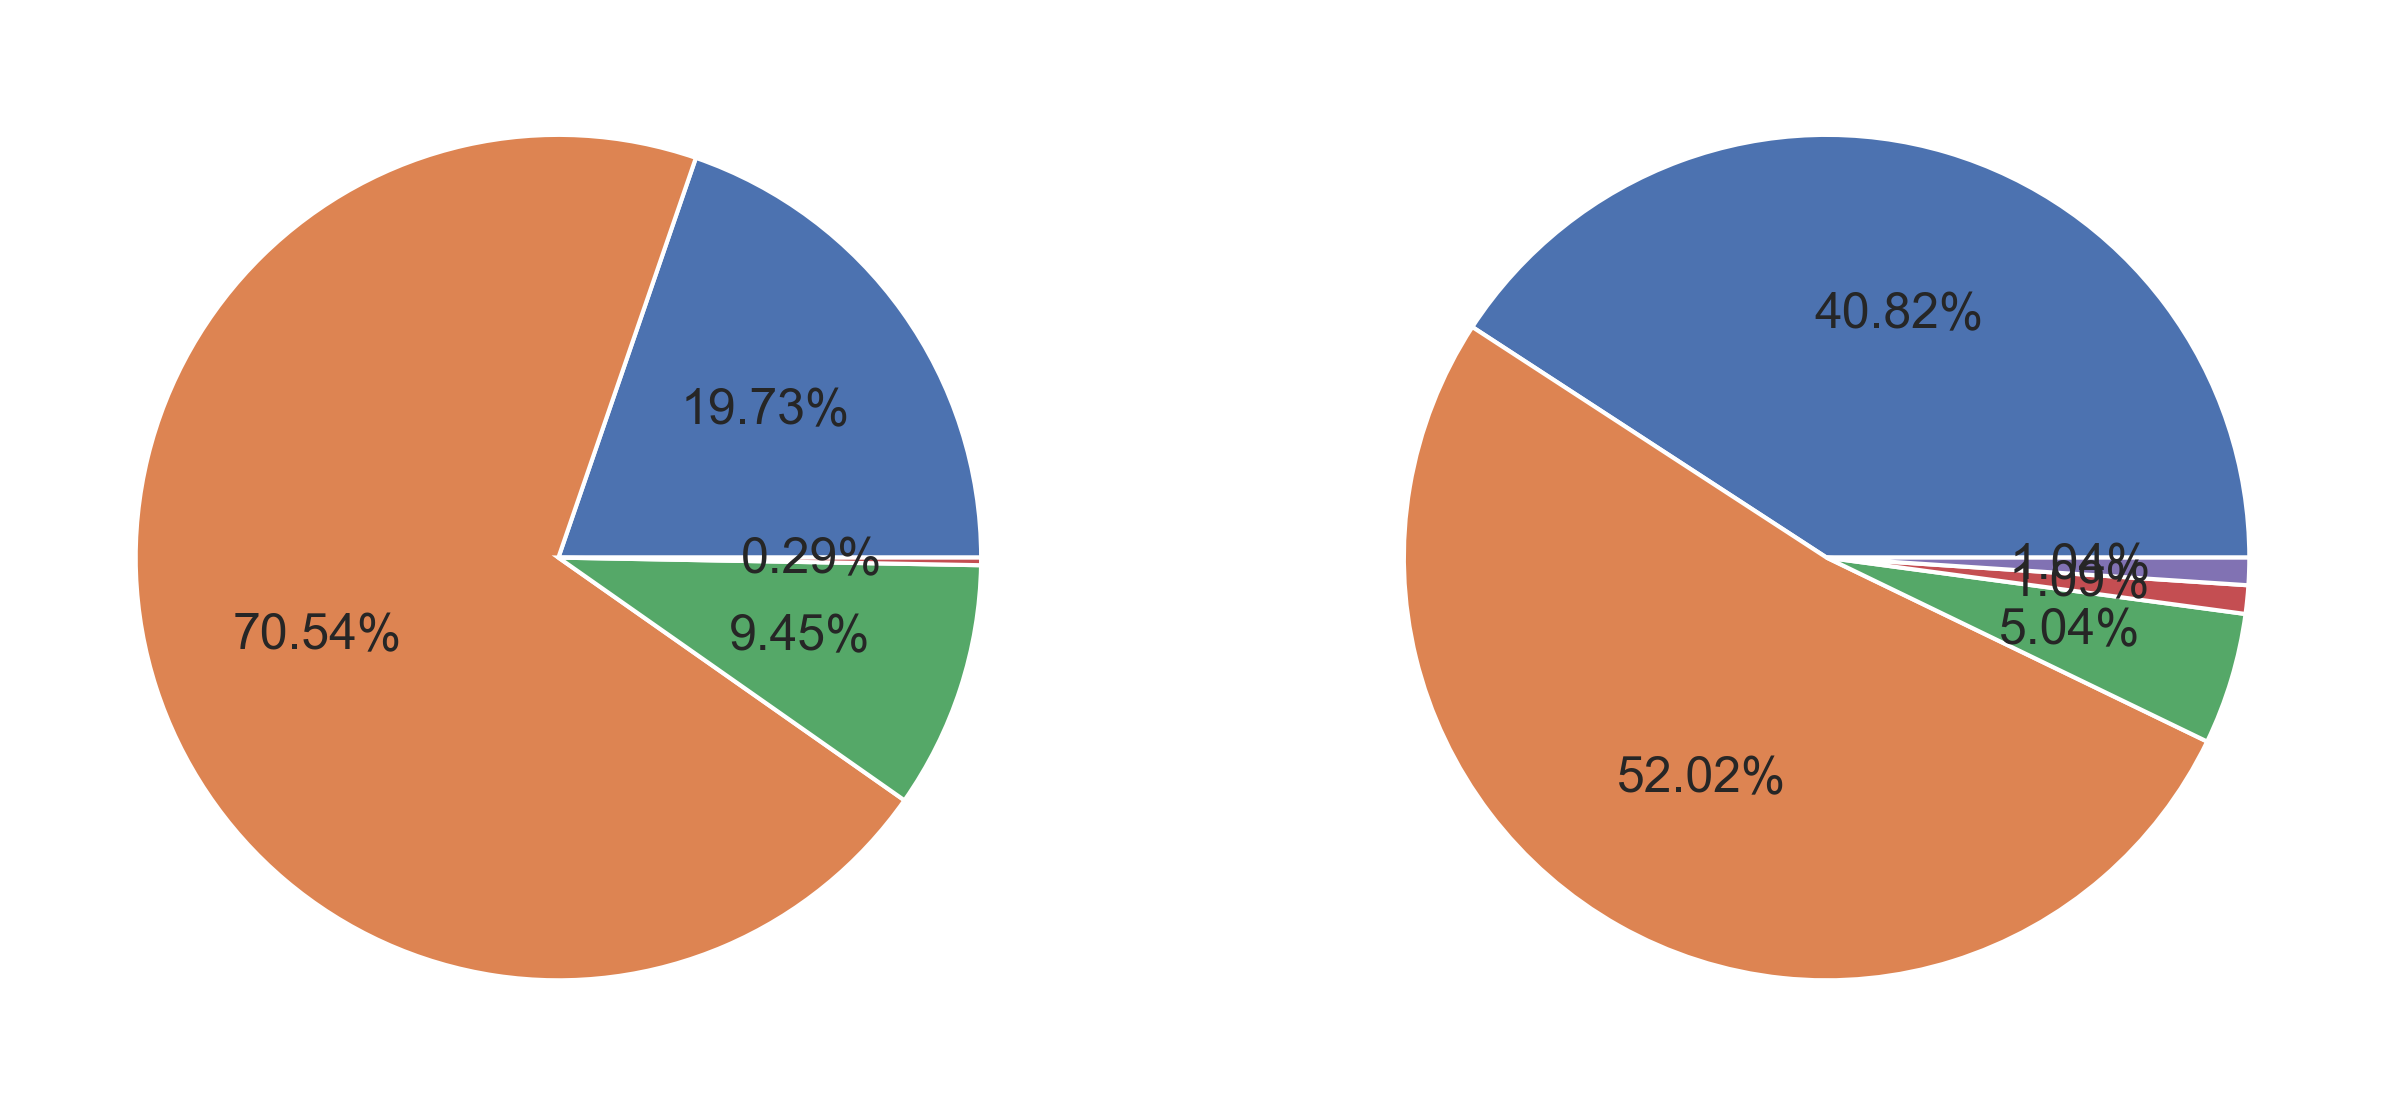

In [109]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].pie(UKR_exp, labels = UKR_exp.index, autopct='%.2f%%')
axes[1].pie(RUS_exp, labels = RUS_exp.index, autopct='%.2f%%')
plt.show()

In [112]:
print('Top 10 countries depending from UKR:')
print(UKR[['TargetZone', 'Id', '% UKR imports']].head(10))

print('\n')

print('Top 10 countries depending from RUS:')
print(RUS[['TargetZone', 'Id', '% RUS imports']].head(10))

Top 10 countries depending from UKR:
   TargetZone Target  % UKR imports
33     Africa    TUN          48.40
12       Asia    ISR          28.28
31       Asia    THA          27.21
11       Asia    IDN          25.87
21     Africa    MAR          19.75
24       Asia    PHL          15.09
17       Asia    KOR          12.76
28     Africa    ZWE          12.02
15       Asia    JOR          11.81
20       Asia    MYS          10.79


Top 10 countries depending from RUS:
       TargetZone Target  % RUS imports
61           Asia    MNG         100.00
20         Africa    BEN          99.80
43           Asia    KAZ          99.68
49           Asia    LAO          95.30
6            Asia    ARM          93.44
26         Africa    DJI          88.61
11         Europe    BLR          87.74
46           Asia    PRK          85.98
3            Asia    AZE          85.02
68  North America    NIC          84.71


# Community detection

### Greedy approach

In [6]:
#Greedy approach 
greedy_comm = list(nx_comm.greedy_modularity_communities(G, weight='weight'))
print('Number of communities detected:', len(greedy_comm))

Number of communities detected: 6


In [16]:
dfs = [[] for i in range(len(greedy_comm))]
for i in range(len(greedy_comm)): 
    dfs[i] = pd.DataFrame({'Country' : list(greedy_comm[i]), 'Greedy Comm.' : ('Comm. ' + str(i+1))})
    
greedy_df = pd.concat(dfs)

fig = px.choropleth(greedy_df, locations="Country", color="Greedy Comm.", color_discrete_sequence=px.colors.qualitative.T10)
fig.show()

* **Community 1**: Europe (and part of Africa)
* **Community 2**: US and Oceania (China??)
* **Community 3**: Russia (and part of Africa)
* **Community 4**: Ukraine and South America

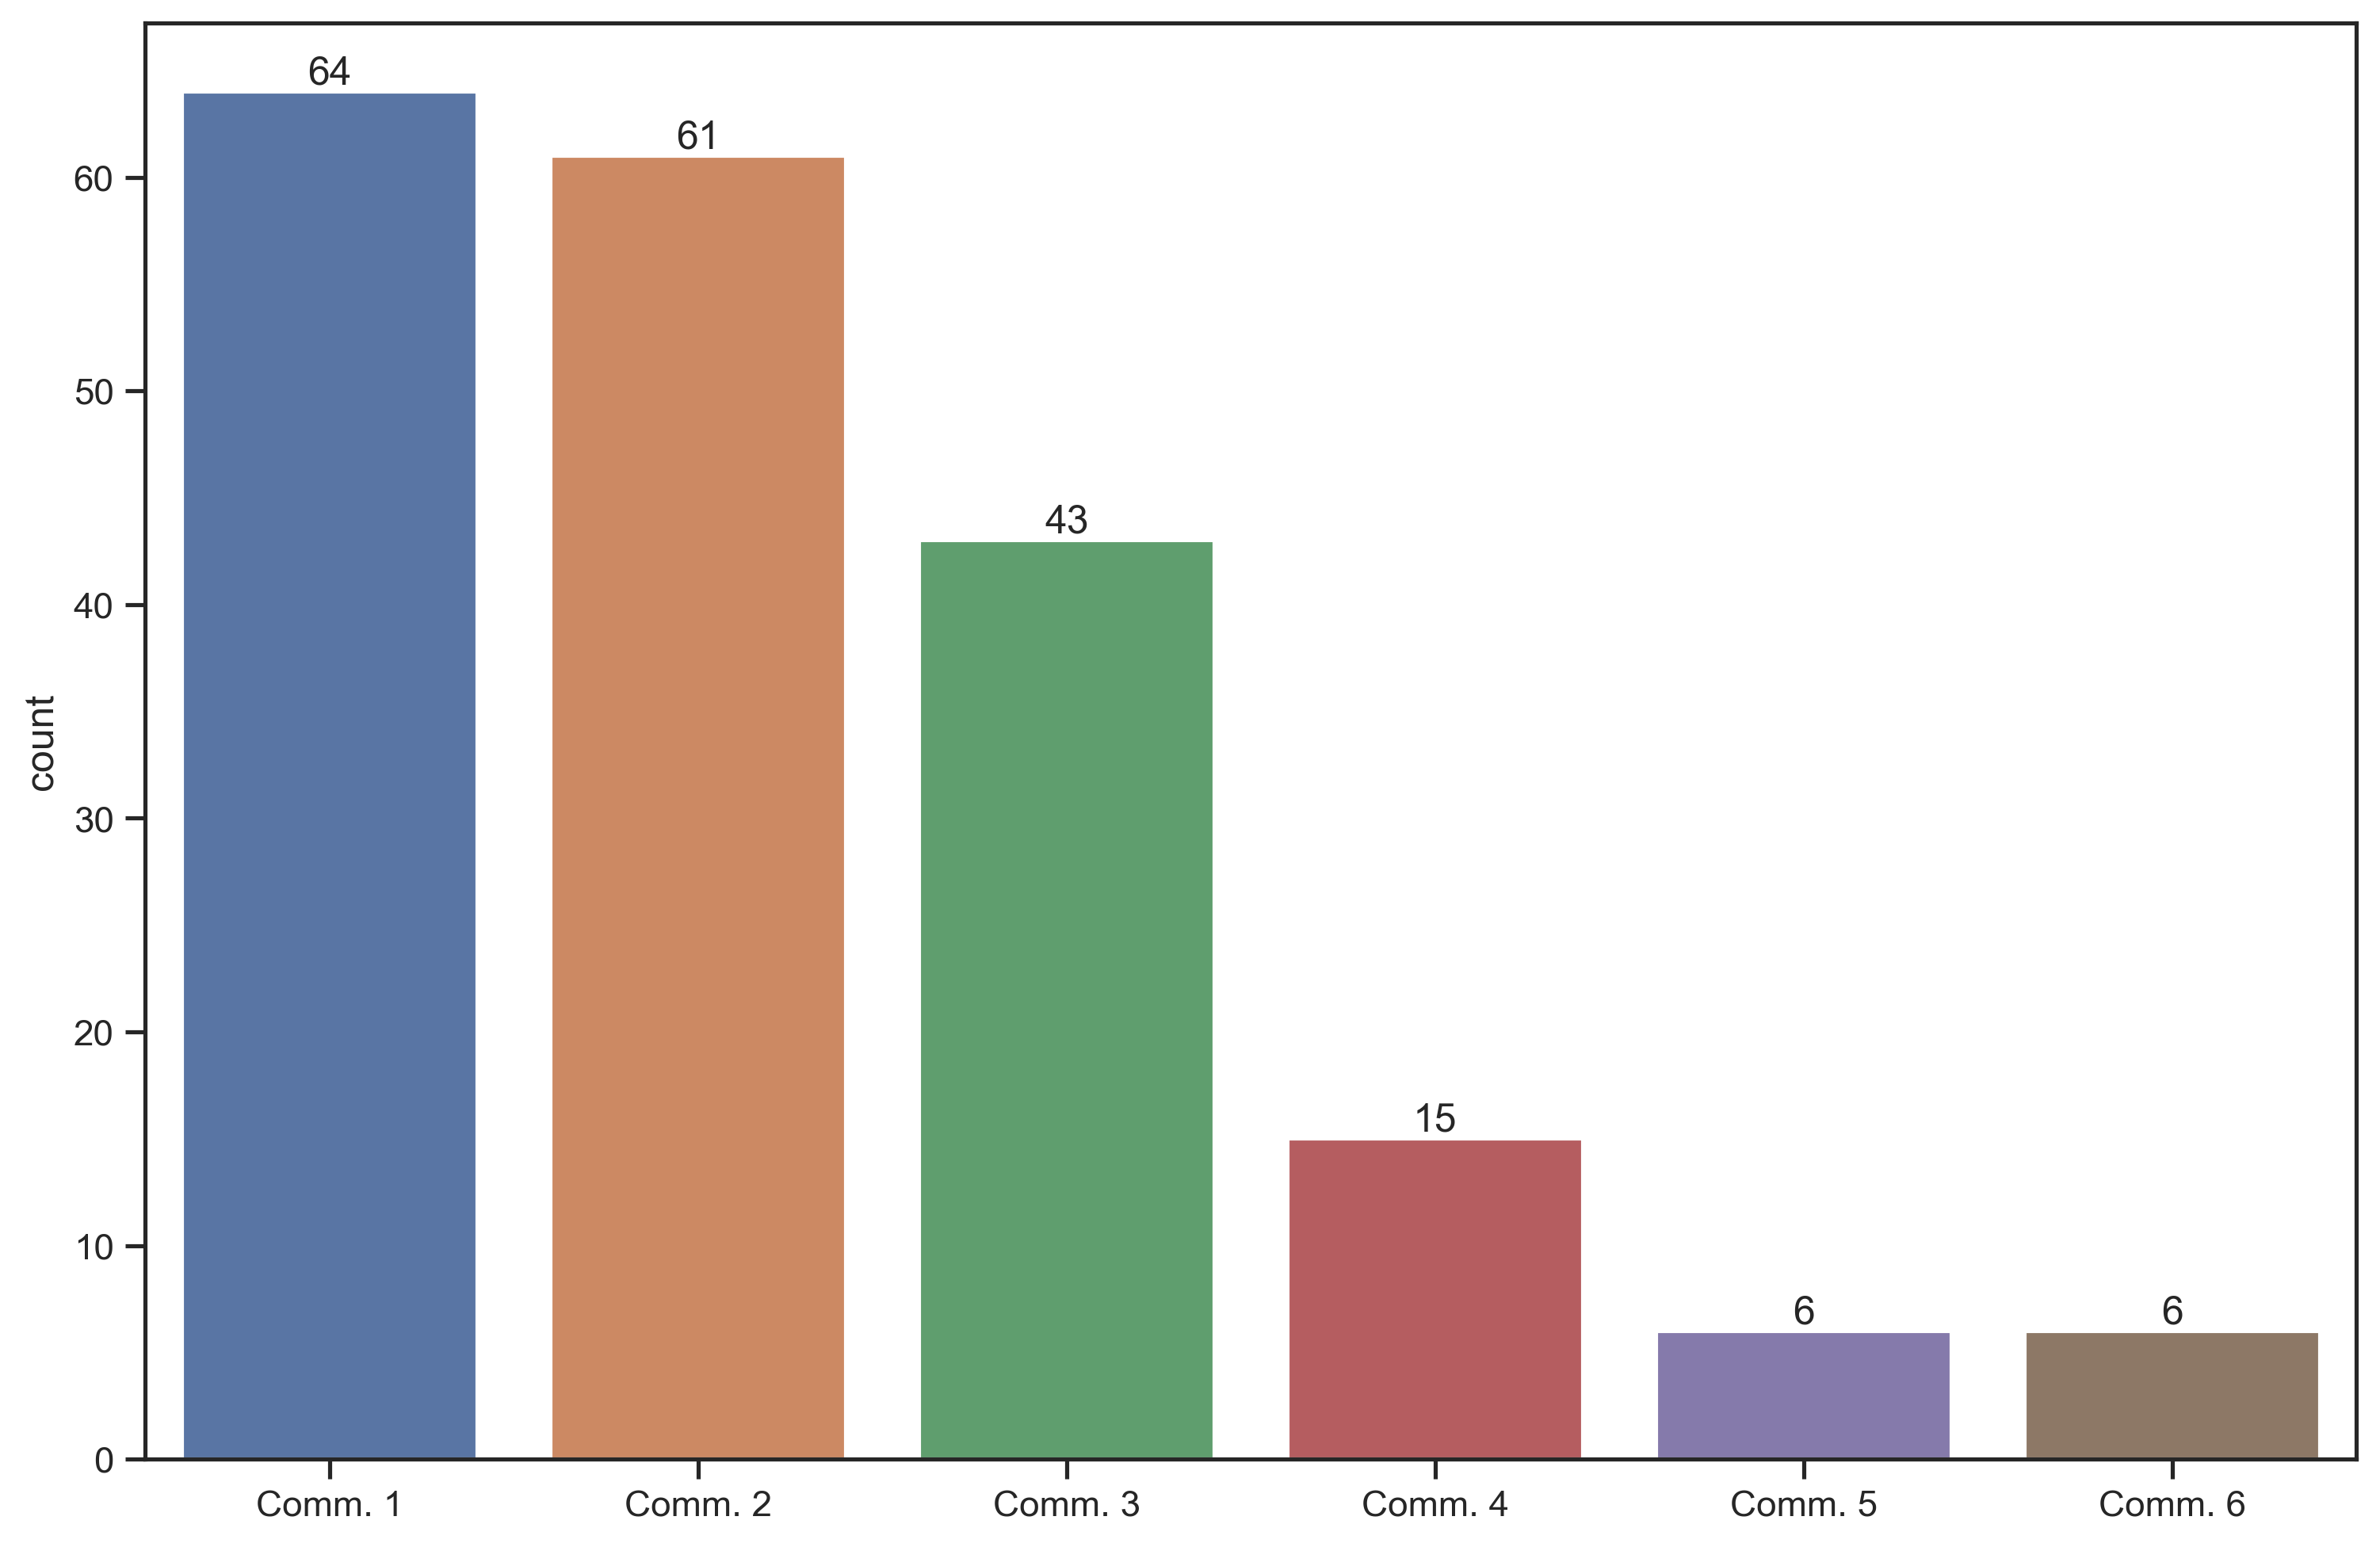

In [41]:
fig, ax = plt.subplots(figsize=(12,8), dpi=300)
sns.countplot(x='Greedy Comm.', data=greedy_df, ax=ax)
ax.set_xlabel('')
ax.bar_label(ax.containers[0])
plt.show()

# Centrality in the community

In [ ]:
#In-degree
w_in_degree[list(greedy_comm[3])].sort_values(ascending=False).head()

In [20]:
#Out-degree
w_out_degree[list(greedy_comm[3])].sort_values(ascending=False).head()

ARG    2353630.282
UKR    2330203.288
BRA     116765.046
PRY      82555.017
URY      53459.354
dtype: float64

In [21]:
#Closeness centrality
cl_centr[list(greedy_comm[3])].sort_values(ascending=False).head()

THA    0.480851
ISR    0.461224
KEN    0.457490
IDN    0.450199
TUN    0.436293
dtype: float64

In [ ]:
#density
nx.density(G.subgraph(greedy_comm[3]))

# Partition evaluation

In [28]:
greedy = [set(greedy_comm[i]) for i in range(len(greedy_comm))]

In [31]:
print("Modularity", nx_comm.modularity(G, greedy, weight='weight'))

print("Coverage", nx_comm.coverage(G, greedy))

print("Performance", nx_comm.performance(G, greedy))

Modularity 0.46188453806875107
Coverage 0.4891139240506329
Performance 0.7406555643669046


Go to [Index](#Index)